## Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 ao 10.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.8,0.0)],[complex(0.6,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-0.17566802  0.83892705  0.80894582]
 Conferindo: (0.060253489956549+0j)
Iteração: 2
Mínimo: [ 0.40428926  0.88418882 -0.17566802]
 Conferindo: (0.060153366975055675+0j)
Iteração: 3
Mínimo: [0.44526666 0.89396265 0.40428926]
 Conferindo: (0.05998325967758919+0j)
Iteração: 4
Mínimo: [0.43773748 0.90561858 0.44526666]
 Conferindo: (0.05980568052002787+0j)
Iteração: 5
Mínimo: [0.45435231 0.89497493 0.43773748]
 Conferindo: (0.0596271718136224+0j)
Iteração: 6
Mínimo: [0.43557061 0.90765567 0.45435231]
 Conferindo: (0.059448080059280234+0j)
Iteração: 7
Mínimo: [0.45826859 0.88989368 0.43557061]
 Conferindo: (0.05926985316977966+0j)
Iteração: 8
Mínimo: [0.51005148 0.80555653 0.45826859]
 Conferindo: (0.05909179706473436+0j)
Iteração: 9
Mínimo: [0.37842634 0.88811814 0.51005148]
 Conferindo: (0.05892176996459414+0j)
Iteração: 10
Mínimo: [0.45129749 0.8920512  0.37842634]
 Conferindo: (0.05875758405123627+0j)
Iteração: 11
Mínimo: [0.50098775 0.80167462 0.45129749]
 Conferi

Mínimo: [0.3152623  0.73418313 0.41975257]
 Conferindo: (0.04727425960974363+0j)
Iteração: 91
Mínimo: [0.3720085  0.73798209 0.3152623 ]
 Conferindo: (0.04716135635633409+0j)
Iteração: 92
Mínimo: [0.41608819 0.66210894 0.3720085 ]
 Conferindo: (0.047042161946241993+0j)
Iteração: 93
Mínimo: [0.31241686 0.72785105 0.41608819]
 Conferindo: (0.04692751375212851+0j)
Iteração: 94
Mínimo: [0.36877408 0.73152085 0.31241686]
 Conferindo: (0.04681658885794409+0j)
Iteração: 95
Mínimo: [0.41240726 0.6560695  0.36877408]
 Conferindo: (0.04669948669888148+0j)
Iteração: 96
Mínimo: [0.30976589 0.7210826  0.41240726]
 Conferindo: (0.046586869536703004+0j)
Iteração: 97
Mínimo: [0.36527484 0.72488538 0.30976589]
 Conferindo: (0.04647793235420699+0j)
Iteração: 98
Mínimo: [0.4088058  0.65002506 0.36527484]
 Conferindo: (0.04636294407834991+0j)
Iteração: 99
Mínimo: [0.30684741 0.7145675  0.4088058 ]
 Conferindo: (0.04625234969846749+0j)
Iteração: 100
Mínimo: [0.36209367 0.71817218 0.30684741]
 Conferindo: (

Mínimo: [0.2315124  0.53791154 0.30803758]
 Conferindo: (0.03934194575169567+0j)
Iteração: 181
Mínimo: [0.27245347 0.54028729 0.2315124 ]
 Conferindo: (0.039281233836630534+0j)
Iteração: 182
Mínimo: [0.30460415 0.48433155 0.27245347]
 Conferindo: (0.03921726272167047+0j)
Iteração: 183
Mínimo: [0.22879628 0.53166369 0.30460415]
 Conferindo: (0.03915582774680867+0j)
Iteração: 184
Mínimo: [0.26937527 0.53394424 0.22879628]
 Conferindo: (0.03909651576782664+0j)
Iteração: 185
Mínimo: [0.30095064 0.47879049 0.26937527]
 Conferindo: (0.039034021098694346+0j)
Iteração: 186
Mínimo: [0.22618556 0.52542742 0.30095064]
 Conferindo: (0.038974008521052594+0j)
Iteração: 187
Mínimo: [0.26624604 0.52770628 0.22618556]
 Conferindo: (0.038916062359867346+0j)
Iteração: 188
Mínimo: [0.29743475 0.47318753 0.26624604]
 Conferindo: (0.038855014000577906+0j)
Iteração: 189
Mínimo: [0.22351589 0.51930698 0.29743475]
 Conferindo: (0.03879639266454847+0j)
Iteração: 190
Mínimo: [0.26318891 0.52153438 0.22351589]
 C

Mínimo: [0.12229522 0.35209602 0.26197346]
 Conferindo: (0.03535935950126162+0j)
Iteração: 270
Mínimo: [0.18028323 0.36896454 0.12229522]
 Conferindo: (0.03533349994086135+0j)
Iteração: 271
Mínimo: [0.25371002 0.27880752 0.18028323]
 Conferindo: (0.03530387038367562+0j)
Iteração: 272
Mínimo: [0.11811876 0.35983211 0.25371002]
 Conferindo: (0.035275952290524624+0j)
Iteração: 273
Mínimo: [0.18695304 0.36074118 0.11811876]
 Conferindo: (0.03525036665058874+0j)
Iteração: 274
Mínimo: [0.20391133 0.33283978 0.18695304]
 Conferindo: (0.03522074823756852+0j)
Iteração: 275
Mínimo: [0.16203081 0.36863158 0.20391133]
 Conferindo: (0.0351922425244056+0j)
Iteração: 276
Mínimo: [0.24816063 0.26734887 0.16203081]
 Conferindo: (0.03516517664370797+0j)
Iteração: 277
Mínimo: [0.11447915 0.34962605 0.24816063]
 Conferindo: (0.035138703528824845+0j)
Iteração: 278
Mínimo: [0.18112523 0.35418505 0.11447915]
 Conferindo: (0.03511438713458498+0j)
Iteração: 279
Mínimo: [0.24209041 0.27218155 0.18112523]
 Confe

Mínimo: [0.16588445 0.19851164 0.06521858]
 Conferindo: (0.033662229483175946+0j)
Iteração: 360
Mínimo: [0.12006554 0.16425328 0.16588445]
 Conferindo: (0.0336501028565497+0j)
Iteração: 361
Mínimo: [0.14813418 0.16650049 0.12006554]
 Conferindo: (0.03363950339755026+0j)
Iteração: 362
Mínimo: [0.07378319 0.22006785 0.14813418]
 Conferindo: (0.03362901958041413+0j)
Iteração: 363
Mínimo: [0.15761739 0.1553679  0.07378319]
 Conferindo: (0.033618597259143734+0j)
Iteração: 364
Mínimo: [0.11670875 0.16469522 0.15761739]
 Conferindo: (0.03360660908223036+0j)
Iteração: 365
Mínimo: [0.13974285 0.18919338 0.11670875]
 Conferindo: (0.03359590402784122+0j)
Iteração: 366
Mínimo: [0.13974285 0.13974285 0.13974285]
 Conferindo: (0.03358588589936882+0j)
Iteração: 367
Mínimo: [0.06245149 0.22401188 0.13974285]
 Conferindo: (0.03357626793614711+0j)
Iteração: 368
Mínimo: [0.15788526 0.15077704 0.06245149]
 Conferindo: (0.03356638596642863+0j)
Iteração: 369
Mínimo: [0.11790759 0.16056855 0.15788526]
 Confe

Mínimo: [0.0988968  0.11737718 0.05599791]
 Conferindo: (0.03302714247127041+0j)
Iteração: 449
Mínimo: [0.0988968 0.0988968 0.0988968]
 Conferindo: (0.033022487721953285+0j)
Iteração: 450
Mínimo: [0.06453869 0.10202497 0.0988968 ]
 Conferindo: (0.03301827046266904+0j)
Iteração: 451
Mínimo: [0.08742891 0.0905651  0.06453869]
 Conferindo: (0.03301398647705533+0j)
Iteração: 452
Mínimo: [0.08742891 0.08742891 0.08742891]
 Conferindo: (0.03300913097390487+0j)
Iteração: 453
Mínimo: [0.08742891 0.08742891 0.08742891]
 Conferindo: (0.03300434774300595+0j)
Iteração: 454
Mínimo: [0.08742891 0.08742891 0.08742891]
 Conferindo: (0.03299968630184207+0j)
Iteração: 455
Mínimo: [0.08742891 0.08742891 0.08742891]
 Conferindo: (0.032995165837991974+0j)
Iteração: 456
Mínimo: [0.08742891 0.08742891 0.08742891]
 Conferindo: (0.032990805403173534+0j)
Iteração: 457
Mínimo: [0.08742891 0.08742891 0.08742891]
 Conferindo: (0.03298662389441571+0j)
Iteração: 458
Mínimo: [0.08742891 0.08742891 0.08742891]
 Confer

Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.032705764392141415+0j)
Iteração: 554
Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.03270373943245926+0j)
Iteração: 555
Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.032701750476413674+0j)
Iteração: 556
Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.032699805660607574+0j)
Iteração: 557
Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.0326979130786622+0j)
Iteração: 558
Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.032696080773224424+0j)
Iteração: 559
Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.03269431672802461+0j)
Iteração: 560
Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.032692628859993134+0j)
Iteração: 561
Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.03269102501144233+0j)
Iteração: 562
Mínimo: [0.05645234 0.05645234 0.05645234]
 Conferindo: (0.03268951294232233+0j)
Iteração: 563
Mínimo: [0.05645234 0.05645234 0.05645234]
 Co

Mínimo: [0.04466143 0.04252445 0.03030642]
 Conferindo: (0.03255719251909792+0j)
Iteração: 669
Mínimo: [0.04466143 0.04466143 0.04466143]
 Conferindo: (0.032556157652916876+0j)
Iteração: 670
Mínimo: [0.04466143 0.04466143 0.04466143]
 Conferindo: (0.03255542879515219+0j)
Iteração: 671
Mínimo: [0.02905042 0.03980079 0.04466143]
 Conferindo: (0.0325548733791121+0j)
Iteração: 672
Mínimo: [0.02905042 0.02905042 0.02905042]
 Conferindo: (0.03255440652178196+0j)
Iteração: 673
Mínimo: [0.02905042 0.02905042 0.02905042]
 Conferindo: (0.03255385347631042+0j)
Iteração: 674
Mínimo: [0.02905042 0.02905042 0.02905042]
 Conferindo: (0.03255323354195627+0j)
Iteração: 675
Mínimo: [0.02905042 0.02905042 0.02905042]
 Conferindo: (0.03255254897644584+0j)
Iteração: 676
Mínimo: [0.02905042 0.02905042 0.02905042]
 Conferindo: (0.032551802101339164+0j)
Iteração: 677
Mínimo: [0.02905042 0.02905042 0.02905042]
 Conferindo: (0.03255099529973833+0j)
Iteração: 678
Mínimo: [0.02905042 0.02905042 0.02905042]
 Confe

Mínimo: [0.01780617 0.02717977 0.03372864]
 Conferindo: (0.032505696308593346+0j)
Iteração: 763
Mínimo: [0.01780617 0.01780617 0.01780617]
 Conferindo: (0.03250552437299681+0j)
Iteração: 764
Mínimo: [0.01780617 0.01780617 0.01780617]
 Conferindo: (0.032505302283626185+0j)
Iteração: 765
Mínimo: [0.01780617 0.01780617 0.01780617]
 Conferindo: (0.032505036643965285+0j)
Iteração: 766
Mínimo: [0.01780617 0.01780617 0.01780617]
 Conferindo: (0.03250472833535913+0j)
Iteração: 767
Mínimo: [0.01780617 0.01780617 0.01780617]
 Conferindo: (0.03250437828126872+0j)
Iteração: 768
Mínimo: [0.01780617 0.01780617 0.01780617]
 Conferindo: (0.03250398744636397+0j)
Iteração: 769
Mínimo: [0.01780617 0.01780617 0.01780617]
 Conferindo: (0.03250355683556973+0j)
Iteração: 770
Mínimo: [0.0320938  0.02833661 0.01780617]
 Conferindo: (0.032502938393877655+0j)
Iteração: 771
Mínimo: [0.0320938 0.0320938 0.0320938]
 Conferindo: (0.03250242754694051+0j)
Iteração: 772
Mínimo: [0.0320938 0.0320938 0.0320938]
 Conferin

Mínimo: [0.00872432 0.00872432 0.00872432]
 Conferindo: (0.032484336042699236+0j)
Iteração: 863
Mínimo: [0.02487943 0.01949121 0.00872432]
 Conferindo: (0.03248395723383272+0j)
Iteração: 864
Mínimo: [0.02487943 0.02487943 0.02487943]
 Conferindo: (0.032483653428133905+0j)
Iteração: 865
Mínimo: [0.02487943 0.02487943 0.02487943]
 Conferindo: (0.032483520171435576+0j)
Iteração: 866
Mínimo: [0.01031339 0.01801338 0.02487943]
 Conferindo: (0.032483425022250725+0j)
Iteração: 867
Mínimo: [0.01031339 0.01031339 0.01031339]
 Conferindo: (0.032483368802615376+0j)
Iteração: 868
Mínimo: [0.01031339 0.01031339 0.01031339]
 Conferindo: (0.032483290233726245+0j)
Iteração: 869
Mínimo: [0.01031339 0.01031339 0.01031339]
 Conferindo: (0.032483189665141354+0j)
Iteração: 870
Mínimo: [0.01031339 0.01031339 0.01031339]
 Conferindo: (0.032483067403683064+0j)
Iteração: 871
Mínimo: [0.01031339 0.01031339 0.01031339]
 Conferindo: (0.03248292377758203+0j)
Iteração: 872
Mínimo: [0.01031339 0.01031339 0.01031339]

Mínimo: [0.01855366 0.0133288  0.00483682]
 Conferindo: (0.03247183375700625+0j)
Iteração: 975
Mínimo: [0.01855366 0.01855366 0.01855366]
 Conferindo: (0.03247168198045648+0j)
Iteração: 976
Mínimo: [0.01855366 0.01855366 0.01855366]
 Conferindo: (0.032471650126819664+0j)
Iteração: 977
Mínimo: [0.00441285 0.01119818 0.01855366]
 Conferindo: (0.032471612061947534+0j)
Iteração: 978
Mínimo: [0.00441285 0.00441285 0.00441285]
 Conferindo: (0.03247159948779365+0j)
Iteração: 979
Mínimo: [0.00441285 0.00441285 0.00441285]
 Conferindo: (0.03247157978430807+0j)
Iteração: 980
Mínimo: [0.00441285 0.00441285 0.00441285]
 Conferindo: (0.03247155010575177+0j)
Iteração: 981
Mínimo: [0.00441285 0.00441285 0.00441285]
 Conferindo: (0.032471510518936875+0j)
Iteração: 982
Mínimo: [0.00441285 0.00441285 0.00441285]
 Conferindo: (0.032471461100458066+0j)
Iteração: 983
Mínimo: [0.00441285 0.00441285 0.00441285]
 Conferindo: (0.03247140193660901+0j)
Iteração: 984
Mínimo: [0.00441285 0.00441285 0.00441285]
 Co

Iteração: 1073
Mínimo: [0.00059655 0.00059655 0.00059655]
 Conferindo: (0.03246751536565001+0j)
Iteração: 1074
Mínimo: [0.00059655 0.00059655 0.00059655]
 Conferindo: (0.03246751162994866+0j)
Iteração: 1075
Mínimo: [0.00059655 0.00059655 0.00059655]
 Conferindo: (0.032467506262394925+0j)
Iteração: 1076
Mínimo: [0.00059655 0.00059655 0.00059655]
 Conferindo: (0.032467499268384915+0j)
Iteração: 1077
Mínimo: [0.00059655 0.00059655 0.00059655]
 Conferindo: (0.03246749065491683+0j)
Iteração: 1078
Mínimo: [0.01494393 0.00907264 0.00059655]
 Conferindo: (0.03246734938521031+0j)
Iteração: 1079
Mínimo: [0.01494393 0.01494393 0.01494393]
 Conferindo: (0.03246725390869887+0j)
Iteração: 1080
Mínimo: [0.01494393 0.01494393 0.01494393]
 Conferindo: (0.03246725342687118+0j)
Iteração: 1081
Mínimo: [0.01494393 0.01494393 0.01494393]
 Conferindo: (0.03246734206039796+0j)
Iteração: 1082
Mínimo: [-0.00406324  0.00474211  0.01494393]
 Conferindo: (0.03246730021623238+0j)
Iteração: 1083
Mínimo: [-0.00406324

Iteração: 1158
Mínimo: [-0.00016366 -0.00016366 -0.00016366]
 Conferindo: (0.03246636472639327+0j)
Iteração: 1159
Mínimo: [-0.00016366 -0.00016366 -0.00016366]
 Conferindo: (0.03246636620343597+0j)
Iteração: 1160
Mínimo: [-0.00016366 -0.00016366 -0.00016366]
 Conferindo: (0.03246636804396119+0j)
Iteração: 1161
Mínimo: [ 0.01547977  0.00863279 -0.00016366]
 Conferindo: (0.03246621814897852+0j)
Iteração: 1162
Mínimo: [0.01547977 0.01547977 0.01547977]
 Conferindo: (0.032466130348137986+0j)
Iteração: 1163
Mínimo: [0.01547977 0.01547977 0.01547977]
 Conferindo: (0.03246616014697767+0j)
Iteração: 1164
Mínimo: [-0.00130398  0.0058945   0.01547977]
 Conferindo: (0.03246612554589519+0j)
Iteração: 1165
Mínimo: [-0.00130398 -0.00130398 -0.00130398]
 Conferindo: (0.03246611559081519+0j)
Iteração: 1166
Mínimo: [-0.00130398 -0.00130398 -0.00130398]
 Conferindo: (0.032466116827317135+0j)
Iteração: 1167
Mínimo: [-0.00130398 -0.00130398 -0.00130398]
 Conferindo: (0.03246612170470501+0j)
Iteração: 1168

Mínimo: [ 0.00974895  0.00307486 -0.00662164]
 Conferindo: (0.03246540043671346+0j)
Iteração: 1255
Mínimo: [0.00974895 0.00974895 0.00974895]
 Conferindo: (0.03246534631222996+0j)
Iteração: 1256
Mínimo: [0.00974895 0.00974895 0.00974895]
 Conferindo: (0.03246534452539014+0j)
Iteração: 1257
Mínimo: [0.00974895 0.00974895 0.00974895]
 Conferindo: (0.03246538696903132+0j)
Iteração: 1258
Mínimo: [0.00974895 0.00974895 0.00974895]
 Conferindo: (0.032465473786812735+0j)
Iteração: 1259
Mínimo: [-0.00786493  0.00018974  0.00974895]
 Conferindo: (0.032465415305188254+0j)
Iteração: 1260
Mínimo: [-0.00786493 -0.00786493 -0.00786493]
 Conferindo: (0.03246539036973718+0j)
Iteração: 1261
Mínimo: [-0.00786493 -0.00786493 -0.00786493]
 Conferindo: (0.03246541883155017+0j)
Iteração: 1262
Mínimo: [-0.00786493 -0.00786493 -0.00786493]
 Conferindo: (0.032465494465926295+0j)
Iteração: 1263
Mínimo: [ 0.01069985  0.00307931 -0.00786493]
 Conferindo: (0.03246539817570591+0j)
Iteração: 1264
Mínimo: [0.01069985

Mínimo: [-6.66549977e-03 -7.59478454e-05  7.83380272e-03]
 Conferindo: (0.032465155431542325+0j)
Iteração: 1339
Mínimo: [-0.0066655 -0.0066655 -0.0066655]
 Conferindo: (0.03246513685451238+0j)
Iteração: 1340
Mínimo: [-0.0066655 -0.0066655 -0.0066655]
 Conferindo: (0.032465155330567874+0j)
Iteração: 1341
Mínimo: [-0.0066655 -0.0066655 -0.0066655]
 Conferindo: (0.032465206501112974+0j)
Iteração: 1342
Mínimo: [ 0.00849676  0.00224473 -0.0066655 ]
 Conferindo: (0.03246514444957175+0j)
Iteração: 1343
Mínimo: [0.00849676 0.00849676 0.00849676]
 Conferindo: (0.032465103105052524+0j)
Iteração: 1344
Mínimo: [0.00849676 0.00849676 0.00849676]
 Conferindo: (0.03246510418502972+0j)
Iteração: 1345
Mínimo: [0.00849676 0.00849676 0.00849676]
 Conferindo: (0.032465140914443635+0j)
Iteração: 1346
Mínimo: [0.00849676 0.00849676 0.00849676]
 Conferindo: (0.0324652133977679+0j)
Iteração: 1347
Mínimo: [-0.00778865 -0.00040965  0.00849676]
 Conferindo: (0.03246515893169884+0j)
Iteração: 1348
Mínimo: [-0.007

Mínimo: [ 0.00833658  0.00169555 -0.00757763]
 Conferindo: (0.032464989128982776+0j)
Iteração: 1440
Mínimo: [0.00833658 0.00833658 0.00833658]
 Conferindo: (0.03246494914886094+0j)
Iteração: 1441
Mínimo: [0.00833658 0.00833658 0.00833658]
 Conferindo: (0.03246495308744645+0j)
Iteração: 1442
Mínimo: [0.00833658 0.00833658 0.00833658]
 Conferindo: (0.03246499368836703+0j)
Iteração: 1443
Mínimo: [0.00833658 0.00833658 0.00833658]
 Conferindo: (0.032465071047085015+0j)
Iteração: 1444
Mínimo: [-0.00872493 -0.00107198  0.00833658]
 Conferindo: (0.03246500588216175+0j)
Iteração: 1445
Mínimo: [-0.00872493 -0.00872493 -0.00872493]
 Conferindo: (0.032464973646888474+0j)
Iteração: 1446
Mínimo: [-0.00872493 -0.00872493 -0.00872493]
 Conferindo: (0.03246499861070103+0j)
Iteração: 1447
Mínimo: [-0.00872493 -0.00872493 -0.00872493]
 Conferindo: (0.03246507436014598+0j)
Iteração: 1448
Mínimo: [ 0.00928558  0.0017483  -0.00872493]
 Conferindo: (0.032464996053131114+0j)
Iteração: 1449
Mínimo: [0.0092855

Mínimo: [-0.00828699 -0.00125504  0.00745624]
 Conferindo: (0.032464888852937364+0j)
Iteração: 1533
Mínimo: [-0.00828699 -0.00828699 -0.00828699]
 Conferindo: (0.032464859454407906+0j)
Iteração: 1534
Mínimo: [-0.00828699 -0.00828699 -0.00828699]
 Conferindo: (0.032464880156193844+0j)
Iteração: 1535
Mínimo: [-0.00828699 -0.00828699 -0.00828699]
 Conferindo: (0.032464945395553405+0j)
Iteração: 1536
Mínimo: [ 0.00834866  0.00135421 -0.00828699]
 Conferindo: (0.03246488074672934+0j)
Iteração: 1537
Mínimo: [0.00834866 0.00834866 0.00834866]
 Conferindo: (0.03246484065061461+0j)
Iteração: 1538
Mínimo: [0.00834866 0.00834866 0.00834866]
 Conferindo: (0.03246484673136245+0j)
Iteração: 1539
Mínimo: [0.00834866 0.00834866 0.00834866]
 Conferindo: (0.0324648912219476+0j)
Iteração: 1540
Mínimo: [-0.00530208  0.00055777  0.00834866]
 Conferindo: (0.03246485757928525+0j)
Iteração: 1541
Mínimo: [-0.00530208 -0.00530208 -0.00530208]
 Conferindo: (0.032464839372398746+0j)
Iteração: 1542
Mínimo: [-0.005

Mínimo: [-0.00895503 -0.00162497  0.00753696]
 Conferindo: (0.032464792922050595+0j)
Iteração: 1630
Mínimo: [-0.00895503 -0.00895503 -0.00895503]
 Conferindo: (0.03246475834467696+0j)
Iteração: 1631
Mínimo: [-0.00895503 -0.00895503 -0.00895503]
 Conferindo: (0.032464780450859765+0j)
Iteração: 1632
Mínimo: [-0.00895503 -0.00895503 -0.00895503]
 Conferindo: (0.032464853010891026+0j)
Iteração: 1633
Mínimo: [ 0.00848913  0.00111776 -0.00895503]
 Conferindo: (0.032464784633395+0j)
Iteração: 1634
Mínimo: [0.00848913 0.00848913 0.00848913]
 Conferindo: (0.03246474316734087+0j)
Iteração: 1635
Mínimo: [0.00848913 0.00848913 0.00848913]
 Conferindo: (0.03246475106214053+0j)
Iteração: 1636
Mínimo: [0.00848913 0.00848913 0.00848913]
 Conferindo: (0.03246479990100937+0j)
Iteração: 1637
Mínimo: [-0.00582838  0.00028445  0.00848913]
 Conferindo: (0.03246476125069673+0j)
Iteração: 1638
Mínimo: [-0.00582838 -0.00582838 -0.00582838]
 Conferindo: (0.032464739623295914+0j)
Iteração: 1639
Mínimo: [-0.00582

Mínimo: [ 0.00773782  0.00088258 -0.00845352]
 Conferindo: (0.03246469519802031+0j)
Iteração: 1722
Mínimo: [0.00773782 0.00773782 0.00773782]
 Conferindo: (0.03246466047591451+0j)
Iteração: 1723
Mínimo: [0.00773782 0.00773782 0.00773782]
 Conferindo: (0.032464667532251065+0j)
Iteração: 1724
Mínimo: [0.00773782 0.00773782 0.00773782]
 Conferindo: (0.0324647091518723+0j)
Iteração: 1725
Mínimo: [0.00773782 0.00773782 0.00773782]
 Conferindo: (0.03246478541031493+0j)
Iteração: 1726
Mínimo: [-0.00958939 -0.00191228  0.00773782]
 Conferindo: (0.0324647105794432+0j)
Iteração: 1727
Mínimo: [-0.00958939 -0.00958939 -0.00958939]
 Conferindo: (0.03246467074708224+0j)
Iteração: 1728
Mínimo: [-0.00958939 -0.00958939 -0.00958939]
 Conferindo: (0.03246469465456197+0j)
Iteração: 1729
Mínimo: [-0.00958939 -0.00958939 -0.00958939]
 Conferindo: (0.03246477533264558+0j)
Iteração: 1730
Mínimo: [ 0.00873703  0.00096966 -0.00958939]
 Conferindo: (0.032464701733879026+0j)
Iteração: 1731
Mínimo: [0.00873703 0.

Mínimo: [-0.00895567 -0.00184935  0.0071022 ]
 Conferindo: (0.03246462790523626+0j)
Iteração: 1815
Mínimo: [-0.00895567 -0.00895567 -0.00895567]
 Conferindo: (0.032464593021497255+0j)
Iteração: 1816
Mínimo: [-0.00895567 -0.00895567 -0.00895567]
 Conferindo: (0.03246461330038142+0j)
Iteração: 1817
Mínimo: [-0.00895567 -0.00895567 -0.00895567]
 Conferindo: (0.032464682729407016+0j)
Iteração: 1818
Mínimo: [ 0.00803593  0.0008241  -0.00895567]
 Conferindo: (0.03246461998532531+0j)
Iteração: 1819
Mínimo: [0.00803593 0.00803593 0.00803593]
 Conferindo: (0.032464582672808606+0j)
Iteração: 1820
Mínimo: [0.00803593 0.00803593 0.00803593]
 Conferindo: (0.0324645909843828+0j)
Iteração: 1821
Mínimo: [0.00803593 0.00803593 0.00803593]
 Conferindo: (0.03246463702801686+0j)
Iteração: 1822
Mínimo: [-5.89702593e-03  1.81250478e-05  8.03593232e-03]
 Conferindo: (0.032464598892509945+0j)
Iteração: 1823
Mínimo: [-0.00589703 -0.00589703 -0.00589703]
 Conferindo: (0.03246457688692431+0j)
Iteração: 1824
Míni

Mínimo: [ 0.00739967  0.00070206 -0.00837025]
 Conferindo: (0.032464541518302296+0j)
Iteração: 1907
Mínimo: [0.00739967 0.00739967 0.00739967]
 Conferindo: (0.03246450970943068+0j)
Iteração: 1908
Mínimo: [0.00739967 0.00739967 0.00739967]
 Conferindo: (0.0324645168798625+0j)
Iteração: 1909
Mínimo: [0.00739967 0.00739967 0.00739967]
 Conferindo: (0.03246455624561698+0j)
Iteração: 1910
Mínimo: [0.00739967 0.00739967 0.00739967]
 Conferindo: (0.03246462787444862+0j)
Iteração: 1911
Mínimo: [-0.0094826  -0.00202097  0.00739967]
 Conferindo: (0.032464555322853236+0j)
Iteração: 1912
Mínimo: [-0.0094826 -0.0094826 -0.0094826]
 Conferindo: (0.0324645162101017+0j)
Iteração: 1913
Mínimo: [-0.0094826 -0.0094826 -0.0094826]
 Conferindo: (0.032464538495899364+0j)
Iteração: 1914
Mínimo: [-0.0094826 -0.0094826 -0.0094826]
 Conferindo: (0.03246461550641321+0j)
Iteração: 1915
Mínimo: [ 0.00838553  0.00079423 -0.0094826 ]
 Conferindo: (0.03246454680366383+0j)
Iteração: 1916
Mínimo: [0.00838553 0.00838553

In [4]:
## Constantes

horizonte = 4
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.8,0.0)],[complex(0.6,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos4 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo4 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda4[0][iteracao] = ondaOrigem[0][0]
    valoresOnda4[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes4[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes4[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos4[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo4[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo4[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-0.66098572  0.8580434   0.93535046 -0.46067   ]
 Conferindo: (0.08023025852314869+0j)
Iteração: 2
Mínimo: [ 0.46633933  0.91195413  0.81438657 -0.66098572]
 Conferindo: (0.0800085457654541+0j)
Iteração: 3
Mínimo: [0.44717912 0.8492663  0.87817203 0.46633933]
 Conferindo: (0.07961784667147152+0j)
Iteração: 4
Mínimo: [0.44873496 0.84857104 0.8746988  0.44717912]
 Conferindo: (0.0792332112368953+0j)
Iteração: 5
Mínimo: [0.44701776 0.8462694  0.87273283 0.44873496]
 Conferindo: (0.07884998914271889+0j)
Iteração: 6
Mínimo: [0.44578591 0.84411778 0.87043827 0.44701776]
 Conferindo: (0.07846880777820306+0j)
Iteração: 7
Mínimo: [0.44469089 0.84194789 0.86817805 0.44578591]
 Conferindo: (0.07808949741434745+0j)
Iteração: 8
Mínimo: [0.44304249 0.83936654 0.86570762 0.44469089]
 Conferindo: (0.07771203889733064+0j)
Iteração: 9
Mínimo: [0.44345461 0.837989   0.86373732 0.44304249]
 Conferindo: (0.0773363610670727+0j)
Iteração: 10
Mínimo: [0.44137004 0.8355763  0.86159677 0.44

Mínimo: [0.30308432 0.66099929 0.68894298 0.35176755]
 Conferindo: (0.055513271181359104+0j)
Iteração: 82
Mínimo: [0.40400832 0.64248818 0.63808833 0.30308432]
 Conferindo: (0.05528652051539553+0j)
Iteração: 83
Mínimo: [0.34796822 0.63129792 0.66107009 0.40400832]
 Conferindo: (0.05505483740599541+0j)
Iteração: 84
Mínimo: [0.29987846 0.6538771  0.68145424 0.34796822]
 Conferindo: (0.054834728916070316+0j)
Iteração: 85
Mínimo: [0.39957826 0.63544562 0.63109086 0.29987846]
 Conferindo: (0.05461284627615906+0j)
Iteração: 86
Mínimo: [0.3442221  0.62445034 0.65384733 0.39957826]
 Conferindo: (0.054386157428170656+0j)
Iteração: 87
Mínimo: [0.29660221 0.64673309 0.67397677 0.3442221 ]
 Conferindo: (0.054170800828026236+0j)
Iteração: 88
Mínimo: [0.395245   0.62852044 0.62417426 0.29660221]
 Conferindo: (0.05395372655609215+0j)
Iteração: 89
Mínimo: [0.34045255 0.61760042 0.64667339 0.395245  ]
 Conferindo: (0.053731964467005754+0j)
Iteração: 90
Mínimo: [0.29270917 0.63914442 0.6662686  0.340452

Mínimo: [0.25839811 0.46383632 0.47716083 0.25950632]
 Conferindo: (0.04225456067459567+0j)
Iteração: 161
Mínimo: [0.25730113 0.46173901 0.47499095 0.25839811]
 Conferindo: (0.04213590720407416+0j)
Iteração: 162
Mínimo: [0.25619586 0.4597633  0.47296468 0.25730113]
 Conferindo: (0.042018262936614495+0j)
Iteração: 163
Mínimo: [0.25510374 0.45780036 0.47093274 0.25619586]
 Conferindo: (0.04190162216008904+0j)
Iteração: 164
Mínimo: [0.25401067 0.45583995 0.46891864 0.25510374]
 Conferindo: (0.04178597692732353+0j)
Iteração: 165
Mínimo: [0.25292606 0.45392335 0.46693717 0.25401067]
 Conferindo: (0.04167132043679867+0j)
Iteração: 166
Mínimo: [0.25183583 0.45196663 0.46493277 0.25292606]
 Conferindo: (0.04155764634010356+0j)
Iteração: 167
Mínimo: [0.25075171 0.44997577 0.46287763 0.25183583]
 Conferindo: (0.041444948178269235+0j)
Iteração: 168
Mínimo: [0.24967476 0.44802819 0.46087483 0.25075171]
 Conferindo: (0.041333217642490996+0j)
Iteração: 169
Mínimo: [0.24860116 0.44608848 0.45887338 0

Mínimo: [0.18222148 0.3269991  0.33624361 0.1830585 ]
 Conferindo: (0.03553378735288064+0j)
Iteração: 239
Mínimo: [0.18135933 0.3253825  0.33458064 0.18222148]
 Conferindo: (0.035474814514260336+0j)
Iteração: 240
Mínimo: [0.18052463 0.32391068 0.33305732 0.18135933]
 Conferindo: (0.03541638748570912+0j)
Iteração: 241
Mínimo: [0.1796883  0.32229909 0.33141006 0.18052463]
 Conferindo: (0.035358501731709596+0j)
Iteração: 242
Mínimo: [0.17884904 0.32080347 0.32987218 0.1796883 ]
 Conferindo: (0.035301151943870776+0j)
Iteração: 243
Mínimo: [0.17802986 0.31933044 0.32835496 0.17884904]
 Conferindo: (0.03524433414272279+0j)
Iteração: 244
Mínimo: [0.17718365 0.31782328 0.32679662 0.17802986]
 Conferindo: (0.03518804405419246+0j)
Iteração: 245
Mínimo: [0.17636958 0.31635373 0.32528603 0.17718365]
 Conferindo: (0.03513227727572181+0j)
Iteração: 246
Mínimo: [0.17555055 0.31496288 0.32386396 0.17636958]
 Conferindo: (0.03507702775541025+0j)
Iteração: 247
Mínimo: [0.17472161 0.31340181 0.32225843 0

Mínimo: [0.12519449 0.22460161 0.23090246 0.12580326]
 Conferindo: (0.03223391559463262+0j)
Iteração: 318
Mínimo: [0.12458786 0.22343286 0.22970208 0.12519449]
 Conferindo: (0.03220608274319755+0j)
Iteração: 319
Mínimo: [0.12398166 0.2223559  0.22858979 0.12458786]
 Conferindo: (0.0321785173258823+0j)
Iteração: 320
Mínimo: [0.12339325 0.22127379 0.2274774  0.12398166]
 Conferindo: (0.03215121690880356+0j)
Iteração: 321
Mínimo: [0.12280038 0.22021609 0.22639131 0.12339325]
 Conferindo: (0.0321241788149537+0j)
Iteração: 322
Mínimo: [0.12220899 0.21917961 0.22533017 0.12280038]
 Conferindo: (0.032097401343015954+0j)
Iteração: 323
Mínimo: [0.12160505 0.21810277 0.22421822 0.12220899]
 Conferindo: (0.03207088249920327+0j)
Iteração: 324
Mínimo: [0.12102221 0.21704104 0.22312298 0.12160505]
 Conferindo: (0.03204461938071513+0j)
Iteração: 325
Mínimo: [0.12044054 0.21599181 0.22204227 0.12102221]
 Conferindo: (0.0320186088144165+0j)
Iteração: 326
Mínimo: [0.11986033 0.21498657 0.22101211 0.1204

Mínimo: [0.03673676 0.15193895 0.16909509 0.08433203]
 Conferindo: (0.030753723117007324+0j)
Iteração: 397
Mínimo: [0.13579787 0.12921932 0.09612381 0.03673676]
 Conferindo: (0.030743239987430754+0j)
Iteração: 398
Mínimo: [0.08316474 0.10740912 0.12485479 0.13579787]
 Conferindo: (0.030731192985789142+0j)
Iteração: 399
Mínimo: [0.03627568 0.14990579 0.16681214 0.08316474]
 Conferindo: (0.030720941609994196+0j)
Iteração: 400
Mínimo: [0.13393665 0.1274578  0.0948304  0.03627568]
 Conferindo: (0.03071074058474026+0j)
Iteração: 401
Mínimo: [0.0820616  0.10596296 0.12315744 0.13393665]
 Conferindo: (0.030699019365262495+0j)
Iteração: 402
Mínimo: [0.03568578 0.14797419 0.16468604 0.0820616 ]
 Conferindo: (0.030689044848017585+0j)
Iteração: 403
Mínimo: [0.13217828 0.12575451 0.09351762 0.03568578]
 Conferindo: (0.030679118850826526+0j)
Iteração: 404
Mínimo: [0.08094632 0.10452936 0.12151054 0.13217828]
 Conferindo: (0.03066770990809998+0j)
Iteração: 405
Mínimo: [0.03522352 0.14595158 0.162432

Mínimo: [0.01312572 0.10046779 0.11772735 0.07017942]
 Conferindo: (0.030131254120120275+0j)
Iteração: 476
Mínimo: [0.09819281 0.0907039  0.06230032 0.01312572]
 Conferindo: (0.030126425254349505+0j)
Iteração: 477
Mínimo: [0.05674526 0.07442479 0.08817147 0.09819281]
 Conferindo: (0.030120494589459455+0j)
Iteração: 478
Mínimo: [0.06899263 0.07909438 0.07494486 0.05674526]
 Conferindo: (0.030115940501906906+0j)
Iteração: 479
Mínimo: [0.01356927 0.09720178 0.11400244 0.06899263]
 Conferindo: (0.03011111373852162+0j)
Iteração: 480
Mínimo: [0.09571758 0.08869721 0.06126717 0.01356927]
 Conferindo: (0.03010647236889835+0j)
Iteração: 481
Mínimo: [0.05564596 0.0729515  0.08624244 0.09571758]
 Conferindo: (0.03010079121846638+0j)
Iteração: 482
Mínimo: [0.06768153 0.07764164 0.07356667 0.05564596]
 Conferindo: (0.030096407237082526+0j)
Iteração: 483
Mínimo: [0.01320753 0.09559883 0.11211488 0.06768153]
 Conferindo: (0.03009175658961157+0j)
Iteração: 484
Mínimo: [0.09406108 0.08713722 0.06014023

Mínimo: [0.03563607 0.04931781 0.0557357  0.05504904]
 Conferindo: (0.029864358013546834+0j)
Iteração: 557
Mínimo: [0.04862979 0.05482955 0.05045678 0.03563607]
 Conferindo: (0.029862179763842242+0j)
Iteração: 558
Mínimo: [0.04862979 0.04862979 0.04862979 0.04862979]
 Conferindo: (0.029860051116151025+0j)
Iteração: 559
Mínimo: [0.03141127 0.04630308 0.0519894  0.04862979]
 Conferindo: (0.02985805003407192+0j)
Iteração: 560
Mínimo: [0.04648274 0.0524686  0.04740536 0.03141127]
 Conferindo: (0.029856093853640284+0j)
Iteração: 561
Mínimo: [0.04648274 0.04648274 0.04648274 0.04648274]
 Conferindo: (0.02985410654542898+0j)
Iteração: 562
Mínimo: [0.03145682 0.0459237  0.05088096 0.04648274]
 Conferindo: (0.029852192364469184+0j)
Iteração: 563
Mínimo: [0.04522777 0.0515569  0.04692708 0.03145682]
 Conferindo: (0.029850310263571087+0j)
Iteração: 564
Mínimo: [0.04522777 0.04522777 0.04522777 0.04522777]
 Conferindo: (0.029848397313757942+0j)
Iteração: 565
Mínimo: [0.04522777 0.04522777 0.045227

Mínimo: [0.03262895 0.03604892 0.03068007 0.0165924 ]
 Conferindo: (0.02974394918004668+0j)
Iteração: 644
Mínimo: [0.03262895 0.03262895 0.03262895 0.03262895]
 Conferindo: (0.02974298334723308+0j)
Iteração: 645
Mínimo: [0.03262895 0.03262895 0.03262895 0.03262895]
 Conferindo: (0.02974211274420771+0j)
Iteração: 646
Mínimo: [0.01844015 0.02998474 0.03467853 0.03262895]
 Conferindo: (0.02974125475068678+0j)
Iteração: 647
Mínimo: [0.03206945 0.03581229 0.03124572 0.01844015]
 Conferindo: (0.029740364191373422+0j)
Iteração: 648
Mínimo: [0.03206945 0.03206945 0.03206945 0.03206945]
 Conferindo: (0.029739419215589+0j)
Iteração: 649
Mínimo: [0.03206945 0.03206945 0.03206945 0.03206945]
 Conferindo: (0.029738560441994664+0j)
Iteração: 650
Mínimo: [0.03206945 0.03206945 0.03206945 0.03206945]
 Conferindo: (0.029737795679422908+0j)
Iteração: 651
Mínimo: [0.01594802 0.02785212 0.03319503 0.03206945]
 Conferindo: (0.029737023805929873+0j)
Iteração: 652
Mínimo: [0.03134933 0.03468817 0.02953243 0.

Mínimo: [0.02240362 0.02494075 0.02081143 0.01006508]
 Conferindo: (0.029691835597157143+0j)
Iteração: 729
Mínimo: [0.02240362 0.02240362 0.02240362 0.02240362]
 Conferindo: (0.02969136626410556+0j)
Iteração: 730
Mínimo: [0.02240362 0.02240362 0.02240362 0.02240362]
 Conferindo: (0.029690927131213542+0j)
Iteração: 731
Mínimo: [0.02240362 0.02240362 0.02240362 0.02240362]
 Conferindo: (0.029690519149868887+0j)
Iteração: 732
Mínimo: [0.02240362 0.02240362 0.02240362 0.02240362]
 Conferindo: (0.029690143804544704+0j)
Iteração: 733
Mínimo: [0.02240362 0.02240362 0.02240362 0.02240362]
 Conferindo: (0.029689802547519132+0j)
Iteração: 734
Mínimo: [0.02240362 0.02240362 0.02240362 0.02240362]
 Conferindo: (0.029689496797446438+0j)
Iteração: 735
Mínimo: [0.00938113 0.01823802 0.02255612 0.02240362]
 Conferindo: (0.029689152568373952+0j)
Iteração: 736
Mínimo: [0.02159107 0.02403721 0.0199512  0.00938113]
 Conferindo: (0.029688767228099513+0j)
Iteração: 737
Mínimo: [0.02159107 0.02159107 0.02159

Mínimo: [0.01683241 0.01683241 0.01683241 0.01683241]
 Conferindo: (0.029670104620981717+0j)
Iteração: 807
Mínimo: [0.00458805 0.01190069 0.0159684  0.01683241]
 Conferindo: (0.029669938158015413+0j)
Iteração: 808
Mínimo: [0.01550786 0.01734903 0.01369946 0.00458805]
 Conferindo: (0.02966974576941056+0j)
Iteração: 809
Mínimo: [0.01550786 0.01550786 0.01550786 0.01550786]
 Conferindo: (0.0296695106686062+0j)
Iteração: 810
Mínimo: [0.01550786 0.01550786 0.01550786 0.01550786]
 Conferindo: (0.029669279138538326+0j)
Iteração: 811
Mínimo: [0.01550786 0.01550786 0.01550786 0.01550786]
 Conferindo: (0.029669050087918265+0j)
Iteração: 812
Mínimo: [0.01550786 0.01550786 0.01550786 0.01550786]
 Conferindo: (0.029668824261378415+0j)
Iteração: 813
Mínimo: [0.01550786 0.01550786 0.01550786 0.01550786]
 Conferindo: (0.0296686024003774+0j)
Iteração: 814
Mínimo: [0.01550786 0.01550786 0.01550786 0.01550786]
 Conferindo: (0.029668385242464408+0j)
Iteração: 815
Mínimo: [0.01550786 0.01550786 0.01550786 

Mínimo: [0.01082054 0.01082054 0.01082054 0.01082054]
 Conferindo: (0.02965723096514571+0j)
Iteração: 897
Mínimo: [0.01082054 0.01082054 0.01082054 0.01082054]
 Conferindo: (0.029657093231117652+0j)
Iteração: 898
Mínimo: [0.01082054 0.01082054 0.01082054 0.01082054]
 Conferindo: (0.02965695322250888+0j)
Iteração: 899
Mínimo: [0.01082054 0.01082054 0.01082054 0.01082054]
 Conferindo: (0.029656811329746707+0j)
Iteração: 900
Mínimo: [0.01082054 0.01082054 0.01082054 0.01082054]
 Conferindo: (0.029656667945118464+0j)
Iteração: 901
Mínimo: [0.01082054 0.01082054 0.01082054 0.01082054]
 Conferindo: (0.029656523462382754+0j)
Iteração: 902
Mínimo: [0.01082054 0.01082054 0.01082054 0.01082054]
 Conferindo: (0.029656378276381786+0j)
Iteração: 903
Mínimo: [0.01082054 0.01082054 0.01082054 0.01082054]
 Conferindo: (0.02965623278265084+0j)
Iteração: 904
Mínimo: [0.01082054 0.01082054 0.01082054 0.01082054]
 Conferindo: (0.029656087377028306+0j)
Iteração: 905
Mínimo: [0.01082054 0.01082054 0.0108205

Mínimo: [0.01554191 0.01409533 0.01033414 0.00428459]
 Conferindo: (0.02964912223540304+0j)
Iteração: 982
Mínimo: [0.01554191 0.01554191 0.01554191 0.01554191]
 Conferindo: (0.02964902125442859+0j)
Iteração: 983
Mínimo: [0.0041515  0.00797399 0.01176145 0.01554191]
 Conferindo: (0.029648914430435623+0j)
Iteração: 984
Mínimo: [0.0041515 0.0041515 0.0041515 0.0041515]
 Conferindo: (0.029648885637300924+0j)
Iteração: 985
Mínimo: [0.0041515 0.0041515 0.0041515 0.0041515]
 Conferindo: (0.029648821465078384+0j)
Iteração: 986
Mínimo: [0.0041515 0.0041515 0.0041515 0.0041515]
 Conferindo: (0.029648745344082572+0j)
Iteração: 987
Mínimo: [0.01509595 0.0136861  0.01003061 0.0041515 ]
 Conferindo: (0.029648534251171435+0j)
Iteração: 988
Mínimo: [0.01509595 0.01509595 0.01509595 0.01509595]
 Conferindo: (0.029648438335110522+0j)
Iteração: 989
Mínimo: [0.00404903 0.00775798 0.01143094 0.01509595]
 Conferindo: (0.029648337416431983+0j)
Iteração: 990
Mínimo: [0.00404903 0.00404903 0.00404903 0.0040490

Mínimo: [0.00147131 0.00147131 0.00147131 0.00147131]
 Conferindo: (0.029642935650436835+0j)
Iteração: 1068
Mínimo: [0.01288043 0.01084788 0.00703898 0.00147131]
 Conferindo: (0.02964278230284876+0j)
Iteração: 1069
Mínimo: [0.01288043 0.01288043 0.01288043 0.01288043]
 Conferindo: (0.029642743750224274+0j)
Iteração: 1070
Mínimo: [0.00152541 0.00478769 0.00856713 0.01288043]
 Conferindo: (0.029642673254827542+0j)
Iteração: 1071
Mínimo: [0.00152541 0.00152541 0.00152541 0.00152541]
 Conferindo: (0.02964267496417268+0j)
Iteração: 1072
Mínimo: [0.00152541 0.00152541 0.00152541 0.00152541]
 Conferindo: (0.029642656130587572+0j)
Iteração: 1073
Mínimo: [0.00152541 0.00152541 0.00152541 0.00152541]
 Conferindo: (0.02964263296675276+0j)
Iteração: 1074
Mínimo: [0.012239   0.01037383 0.00679684 0.00152541]
 Conferindo: (0.02964249497834326+0j)
Iteração: 1075
Mínimo: [0.012239 0.012239 0.012239 0.012239]
 Conferindo: (0.029642458402726224+0j)
Iteração: 1076
Mínimo: [0.00154217 0.00465266 0.0082123

 Conferindo: (0.02964085247239001+0j)
Iteração: 1145
Mínimo: [-0.00372085 -0.00372085 -0.00372085 -0.00372085]
 Conferindo: (0.029640902273719075+0j)
Iteração: 1146
Mínimo: [ 0.0075679   0.00606094  0.0022974  -0.00372085]
 Conferindo: (0.029640824379538817+0j)
Iteração: 1147
Mínimo: [0.0075679 0.0075679 0.0075679 0.0075679]
 Conferindo: (0.029640814757005217+0j)
Iteração: 1148
Mínimo: [0.0075679 0.0075679 0.0075679 0.0075679]
 Conferindo: (0.02964082673693266+0j)
Iteração: 1149
Mínimo: [0.0075679 0.0075679 0.0075679 0.0075679]
 Conferindo: (0.02964086208932355+0j)
Iteração: 1150
Mínimo: [-0.00397673 -0.00017011  0.00367616  0.0075679 ]
 Conferindo: (0.029640816962480512+0j)
Iteração: 1151
Mínimo: [-0.00397673 -0.00397673 -0.00397673 -0.00397673]
 Conferindo: (0.029640869148906106+0j)
Iteração: 1152
Mínimo: [ 0.00744985  0.00589402  0.00208501 -0.00397673]
 Conferindo: (0.029640789649969124+0j)
Iteração: 1153
Mínimo: [0.00744985 0.00744985 0.00744985 0.00744985]
 Conferindo: (0.0296407

Mínimo: [-0.0048483  -0.00114267  0.00276652  0.00688207]
 Conferindo: (0.029640518897900536+0j)
Iteração: 1224
Mínimo: [-0.0048483 -0.0048483 -0.0048483 -0.0048483]
 Conferindo: (0.029640572739420237+0j)
Iteração: 1225
Mínimo: [ 0.00679686  0.00504477  0.00116282 -0.0048483 ]
 Conferindo: (0.02964049907786615+0j)
Iteração: 1226
Mínimo: [0.00679686 0.00679686 0.00679686 0.00679686]
 Conferindo: (0.02964049720809604+0j)
Iteração: 1227
Mínimo: [0.00679686 0.00679686 0.00679686 0.00679686]
 Conferindo: (0.029640513997966925+0j)
Iteração: 1228
Mínimo: [0.00679686 0.00679686 0.00679686 0.00679686]
 Conferindo: (0.029640551944392933+0j)
Iteração: 1229
Mínimo: [-0.0047479  -0.0011048   0.00274174  0.00679686]
 Conferindo: (0.029640505291308496+0j)
Iteração: 1230
Mínimo: [-0.0047479 -0.0047479 -0.0047479 -0.0047479]
 Conferindo: (0.029640556523745046+0j)
Iteração: 1231
Mínimo: [ 0.00662374  0.00492359  0.00113096 -0.0047479 ]
 Conferindo: (0.02964048625218841+0j)
Iteração: 1232
Mínimo: [0.0066

Mínimo: [ 0.00574562  0.00415272  0.00071326 -0.00457324]
 Conferindo: (0.029640410092427318+0j)
Iteração: 1305
Mínimo: [0.00574562 0.00574562 0.00574562 0.00574562]
 Conferindo: (0.029640410634324616+0j)
Iteração: 1306
Mínimo: [0.00574562 0.00574562 0.00574562 0.00574562]
 Conferindo: (0.02964042463015959+0j)
Iteração: 1307
Mínimo: [0.00574562 0.00574562 0.00574562 0.00574562]
 Conferindo: (0.029640454308915373+0j)
Iteração: 1308
Mínimo: [-0.00438801 -0.00123176  0.00214403  0.00574562]
 Conferindo: (0.02964041744373922+0j)
Iteração: 1309
Mínimo: [-0.00438801 -0.00438801 -0.00438801 -0.00438801]
 Conferindo: (0.0296404562288492+0j)
Iteração: 1310
Mínimo: [ 0.00557496  0.0040463   0.00072454 -0.00438801]
 Conferindo: (0.02964040398897865+0j)
Iteração: 1311
Mínimo: [0.00557496 0.00557496 0.00557496 0.00557496]
 Conferindo: (0.02964040397558497+0j)
Iteração: 1312
Mínimo: [0.00557496 0.00557496 0.00557496 0.00557496]
 Conferindo: (0.029640416610995608+0j)
Iteração: 1313
Mínimo: [0.0055749

Mínimo: [ 0.00539003  0.00367933  0.00017303 -0.00512747]
 Conferindo: (0.02964044131748041+0j)
Iteração: 1385
Mínimo: [0.00539003 0.00539003 0.00539003 0.00539003]
 Conferindo: (0.029640445651820765+0j)
Iteração: 1386
Mínimo: [0.00539003 0.00539003 0.00539003 0.00539003]
 Conferindo: (0.029640462013867913+0j)
Iteração: 1387
Mínimo: [0.00539003 0.00539003 0.00539003 0.00539003]
 Conferindo: (0.029640493314802195+0j)
Iteração: 1388
Mínimo: [-0.0049289  -0.00180231  0.00163687  0.00539003]
 Conferindo: (0.029640453463909776+0j)
Iteração: 1389
Mínimo: [-0.0049289 -0.0049289 -0.0049289 -0.0049289]
 Conferindo: (0.029640492696107707+0j)
Iteração: 1390
Mínimo: [ 0.00525126  0.0036012   0.00020765 -0.0049289 ]
 Conferindo: (0.029640441948915543+0j)
Iteração: 1391
Mínimo: [0.00525126 0.00525126 0.00525126 0.00525126]
 Conferindo: (0.029640445631121847+0j)
Iteração: 1392
Mínimo: [0.00525126 0.00525126 0.00525126 0.00525126]
 Conferindo: (0.02964046074273006+0j)
Iteração: 1393
Mínimo: [0.0052512

Mínimo: [ 0.00837455  0.0058471   0.00234364 -0.00212984]
 Conferindo: (0.02964016131652887+0j)
Iteração: 1466
Mínimo: [0.00837455 0.00837455 0.00837455 0.00837455]
 Conferindo: (0.029640178204222746+0j)
Iteração: 1467
Mínimo: [-0.00193062  0.00038061  0.00381266  0.00837455]
 Conferindo: (0.029640136840595327+0j)
Iteração: 1468
Mínimo: [-0.00193062 -0.00193062 -0.00193062 -0.00193062]
 Conferindo: (0.02964015156258018+0j)
Iteração: 1469
Mínimo: [-0.00193062 -0.00193062 -0.00193062 -0.00193062]
 Conferindo: (0.029640164124490415+0j)
Iteração: 1470
Mínimo: [-0.00193062 -0.00193062 -0.00193062 -0.00193062]
 Conferindo: (0.029640181738790784+0j)
Iteração: 1471
Mínimo: [-0.00193062 -0.00193062 -0.00193062 -0.00193062]
 Conferindo: (0.029640204395484364+0j)
Iteração: 1472
Mínimo: [ 0.0097964   0.00679759  0.00288588 -0.00193062]
 Conferindo: (0.029640113368185984+0j)
Iteração: 1473
Mínimo: [0.0097964 0.0097964 0.0097964 0.0097964]
 Conferindo: (0.02964014020943218+0j)
Iteração: 1474
Mínimo:

Mínimo: [ 0.00493074  0.00272766 -0.00135916 -0.00733526]
 Conferindo: (0.02964004952124033+0j)
Iteração: 1552
Mínimo: [0.00493074 0.00493074 0.00493074 0.00493074]
 Conferindo: (0.029640063190031873+0j)
Iteração: 1553
Mínimo: [0.00493074 0.00493074 0.00493074 0.00493074]
 Conferindo: (0.029640086705984517+0j)
Iteração: 1554
Mínimo: [0.00493074 0.00493074 0.00493074 0.00493074]
 Conferindo: (0.029640125435366423+0j)
Iteração: 1555
Mínimo: [-0.00659032 -0.00330739  0.00053342  0.00493074]
 Conferindo: (0.02964006878804088+0j)
Iteração: 1556
Mínimo: [-0.00659032 -0.00659032 -0.00659032 -0.00659032]
 Conferindo: (0.029640112453705406+0j)
Iteração: 1557
Mínimo: [ 0.00472937  0.00269502 -0.00107952 -0.00659032]
 Conferindo: (0.029640056979181494+0j)
Iteração: 1558
Mínimo: [0.00472937 0.00472937 0.00472937 0.00472937]
 Conferindo: (0.029640068404088657+0j)
Iteração: 1559
Mínimo: [0.00472937 0.00472937 0.00472937 0.00472937]
 Conferindo: (0.02964008907077096+0j)
Iteração: 1560
Mínimo: [0.0047

Mínimo: [-0.00308617 -0.00308617 -0.00308617 -0.00308617]
 Conferindo: (0.029640049042123574+0j)
Iteração: 1632
Mínimo: [ 0.00864612  0.00567176  0.0017593  -0.00308617]
 Conferindo: (0.029639970644988536+0j)
Iteração: 1633
Mínimo: [0.00864612 0.00864612 0.00864612 0.00864612]
 Conferindo: (0.029640000296283157+0j)
Iteração: 1634
Mínimo: [-0.00293205 -0.00047977  0.0033763   0.00864612]
 Conferindo: (0.029639948626386595+0j)
Iteração: 1635
Mínimo: [-0.00293205 -0.00293205 -0.00293205 -0.00293205]
 Conferindo: (0.029639967400396636+0j)
Iteração: 1636
Mínimo: [-0.00293205 -0.00293205 -0.00293205 -0.00293205]
 Conferindo: (0.029639986919338654+0j)
Iteração: 1637
Mínimo: [-0.00293205 -0.00293205 -0.00293205 -0.00293205]
 Conferindo: (0.029640015136847827+0j)
Iteração: 1638
Mínimo: [ 0.00813448  0.00533482  0.00164459 -0.00293205]
 Conferindo: (0.029639945518207124+0j)
Iteração: 1639
Mínimo: [0.00813448 0.00813448 0.00813448 0.00813448]
 Conferindo: (0.02963997176044821+0j)
Iteração: 1640
M

Mínimo: [-0.00309926 -0.00309926 -0.00309926 -0.00309926]
 Conferindo: (0.0296397927695183+0j)
Iteração: 1713
Mínimo: [ 0.00704687  0.00440279  0.00102005 -0.00309926]
 Conferindo: (0.029639738448664+0j)
Iteração: 1714
Mínimo: [0.00704687 0.00704687 0.00704687 0.00704687]
 Conferindo: (0.029639763874876324+0j)
Iteração: 1715
Mínimo: [-0.00290762 -0.0008725   0.00244297  0.00704687]
 Conferindo: (0.02963972481315219+0j)
Iteração: 1716
Mínimo: [-0.00290762 -0.00290762 -0.00290762 -0.00290762]
 Conferindo: (0.029639737663595206+0j)
Iteração: 1717
Mínimo: [-0.00290762 -0.00290762 -0.00290762 -0.00290762]
 Conferindo: (0.029639752730498257+0j)
Iteração: 1718
Mínimo: [-0.00290762 -0.00290762 -0.00290762 -0.00290762]
 Conferindo: (0.029639775214794616+0j)
Iteração: 1719
Mínimo: [-0.00290762 -0.00290762 -0.00290762 -0.00290762]
 Conferindo: (0.029639805111925353+0j)
Iteração: 1720
Mínimo: [ 0.00851467  0.00539773  0.00158782 -0.00290762]
 Conferindo: (0.029639732585309185+0j)
Iteração: 1721
Mí

Mínimo: [-0.00341331 -0.0013383   0.00215853  0.00708136]
 Conferindo: (0.02963964107907214+0j)
Iteração: 1791
Mínimo: [-0.00341331 -0.00341331 -0.00341331 -0.00341331]
 Conferindo: (0.029639654493016525+0j)
Iteração: 1792
Mínimo: [-0.00341331 -0.00341331 -0.00341331 -0.00341331]
 Conferindo: (0.029639671853103757+0j)
Iteração: 1793
Mínimo: [-0.00341331 -0.00341331 -0.00341331 -0.00341331]
 Conferindo: (0.02963969839809684+0j)
Iteração: 1794
Mínimo: [ 0.00658915  0.00391443  0.00057966 -0.00341331]
 Conferindo: (0.029639648868480736+0j)
Iteração: 1795
Mínimo: [0.00658915 0.00658915 0.00658915 0.00658915]
 Conferindo: (0.029639676192180553+0j)
Iteração: 1796
Mínimo: [0.00658915 0.00658915 0.00658915 0.00658915]
 Conferindo: (0.02963972789286541+0j)
Iteração: 1797
Mínimo: [-0.00718797 -0.00393212  0.00066009  0.00658915]
 Conferindo: (0.029639645679826385+0j)
Iteração: 1798
Mínimo: [-0.00718797 -0.00718797 -0.00718797 -0.00718797]
 Conferindo: (0.02963968442978921+0j)
Iteração: 1799
Míni

 Conferindo: (0.029639614616413755+0j)
Iteração: 1869
Mínimo: [0.00829016 0.00829016 0.00829016 0.00829016]
 Conferindo: (0.029639656983849065+0j)
Iteração: 1870
Mínimo: [-0.00400875 -0.00162463  0.00247254  0.00829016]
 Conferindo: (0.029639596263270767+0j)
Iteração: 1871
Mínimo: [-0.00400875 -0.00400875 -0.00400875 -0.00400875]
 Conferindo: (0.02963961401011528+0j)
Iteração: 1872
Mínimo: [-0.00400875 -0.00400875 -0.00400875 -0.00400875]
 Conferindo: (0.02963963722513611+0j)
Iteração: 1873
Mínimo: [-0.00400875 -0.00400875 -0.00400875 -0.00400875]
 Conferindo: (0.029639672713385926+0j)
Iteração: 1874
Mínimo: [ 0.00748798  0.00438431  0.00055121 -0.00400875]
 Conferindo: (0.029639609036466175+0j)
Iteração: 1875
Mínimo: [0.00748798 0.00748798 0.00748798 0.00748798]
 Conferindo: (0.029639647156135873+0j)
Iteração: 1876
Mínimo: [-0.00387842 -0.00165405  0.00213267  0.00748798]
 Conferindo: (0.029639595089301585+0j)
Iteração: 1877
Mínimo: [-0.00387842 -0.00387842 -0.00387842 -0.00387842]
 C

Mínimo: [-0.00416987 -0.00186142  0.00217878  0.00795787]
 Conferindo: (0.029639603126846416+0j)
Iteração: 1946
Mínimo: [-0.00416987 -0.00416987 -0.00416987 -0.00416987]
 Conferindo: (0.029639619600792855+0j)
Iteração: 1947
Mínimo: [-0.00416987 -0.00416987 -0.00416987 -0.00416987]
 Conferindo: (0.02963964241006534+0j)
Iteração: 1948
Mínimo: [-0.00416987 -0.00416987 -0.00416987 -0.00416987]
 Conferindo: (0.029639677835497914+0j)
Iteração: 1949
Mínimo: [ 0.00713521  0.0040438   0.0002749  -0.00416987]
 Conferindo: (0.029639617648372564+0j)
Iteração: 1950
Mínimo: [0.00713521 0.00713521 0.00713521 0.00713521]
 Conferindo: (0.02963965523239544+0j)
Iteração: 1951
Mínimo: [-0.00396727 -0.00184075  0.00185784  0.00713521]
 Conferindo: (0.02963960481729545+0j)
Iteração: 1952
Mínimo: [-0.00396727 -0.00396727 -0.00396727 -0.00396727]
 Conferindo: (0.02963961876916423+0j)
Iteração: 1953
Mínimo: [-0.00396727 -0.00396727 -0.00396727 -0.00396727]
 Conferindo: (0.029639638676732867+0j)
Iteração: 1954


In [5]:
## Constantes

horizonte = 5
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.8,0.0)],[complex(0.6,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos5 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo5 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda5[0][iteracao] = ondaOrigem[0][0]
    valoresOnda5[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes5[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes5[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos5[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo5[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo5[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.12009556  0.87842597  0.95841807  0.81680904 -0.41666442]
 Conferindo: (0.10008922562732958+0j)
Iteração: 2
Mínimo: [ 0.42372137  0.91718434  0.87514442  0.93670763 -0.41666442]
 Conferindo: (0.0997094162329046+0j)
Iteração: 3
Mínimo: [ 0.44276384  0.92732954  0.88047143  0.93570254 -0.41666442]
 Conferindo: (0.09901694731466526+0j)
Iteração: 4
Mínimo: [ 0.44276384  0.92732954  0.88047143  0.93570254 -0.41666442]
 Conferindo: (0.09831833886713806+0j)
Iteração: 5
Mínimo: [ 0.44276384  0.92732954  0.88047143  0.93570254 -0.41666442]
 Conferindo: (0.09762112743006807+0j)
Iteração: 6
Mínimo: [ 0.4700427   0.91726226  0.86228032  0.90863704 -0.41666442]
 Conferindo: (0.09692554939533422+0j)
Iteração: 7
Mínimo: [ 0.45613346  0.90251341  0.85184143  0.90114027 -0.41666442]
 Conferindo: (0.09623517562363484+0j)
Iteração: 8
Mínimo: [ 0.44916901  0.89460764  0.8467362   0.89655604 -0.41666442]
 Conferindo: (0.09555912625338381+0j)
Iteração: 9
Mínimo: [ 0.44916901  0.89460

Mínimo: [ 0.3383292   0.69137946  0.65553094  0.71249775 -0.41666442]
 Conferindo: (0.061598228901939625+0j)
Iteração: 73
Mínimo: [ 0.3383292   0.69137946  0.65553094  0.71249775 -0.41666442]
 Conferindo: (0.06120025742214463+0j)
Iteração: 74
Mínimo: [ 0.3383292   0.69137946  0.65553094  0.71249775 -0.41666442]
 Conferindo: (0.060805535073173975+0j)
Iteração: 75
Mínimo: [ 0.33364267  0.68192847  0.64615608  0.70313521 -0.41666442]
 Conferindo: (0.060414396492409414+0j)
Iteração: 76
Mínimo: [ 0.33364267  0.68192847  0.64615608  0.70313521 -0.41666442]
 Conferindo: (0.06002729944311017+0j)
Iteração: 77
Mínimo: [ 0.33364267  0.68192847  0.64615608  0.70313521 -0.41666442]
 Conferindo: (0.05964338578814791+0j)
Iteração: 78
Mínimo: [ 0.32899937  0.67255113  0.63685133  0.69381232 -0.41666442]
 Conferindo: (0.05926298215752866+0j)
Iteração: 79
Mínimo: [ 0.32899937  0.67255113  0.63685133  0.69381232 -0.41666442]
 Conferindo: (0.058886538666044375+0j)
Iteração: 80
Mínimo: [ 0.32899937  0.6725

Mínimo: [ 0.23297933  0.4837733   0.45161474  0.504555   -0.41666442]
 Conferindo: (0.0406387018372561+0j)
Iteração: 146
Mínimo: [ 0.23297933  0.4837733   0.45161474  0.504555   -0.41666442]
 Conferindo: (0.04044603604771932+0j)
Iteração: 147
Mínimo: [ 0.23297933  0.4837733   0.45161474  0.504555   -0.41666442]
 Conferindo: (0.04025461722405988+0j)
Iteração: 148
Mínimo: [ 0.23297933  0.4837733   0.45161474  0.504555   -0.41666442]
 Conferindo: (0.04006472512516423+0j)
Iteração: 149
Mínimo: [ 0.22957918  0.47552011  0.44309116  0.49565736 -0.41666442]
 Conferindo: (0.03987649912216529+0j)
Iteração: 150
Mínimo: [ 0.22957918  0.47552011  0.44309116  0.49565736 -0.41666442]
 Conferindo: (0.039690279103199236+0j)
Iteração: 151
Mínimo: [ 0.22957918  0.47552011  0.44309116  0.49565736 -0.41666442]
 Conferindo: (0.03950560430855528+0j)
Iteração: 152
Mínimo: [ 0.22957918  0.47552011  0.44309116  0.49565736 -0.41666442]
 Conferindo: (0.03932274625110768+0j)
Iteração: 153
Mínimo: [ 0.22482549  0.

Iteração: 216
Mínimo: [ 0.16065828  0.3373899   0.30575178  0.35770332 -0.41666442]
 Conferindo: (0.030882808407310388+0j)
Iteração: 217
Mínimo: [ 0.16065828  0.3373899   0.30575178  0.35770332 -0.41666442]
 Conferindo: (0.0307915219362551+0j)
Iteração: 218
Mínimo: [ 0.16065828  0.3373899   0.30575178  0.35770332 -0.41666442]
 Conferindo: (0.030701269554366778+0j)
Iteração: 219
Mínimo: [ 0.16065828  0.3373899   0.30575178  0.35770332 -0.41666442]
 Conferindo: (0.030612189959272198+0j)
Iteração: 220
Mínimo: [ 0.15460442  0.32804012  0.29704587  0.34955064 -0.41666442]
 Conferindo: (0.030524231691257463+0j)
Iteração: 221
Mínimo: [ 0.15460442  0.32804012  0.29704587  0.34955064 -0.41666442]
 Conferindo: (0.030437653948408493+0j)
Iteração: 222
Mínimo: [ 0.15460442  0.32804012  0.29704587  0.34955064 -0.41666442]
 Conferindo: (0.03035167000094559+0j)
Iteração: 223
Mínimo: [ 0.15460442  0.32804012  0.29704587  0.34955064 -0.41666442]
 Conferindo: (0.0302664108780567+0j)
Iteração: 224
Mínimo:

Mínimo: [ 0.10898926  0.23689321  0.20683276  0.25869796 -0.41666442]
 Conferindo: (0.026546029279489118+0j)
Iteração: 284
Mínimo: [ 0.10898926  0.23689321  0.20683276  0.25869796 -0.41666442]
 Conferindo: (0.026502661214637662+0j)
Iteração: 285
Mínimo: [ 0.10898926  0.23689321  0.20683276  0.25869796 -0.41666442]
 Conferindo: (0.026459729281985925+0j)
Iteração: 286
Mínimo: [ 0.10898926  0.23689321  0.20683276  0.25869796 -0.41666442]
 Conferindo: (0.02641729997277452+0j)
Iteração: 287
Mínimo: [ 0.10898926  0.23689321  0.20683276  0.25869796 -0.41666442]
 Conferindo: (0.02637543929507346+0j)
Iteração: 288
Mínimo: [ 0.10391252  0.22819278  0.19849592  0.2506402  -0.41666442]
 Conferindo: (0.02633405161470948+0j)
Iteração: 289
Mínimo: [ 0.10391252  0.22819278  0.19849592  0.2506402  -0.41666442]
 Conferindo: (0.026293392303931847+0j)
Iteração: 290
Mínimo: [ 0.10391252  0.22819278  0.19849592  0.2506402  -0.41666442]
 Conferindo: (0.026252936493280195+0j)
Iteração: 291
Mínimo: [ 0.1039125

 Conferindo: (0.024473323225232615+0j)
Iteração: 352
Mínimo: [ 0.07229945  0.16373495  0.13457984  0.18589967 -0.41666442]
 Conferindo: (0.0244533255670498+0j)
Iteração: 353
Mínimo: [ 0.07229945  0.16373495  0.13457984  0.18589967 -0.41666442]
 Conferindo: (0.024433485452642626+0j)
Iteração: 354
Mínimo: [ 0.07229945  0.16373495  0.13457984  0.18589967 -0.41666442]
 Conferindo: (0.024413833336773494+0j)
Iteração: 355
Mínimo: [ 0.07229945  0.16373495  0.13457984  0.18589967 -0.41666442]
 Conferindo: (0.024394399491204588+0j)
Iteração: 356
Mínimo: [ 0.07229945  0.16373495  0.13457984  0.18589967 -0.41666442]
 Conferindo: (0.024375213974791803+0j)
Iteração: 357
Mínimo: [ 0.07229945  0.16373495  0.13457984  0.18589967 -0.41666442]
 Conferindo: (0.024356306603788784+0j)
Iteração: 358
Mínimo: [ 0.07229945  0.16373495  0.13457984  0.18589967 -0.41666442]
 Conferindo: (0.024337706922392385+0j)
Iteração: 359
Mínimo: [ 0.06703272  0.15526587  0.12664022  0.17828035 -0.41666442]
 Conferindo: (0.02

Mínimo: [ 0.04690285  0.11431644  0.08591455  0.13750066 -0.41666442]
 Conferindo: (0.02349323699670872+0j)
Iteração: 422
Mínimo: [ 0.04690285  0.11431644  0.08591455  0.13750066 -0.41666442]
 Conferindo: (0.02348414451811448+0j)
Iteração: 423
Mínimo: [ 0.04690285  0.11431644  0.08591455  0.13750066 -0.41666442]
 Conferindo: (0.023475120376604965+0j)
Iteração: 424
Mínimo: [ 0.04690285  0.11431644  0.08591455  0.13750066 -0.41666442]
 Conferindo: (0.023466178103835562+0j)
Iteração: 425
Mínimo: [ 0.04690285  0.11431644  0.08591455  0.13750066 -0.41666442]
 Conferindo: (0.023457331151119774+0j)
Iteração: 426
Mínimo: [ 0.04690285  0.11431644  0.08591455  0.13750066 -0.41666442]
 Conferindo: (0.023448592876148252+0j)
Iteração: 427
Mínimo: [ 0.04690285  0.11431644  0.08591455  0.13750066 -0.41666442]
 Conferindo: (0.023439976529800014+0j)
Iteração: 428
Mínimo: [ 0.04690285  0.11431644  0.08591455  0.13750066 -0.41666442]
 Conferindo: (0.02343149524306033+0j)
Iteração: 429
Mínimo: [ 0.0469028

Mínimo: [ 0.0284028   0.06950925  0.04373763  0.08638509 -0.41666442]
 Conferindo: (0.02308224138760706+0j)
Iteração: 489
Mínimo: [ 0.0284028   0.06950925  0.04373763  0.08638509 -0.41666442]
 Conferindo: (0.02307889188909575+0j)
Iteração: 490
Mínimo: [ 0.0284028   0.06950925  0.04373763  0.08638509 -0.41666442]
 Conferindo: (0.023075500053688636+0j)
Iteração: 491
Mínimo: [ 0.0284028   0.06950925  0.04373763  0.08638509 -0.41666442]
 Conferindo: (0.023072070931826748+0j)
Iteração: 492
Mínimo: [ 0.0284028   0.06950925  0.04373763  0.08638509 -0.41666442]
 Conferindo: (0.023068609610813764+0j)
Iteração: 493
Mínimo: [ 0.0284028   0.06950925  0.04373763  0.08638509 -0.41666442]
 Conferindo: (0.023065121209794624+0j)
Iteração: 494
Mínimo: [ 0.0284028   0.06950925  0.04373763  0.08638509 -0.41666442]
 Conferindo: (0.0230616108747028+0j)
Iteração: 495
Mínimo: [ 0.03528219  0.07362556  0.04650909  0.08583248 -0.41666442]
 Conferindo: (0.023058030591936094+0j)
Iteração: 496
Mínimo: [ 0.03528219

Mínimo: [ 0.01764748  0.04474077  0.02584839  0.05546756 -0.41666442]
 Conferindo: (0.022901293899291637+0j)
Iteração: 564
Mínimo: [ 0.01764748  0.04474077  0.02584839  0.05546756 -0.41666442]
 Conferindo: (0.022899957000729967+0j)
Iteração: 565
Mínimo: [ 0.01764748  0.04474077  0.02584839  0.05546756 -0.41666442]
 Conferindo: (0.022898596497219786+0j)
Iteração: 566
Mínimo: [ 0.01764748  0.04474077  0.02584839  0.05546756 -0.41666442]
 Conferindo: (0.022897214389744493+0j)
Iteração: 567
Mínimo: [ 0.01764748  0.04474077  0.02584839  0.05546756 -0.41666442]
 Conferindo: (0.022895812700621066+0j)
Iteração: 568
Mínimo: [ 0.01764748  0.04474077  0.02584839  0.05546756 -0.41666442]
 Conferindo: (0.022894393471503308+0j)
Iteração: 569
Mínimo: [ 0.01764748  0.04474077  0.02584839  0.05546756 -0.41666442]
 Conferindo: (0.022892958761368154+0j)
Iteração: 570
Mínimo: [ 0.01764748  0.04474077  0.02584839  0.05546756 -0.41666442]
 Conferindo: (0.022891510644483234+0j)
Iteração: 571
Mínimo: [ 0.0176

Mínimo: [ 0.01093593  0.02946256  0.01533661  0.03739467 -0.41666442]
 Conferindo: (0.022831975815450708+0j)
Iteração: 631
Mínimo: [ 0.01093593  0.02946256  0.01533661  0.03739467 -0.41666442]
 Conferindo: (0.02283140910437415+0j)
Iteração: 632
Mínimo: [ 0.01093593  0.02946256  0.01533661  0.03739467 -0.41666442]
 Conferindo: (0.022830824568458932+0j)
Iteração: 633
Mínimo: [ 0.01093593  0.02946256  0.01533661  0.03739467 -0.41666442]
 Conferindo: (0.02283022303726419+0j)
Iteração: 634
Mínimo: [ 0.01093593  0.02946256  0.01533661  0.03739467 -0.41666442]
 Conferindo: (0.02282960535712487+0j)
Iteração: 635
Mínimo: [ 0.01093593  0.02946256  0.01533661  0.03739467 -0.41666442]
 Conferindo: (0.022828972390315408+0j)
Iteração: 636
Mínimo: [ 0.01093593  0.02946256  0.01533661  0.03739467 -0.41666442]
 Conferindo: (0.022828325014198556+0j)
Iteração: 637
Mínimo: [ 0.01093593  0.02946256  0.01533661  0.03739467 -0.41666442]
 Conferindo: (0.02282766412036011+0j)
Iteração: 638
Mínimo: [ 0.01776618

Mínimo: [ 0.00628561  0.01819335  0.00837011  0.02373796 -0.41666442]
 Conferindo: (0.022799280623721798+0j)
Iteração: 705
Mínimo: [ 0.00628561  0.01819335  0.00837011  0.02373796 -0.41666442]
 Conferindo: (0.022799066893877236+0j)
Iteração: 706
Mínimo: [ 0.00628561  0.01819335  0.00837011  0.02373796 -0.41666442]
 Conferindo: (0.022798842791754013+0j)
Iteração: 707
Mínimo: [ 0.00628561  0.01819335  0.00837011  0.02373796 -0.41666442]
 Conferindo: (0.02279860862155847+0j)
Iteração: 708
Mínimo: [ 0.00628561  0.01819335  0.00837011  0.02373796 -0.41666442]
 Conferindo: (0.02279836469743061+0j)
Iteração: 709
Mínimo: [ 0.00628561  0.01819335  0.00837011  0.02373796 -0.41666442]
 Conferindo: (0.022798111343137008+0j)
Iteração: 710
Mínimo: [ 0.00628561  0.01819335  0.00837011  0.02373796 -0.41666442]
 Conferindo: (0.022797848891748435+0j)
Iteração: 711
Mínimo: [ 0.00628561  0.01819335  0.00837011  0.02373796 -0.41666442]
 Conferindo: (0.022797577685312896+0j)
Iteração: 712
Mínimo: [ 0.013038

Mínimo: [ 0.0032339   0.01088575  0.00431426  0.01501047 -0.41666442]
 Conferindo: (0.022786106346592384+0j)
Iteração: 779
Mínimo: [ 0.0032339   0.01088575  0.00431426  0.01501047 -0.41666442]
 Conferindo: (0.02278601068129738+0j)
Iteração: 780
Mínimo: [ 0.0032339   0.01088575  0.00431426  0.01501047 -0.41666442]
 Conferindo: (0.022785909396880397+0j)
Iteração: 781
Mínimo: [ 0.0032339   0.01088575  0.00431426  0.01501047 -0.41666442]
 Conferindo: (0.022785802614809347+0j)
Iteração: 782
Mínimo: [ 0.00979437  0.01591747  0.00791696  0.01648907 -0.41666442]
 Conferindo: (0.02278562488646489+0j)
Iteração: 783
Mínimo: [ 0.00979437  0.01591747  0.00791696  0.01648907 -0.41666442]
 Conferindo: (0.02278548946330157+0j)
Iteração: 784
Mínimo: [ 0.00979437  0.01591747  0.00791696  0.01648907 -0.41666442]
 Conferindo: (0.022785402009448508+0j)
Iteração: 785
Mínimo: [ 0.00288585  0.01006498  0.00387981  0.01404518 -0.41666442]
 Conferindo: (0.02278528160469679+0j)
Iteração: 786
Mínimo: [ 0.00288585

Mínimo: [ 0.00649826  0.01089952  0.00559846  0.01115409 -0.41666442]
 Conferindo: (0.022781118003121083+0j)
Iteração: 847
Mínimo: [ 0.00649826  0.01089952  0.00559846  0.01115409 -0.41666442]
 Conferindo: (0.022781075975907464+0j)
Iteração: 848
Mínimo: [ 0.00649826  0.01089952  0.00559846  0.01115409 -0.41666442]
 Conferindo: (0.022781054701346285+0j)
Iteração: 849
Mínimo: [ 0.00649826  0.01089952  0.00559846  0.01115409 -0.41666442]
 Conferindo: (0.022781054289317437+0j)
Iteração: 850
Mínimo: [-0.00119087  0.00464434  0.00131329  0.00872267 -0.41666442]
 Conferindo: (0.022780979247721066+0j)
Iteração: 851
Mínimo: [-0.00119087  0.00464434  0.00131329  0.00872267 -0.41666442]
 Conferindo: (0.022780966796610302+0j)
Iteração: 852
Mínimo: [-0.00119087  0.00464434  0.00131329  0.00872267 -0.41666442]
 Conferindo: (0.022780959729694236+0j)
Iteração: 853
Mínimo: [ 0.00530379  0.00994017  0.00517475  0.01050858 -0.41666442]
 Conferindo: (0.02278088911164038+0j)
Iteração: 854
Mínimo: [ 0.00530

Mínimo: [ 0.00043892  0.00427846  0.00161307  0.00617905 -0.41666442]
 Conferindo: (0.022779179862964436+0j)
Iteração: 914
Mínimo: [ 0.00043892  0.00427846  0.00161307  0.00617905 -0.41666442]
 Conferindo: (0.02277916547849166+0j)
Iteração: 915
Mínimo: [ 0.00043892  0.00427846  0.00161307  0.00617905 -0.41666442]
 Conferindo: (0.02277915036795062+0j)
Iteração: 916
Mínimo: [ 0.00043892  0.00427846  0.00161307  0.00617905 -0.41666442]
 Conferindo: (0.022779134546018546+0j)
Iteração: 917
Mínimo: [ 0.00688125  0.00924509  0.00507922  0.00779768 -0.41666442]
 Conferindo: (0.022779054663190457+0j)
Iteração: 918
Mínimo: [ 0.00688125  0.00924509  0.00507922  0.00779768 -0.41666442]
 Conferindo: (0.022779016038019986+0j)
Iteração: 919
Mínimo: [ 0.00688125  0.00924509  0.00507922  0.00779768 -0.41666442]
 Conferindo: (0.02277900982366533+0j)
Iteração: 920
Mínimo: [ 1.94661205e-04  3.61221911e-03  1.11063696e-03  5.59384677e-03
 -4.16664422e-01]
 Conferindo: (0.022778960554337084+0j)
Iteração: 92

Mínimo: [-4.89551688e-04  1.42839130e-03 -1.65738999e-04  3.43973584e-03
 -4.16664422e-01]
 Conferindo: (0.022778018007013123+0j)
Iteração: 979
Mínimo: [-4.89551688e-04  1.42839130e-03 -1.65738999e-04  3.43973584e-03
 -4.16664422e-01]
 Conferindo: (0.022778015985236+0j)
Iteração: 980
Mínimo: [-4.89551688e-04  1.42839130e-03 -1.65738999e-04  3.43973584e-03
 -4.16664422e-01]
 Conferindo: (0.02277801491026906+0j)
Iteração: 981
Mínimo: [-4.89551688e-04  1.42839130e-03 -1.65738999e-04  3.43973584e-03
 -4.16664422e-01]
 Conferindo: (0.022778014783043556+0j)
Iteração: 982
Mínimo: [-4.89551688e-04  1.42839130e-03 -1.65738999e-04  3.43973584e-03
 -4.16664422e-01]
 Conferindo: (0.022778015603557876+0j)
Iteração: 983
Mínimo: [-4.89551688e-04  1.42839130e-03 -1.65738999e-04  3.43973584e-03
 -4.16664422e-01]
 Conferindo: (0.022778017370872646+0j)
Iteração: 984
Mínimo: [-4.89551688e-04  1.42839130e-03 -1.65738999e-04  3.43973584e-03
 -4.16664422e-01]
 Conferindo: (0.022778020083115868+0j)
Iteração: 

Mínimo: [ 0.00397189  0.00455664  0.00264345  0.00369168 -0.41666442]
 Conferindo: (0.022777557770767613+0j)
Iteração: 1048
Mínimo: [ 0.00397189  0.00455664  0.00264345  0.00369168 -0.41666442]
 Conferindo: (0.02277754938694459+0j)
Iteração: 1049
Mínimo: [ 0.00397189  0.00455664  0.00264345  0.00369168 -0.41666442]
 Conferindo: (0.02277755318454862+0j)
Iteração: 1050
Mínimo: [ 0.00397189  0.00455664  0.00264345  0.00369168 -0.41666442]
 Conferindo: (0.0227775691926538+0j)
Iteração: 1051
Mínimo: [ 0.00397189  0.00455664  0.00264345  0.00369168 -0.41666442]
 Conferindo: (0.022777597428281175+0j)
Iteração: 1052
Mínimo: [-0.00354865 -0.00145704 -0.00151706  0.00149335 -0.41666442]
 Conferindo: (0.022777548186104078+0j)
Iteração: 1053
Mínimo: [-0.00354865 -0.00145704 -0.00151706  0.00149335 -0.41666442]
 Conferindo: (0.02277755223000586+0j)
Iteração: 1054
Mínimo: [-0.00354865 -0.00145704 -0.00151706  0.00149335 -0.41666442]
 Conferindo: (0.02277757202591741+0j)
Iteração: 1055
Mínimo: [ 0.00

 Conferindo: (0.022777342196707007+0j)
Iteração: 1122
Mínimo: [ 0.0057607   0.00520925  0.00309355  0.00298673 -0.41666442]
 Conferindo: (0.02277736585684222+0j)
Iteração: 1123
Mínimo: [-0.00173737 -0.0009823  -0.00128019  0.00068201 -0.41666442]
 Conferindo: (0.022777326770721425+0j)
Iteração: 1124
Mínimo: [-0.00173737 -0.0009823  -0.00128019  0.00068201 -0.41666442]
 Conferindo: (0.022777327604457737+0j)
Iteração: 1125
Mínimo: [-0.00173737 -0.0009823  -0.00128019  0.00068201 -0.41666442]
 Conferindo: (0.022777332403399096+0j)
Iteração: 1126
Mínimo: [-0.00173737 -0.0009823  -0.00128019  0.00068201 -0.41666442]
 Conferindo: (0.02277734116857705+0j)
Iteração: 1127
Mínimo: [-0.00173737 -0.0009823  -0.00128019  0.00068201 -0.41666442]
 Conferindo: (0.022777353897106244+0j)
Iteração: 1128
Mínimo: [-0.00173737 -0.0009823  -0.00128019  0.00068201 -0.41666442]
 Conferindo: (0.022777370582192855+0j)
Iteração: 1129
Mínimo: [ 0.00499546  0.0044166   0.00252675  0.0026065  -0.41666442]
 Conferind

Mínimo: [ 0.00370444  0.00326315  0.0020249   0.00200419 -0.41666442]
 Conferindo: (0.022777227906214517+0j)
Iteração: 1186
Mínimo: [ 0.00370444  0.00326315  0.0020249   0.00200419 -0.41666442]
 Conferindo: (0.022777250533718315+0j)
Iteração: 1187
Mínimo: [-2.89618356e-03 -2.05689060e-03 -1.69072197e-03  6.40439651e-05
 -4.16664422e-01]
 Conferindo: (0.022777215816623328+0j)
Iteração: 1188
Mínimo: [-2.89618356e-03 -2.05689060e-03 -1.69072197e-03  6.40439651e-05
 -4.16664422e-01]
 Conferindo: (0.0227772167493917+0j)
Iteração: 1189
Mínimo: [-2.89618356e-03 -2.05689060e-03 -1.69072197e-03  6.40439651e-05
 -4.16664422e-01]
 Conferindo: (0.022777227040924795+0j)
Iteração: 1190
Mínimo: [-2.89618356e-03 -2.05689060e-03 -1.69072197e-03  6.40439651e-05
 -4.16664422e-01]
 Conferindo: (0.022777246698207538+0j)
Iteração: 1191
Mínimo: [ 0.00337567  0.00306862  0.00194662  0.00191925 -0.41666442]
 Conferindo: (0.022777211555405213+0j)
Iteração: 1192
Mínimo: [ 0.00337567  0.00306862  0.00194662  0.00

Mínimo: [-1.67228326e-03 -1.07043536e-03 -9.57077597e-04  1.00718936e-04
 -4.16664422e-01]
 Conferindo: (0.022777158611705393+0j)
Iteração: 1248
Mínimo: [-1.67228326e-03 -1.07043536e-03 -9.57077597e-04  1.00718936e-04
 -4.16664422e-01]
 Conferindo: (0.02277715891549578+0j)
Iteração: 1249
Mínimo: [-1.67228326e-03 -1.07043536e-03 -9.57077597e-04  1.00718936e-04
 -4.16664422e-01]
 Conferindo: (0.022777162439838645+0j)
Iteração: 1250
Mínimo: [-1.67228326e-03 -1.07043536e-03 -9.57077597e-04  1.00718936e-04
 -4.16664422e-01]
 Conferindo: (0.022777169186522703+0j)
Iteração: 1251
Mínimo: [-1.67228326e-03 -1.07043536e-03 -9.57077597e-04  1.00718936e-04
 -4.16664422e-01]
 Conferindo: (0.022777179154157702+0j)
Iteração: 1252
Mínimo: [-1.67228326e-03 -1.07043536e-03 -9.57077597e-04  1.00718936e-04
 -4.16664422e-01]
 Conferindo: (0.022777192338173366+0j)
Iteração: 1253
Mínimo: [-1.67228326e-03 -1.07043536e-03 -9.57077597e-04  1.00718936e-04
 -4.16664422e-01]
 Conferindo: (0.02277720873082754+0j)
It

Mínimo: [-0.00399455 -0.00370973 -0.00288998 -0.00113507 -0.41666442]
 Conferindo: (0.022777110156777525+0j)
Iteração: 1318
Mínimo: [-0.00399455 -0.00370973 -0.00288998 -0.00113507 -0.41666442]
 Conferindo: (0.022777141638467564+0j)
Iteração: 1319
Mínimo: [ 0.00385535  0.00277174  0.0017402   0.00126055 -0.41666442]
 Conferindo: (0.02277708750145195+0j)
Iteração: 1320
Mínimo: [ 0.00385535  0.00277174  0.0017402   0.00126055 -0.41666442]
 Conferindo: (0.022777087728916845+0j)
Iteração: 1321
Mínimo: [ 0.00385535  0.00277174  0.0017402   0.00126055 -0.41666442]
 Conferindo: (0.022777102497977413+0j)
Iteração: 1322
Mínimo: [ 0.00385535  0.00277174  0.0017402   0.00126055 -0.41666442]
 Conferindo: (0.0227771318248894+0j)
Iteração: 1323
Mínimo: [-0.00358446 -0.003187   -0.00240944 -0.00088139 -0.41666442]
 Conferindo: (0.022777087712190287+0j)
Iteração: 1324
Mínimo: [-0.00358446 -0.003187   -0.00240944 -0.00088139 -0.41666442]
 Conferindo: (0.022777087106874816+0j)
Iteração: 1325
Mínimo: [-0

Mínimo: [ 0.00457232  0.00383952  0.00265809  0.00159888 -0.41666442]
 Conferindo: (0.022777047478065873+0j)
Iteração: 1389
Mínimo: [ 0.00457232  0.00383952  0.00265809  0.00159888 -0.41666442]
 Conferindo: (0.022777045978102504+0j)
Iteração: 1390
Mínimo: [ 0.00457232  0.00383952  0.00265809  0.00159888 -0.41666442]
 Conferindo: (0.022777064981065694+0j)
Iteração: 1391
Mínimo: [-0.00187827 -0.00154373 -0.00119902 -0.00041911 -0.41666442]
 Conferindo: (0.02277703476459252+0j)
Iteração: 1392
Mínimo: [-0.00187827 -0.00154373 -0.00119902 -0.00041911 -0.41666442]
 Conferindo: (0.022777034623524393+0j)
Iteração: 1393
Mínimo: [-0.00187827 -0.00154373 -0.00119902 -0.00041911 -0.41666442]
 Conferindo: (0.022777038159783186+0j)
Iteração: 1394
Mínimo: [-0.00187827 -0.00154373 -0.00119902 -0.00041911 -0.41666442]
 Conferindo: (0.022777045376716838+0j)
Iteração: 1395
Mínimo: [-0.00187827 -0.00154373 -0.00119902 -0.00041911 -0.41666442]
 Conferindo: (0.02277705627403985+0j)
Iteração: 1396
Mínimo: [-

Mínimo: [-0.00407123 -0.00278213 -0.00176639 -0.00070628 -0.41666442]
 Conferindo: (0.022776997840422586+0j)
Iteração: 1457
Mínimo: [-0.00407123 -0.00278213 -0.00176639 -0.00070628 -0.41666442]
 Conferindo: (0.022777015588613163+0j)
Iteração: 1458
Mínimo: [-0.00407123 -0.00278213 -0.00176639 -0.00070628 -0.41666442]
 Conferindo: (0.022777050272792986+0j)
Iteração: 1459
Mínimo: [ 0.0040364   0.00372442  0.00276869  0.00161454 -0.41666442]
 Conferindo: (0.022776997206983715+0j)
Iteração: 1460
Mínimo: [ 0.0040364   0.00372442  0.00276869  0.00161454 -0.41666442]
 Conferindo: (0.022776995308672995+0j)
Iteração: 1461
Mínimo: [ 0.0040364   0.00372442  0.00276869  0.00161454 -0.41666442]
 Conferindo: (0.022777009377903046+0j)
Iteração: 1462
Mínimo: [ 0.0040364   0.00372442  0.00276869  0.00161454 -0.41666442]
 Conferindo: (0.022777039434706214+0j)
Iteração: 1463
Mínimo: [-0.00361316 -0.00255744 -0.00169783 -0.00070903 -0.41666442]
 Conferindo: (0.022776989349463306+0j)
Iteração: 1464
Mínimo: 

Mínimo: [ 0.0049627   0.00333752  0.00204244  0.00106195 -0.41666442]
 Conferindo: (0.02277695008057388+0j)
Iteração: 1524
Mínimo: [ 0.0049627   0.00333752  0.00204244  0.00106195 -0.41666442]
 Conferindo: (0.02277695125944658+0j)
Iteração: 1525
Mínimo: [ 0.0049627   0.00333752  0.00204244  0.00106195 -0.41666442]
 Conferindo: (0.02277697722459134+0j)
Iteração: 1526
Mínimo: [-0.00229474 -0.0025944  -0.00213662 -0.00109781 -0.41666442]
 Conferindo: (0.022776942210852188+0j)
Iteração: 1527
Mínimo: [-0.00229474 -0.0025944  -0.00213662 -0.00109781 -0.41666442]
 Conferindo: (0.022776940880415687+0j)
Iteração: 1528
Mínimo: [-0.00229474 -0.0025944  -0.00213662 -0.00109781 -0.41666442]
 Conferindo: (0.022776944734137123+0j)
Iteração: 1529
Mínimo: [-0.00229474 -0.0025944  -0.00213662 -0.00109781 -0.41666442]
 Conferindo: (0.02277695377874595+0j)
Iteração: 1530
Mínimo: [-0.00229474 -0.0025944  -0.00213662 -0.00109781 -0.41666442]
 Conferindo: (0.022776968015849077+0j)
Iteração: 1531
Mínimo: [-0.

Mínimo: [-0.00417459 -0.00420767 -0.00312858 -0.00161329 -0.41666442]
 Conferindo: (0.022776951695300543+0j)
Iteração: 1597
Mínimo: [ 0.00368255  0.00229366  0.00151189  0.00079653 -0.41666442]
 Conferindo: (0.02277689783497496+0j)
Iteração: 1598
Mínimo: [ 0.00368255  0.00229366  0.00151189  0.00079653 -0.41666442]
 Conferindo: (0.02277689920061359+0j)
Iteração: 1599
Mínimo: [ 0.00368255  0.00229366  0.00151189  0.00079653 -0.41666442]
 Conferindo: (0.022776914434310767+0j)
Iteração: 1600
Mínimo: [ 0.00368255  0.00229366  0.00151189  0.00079653 -0.41666442]
 Conferindo: (0.02277694354912622+0j)
Iteração: 1601
Mínimo: [-0.00375377 -0.00365    -0.00262992 -0.00133294 -0.41666442]
 Conferindo: (0.022776898804038673+0j)
Iteração: 1602
Mínimo: [-0.00375377 -0.00365    -0.00262992 -0.00133294 -0.41666442]
 Conferindo: (0.022776896871592966+0j)
Iteração: 1603
Mínimo: [-0.00375377 -0.00365    -0.00262992 -0.00133294 -0.41666442]
 Conferindo: (0.02277690873633137+0j)
Iteração: 1604
Mínimo: [-0.

Mínimo: [-0.00197844 -0.00182814 -0.00133209 -0.00071642 -0.41666442]
 Conferindo: (0.022776851506896276+0j)
Iteração: 1673
Mínimo: [-0.00197844 -0.00182814 -0.00133209 -0.00071642 -0.41666442]
 Conferindo: (0.022776862534652786+0j)
Iteração: 1674
Mínimo: [-0.00197844 -0.00182814 -0.00133209 -0.00071642 -0.41666442]
 Conferindo: (0.022776877421659566+0j)
Iteração: 1675
Mínimo: [-0.00197844 -0.00182814 -0.00133209 -0.00071642 -0.41666442]
 Conferindo: (0.02277689616086394+0j)
Iteração: 1676
Mínimo: [ 0.00479512  0.00351466  0.00235817  0.00116676 -0.41666442]
 Conferindo: (0.022776847108709412+0j)
Iteração: 1677
Mínimo: [ 0.00479512  0.00351466  0.00235817  0.00116676 -0.41666442]
 Conferindo: (0.02277684725075625+0j)
Iteração: 1678
Mínimo: [ 0.00479512  0.00351466  0.00235817  0.00116676 -0.41666442]
 Conferindo: (0.022776870607365315+0j)
Iteração: 1679
Mínimo: [-0.00217588 -0.00224722 -0.00174146 -0.00096184 -0.41666442]
 Conferindo: (0.022776836809345183+0j)
Iteração: 1680
Mínimo: [-

Mínimo: [ 0.002325    0.00242253  0.00198968  0.00108819 -0.41666442]
 Conferindo: (0.022776809616248207+0j)
Iteração: 1741
Mínimo: [ 0.002325    0.00242253  0.00198968  0.00108819 -0.41666442]
 Conferindo: (0.02277682462884528+0j)
Iteração: 1742
Mínimo: [ 0.002325    0.00242253  0.00198968  0.00108819 -0.41666442]
 Conferindo: (0.022776844992240218+0j)
Iteração: 1743
Mínimo: [-0.00444827 -0.00303465 -0.00184974 -0.00089443 -0.41666442]
 Conferindo: (0.022776797049708513+0j)
Iteração: 1744
Mínimo: [-0.00444827 -0.00303465 -0.00184974 -0.00089443 -0.41666442]
 Conferindo: (0.022776797986552754+0j)
Iteração: 1745
Mínimo: [-0.00444827 -0.00303465 -0.00184974 -0.00089443 -0.41666442]
 Conferindo: (0.02277681885827073+0j)
Iteração: 1746
Mínimo: [ 0.00207654  0.00230352  0.00190922  0.00104514 -0.41666442]
 Conferindo: (0.02277679030627091+0j)
Iteração: 1747
Mínimo: [ 0.00207654  0.00230352  0.00190922  0.00104514 -0.41666442]
 Conferindo: (0.022776789107912206+0j)
Iteração: 1748
Mínimo: [ 0

 Conferindo: (0.022776763856617612+0j)
Iteração: 1815
Mínimo: [ 0.00376083  0.00362715  0.0026262   0.00136622 -0.41666442]
 Conferindo: (0.02277678966788514+0j)
Iteração: 1816
Mínimo: [-0.00335049 -0.0022262  -0.00153344 -0.00078905 -0.41666442]
 Conferindo: (0.022776746100462625+0j)
Iteração: 1817
Mínimo: [-0.00335049 -0.0022262  -0.00153344 -0.00078905 -0.41666442]
 Conferindo: (0.02277674680695541+0j)
Iteração: 1818
Mínimo: [-0.00335049 -0.0022262  -0.00153344 -0.00078905 -0.41666442]
 Conferindo: (0.022776758983748074+0j)
Iteração: 1819
Mínimo: [-0.00335049 -0.0022262  -0.00153344 -0.00078905 -0.41666442]
 Conferindo: (0.02277678264194983+0j)
Iteração: 1820
Mínimo: [ 0.00338335  0.00318227  0.00225003  0.00115994 -0.41666442]
 Conferindo: (0.022776745400940657+0j)
Iteração: 1821
Mínimo: [ 0.00338335  0.00318227  0.00225003  0.00115994 -0.41666442]
 Conferindo: (0.022776743964006432+0j)
Iteração: 1822
Mínimo: [ 0.00338335  0.00318227  0.00225003  0.00115994 -0.41666442]
 Conferindo

Mínimo: [-0.00482111 -0.00354462 -0.00237479 -0.00116261 -0.41666442]
 Conferindo: (0.0227767023180303+0j)
Iteração: 1888
Mínimo: [-0.00482111 -0.00354462 -0.00237479 -0.00116261 -0.41666442]
 Conferindo: (0.022776702451350078+0j)
Iteração: 1889
Mínimo: [-0.00482111 -0.00354462 -0.00237479 -0.00116261 -0.41666442]
 Conferindo: (0.02277672604700352+0j)
Iteração: 1890
Mínimo: [ 0.00218729  0.00224858  0.00174629  0.00097657 -0.41666442]
 Conferindo: (0.022776691896244886+0j)
Iteração: 1891
Mínimo: [ 0.00218729  0.00224858  0.00174629  0.00097657 -0.41666442]
 Conferindo: (0.02277669094092304+0j)
Iteração: 1892
Mínimo: [ 0.00218729  0.00224858  0.00174629  0.00097657 -0.41666442]
 Conferindo: (0.02277669465831854+0j)
Iteração: 1893
Mínimo: [ 0.00218729  0.00224858  0.00174629  0.00097657 -0.41666442]
 Conferindo: (0.022776703054260612+0j)
Iteração: 1894
Mínimo: [ 0.00218729  0.00224858  0.00174629  0.00097657 -0.41666442]
 Conferindo: (0.022776716129964528+0j)
Iteração: 1895
Mínimo: [ 0.0

Mínimo: [ 0.00334407  0.00255386  0.00171788  0.00089293 -0.41666442]
 Conferindo: (0.022776644356003926+0j)
Iteração: 1961
Mínimo: [ 0.00334407  0.00255386  0.00171788  0.00089293 -0.41666442]
 Conferindo: (0.022776644339120494+0j)
Iteração: 1962
Mínimo: [ 0.00334407  0.00255386  0.00171788  0.00089293 -0.41666442]
 Conferindo: (0.022776655513950812+0j)
Iteração: 1963
Mínimo: [ 0.00334407  0.00255386  0.00171788  0.00089293 -0.41666442]
 Conferindo: (0.02277667789248929+0j)
Iteração: 1964
Mínimo: [-0.00321611 -0.00274357 -0.00199499 -0.00101852 -0.41666442]
 Conferindo: (0.02277664237026259+0j)
Iteração: 1965
Mínimo: [-0.00321611 -0.00274357 -0.00199499 -0.00101852 -0.41666442]
 Conferindo: (0.022776641649737802+0j)
Iteração: 1966
Mínimo: [-0.00321611 -0.00274357 -0.00199499 -0.00101852 -0.41666442]
 Conferindo: (0.02277665126653494+0j)
Iteração: 1967
Mínimo: [-0.00321611 -0.00274357 -0.00199499 -0.00101852 -0.41666442]
 Conferindo: (0.02277667123246356+0j)
Iteração: 1968
Mínimo: [ 0.

In [6]:
## Constantes

horizonte = 6
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.8,0.0)],[complex(0.6,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos6 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo6 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda6[0][iteracao] = ondaOrigem[0][0]
    valoresOnda6[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes6[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes6[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos6[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo6[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo6[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.55435039  0.88374218  0.90815022  0.87401863  0.9032775  -0.14833293]
 Conferindo: (0.11979157948287705+0j)
Iteração: 2
Mínimo: [ 0.44637083  0.99503994  0.79379748  0.85329019  0.89272026 -0.14833293]
 Conferindo: (0.11922020493671431+0j)
Iteração: 3
Mínimo: [ 0.42624962  0.9417385   0.84600499  0.89846309  0.9040304  -0.14833293]
 Conferindo: (0.1181655954713007+0j)
Iteração: 4
Mínimo: [ 0.43856835  0.94621951  0.85009114  0.8981523   0.90206358 -0.14833293]
 Conferindo: (0.11711495076859466+0j)
Iteração: 5
Mínimo: [ 0.43856835  0.94621951  0.85009114  0.8981523   0.90206358 -0.14833293]
 Conferindo: (0.11606062803106897+0j)
Iteração: 6
Mínimo: [ 0.4844327   0.93122867  0.83575411  0.86402324  0.8708372  -0.14833293]
 Conferindo: (0.11500858958895976+0j)
Iteração: 7
Mínimo: [ 0.46543373  0.91307638  0.82579159  0.85743026  0.86711738 -0.14833293]
 Conferindo: (0.11396432481005464+0j)
Iteração: 8
Mínimo: [ 0.4541342   0.90294078  0.82002813  0.85353926  0.86489

Mínimo: [ 0.36115221  0.68266623  0.64261987  0.63921344  0.6627061  -0.14833293]
 Conferindo: (0.0699466978997296+0j)
Iteração: 64
Mínimo: [ 0.35003687  0.67270467  0.63561658  0.63453896  0.65976117 -0.14833293]
 Conferindo: (0.06935904303027046+0j)
Iteração: 65
Mínimo: [ 0.33978155  0.66394991  0.62973053  0.63065114  0.65719099 -0.14833293]
 Conferindo: (0.06878632487834005+0j)
Iteração: 66
Mínimo: [ 0.33229299  0.65779424  0.62591511  0.62814161  0.65527851 -0.14833293]
 Conferindo: (0.06822473598104456+0j)
Iteração: 67
Mínimo: [ 0.32722344  0.65368951  0.62359836  0.62655243  0.65377254 -0.14833293]
 Conferindo: (0.06767105802565121+0j)
Iteração: 68
Mínimo: [ 0.32722344  0.65368951  0.62359836  0.62655243  0.65377254 -0.14833293]
 Conferindo: (0.06712323522393902+0j)
Iteração: 69
Mínimo: [ 0.32137424  0.64840845  0.61989664  0.62367801  0.65144086 -0.14833293]
 Conferindo: (0.06658017138554453+0j)
Iteração: 70
Mínimo: [ 0.32137424  0.64840845  0.61989664  0.62367801  0.65144086 -

Mínimo: [ 0.23213374  0.47610582  0.45336571  0.45283115  0.48600164 -0.14833293]
 Conferindo: (0.043214468769953135+0j)
Iteração: 128
Mínimo: [ 0.23213374  0.47610582  0.45336571  0.45283115  0.48600164 -0.14833293]
 Conferindo: (0.04292996666025768+0j)
Iteração: 129
Mínimo: [ 0.22994799  0.47229865  0.44943088  0.44897032  0.48262861 -0.14833293]
 Conferindo: (0.04264799150421143+0j)
Iteração: 130
Mínimo: [ 0.22994799  0.47229865  0.44943088  0.44897032  0.48262861 -0.14833293]
 Conferindo: (0.042368971843340576+0j)
Iteração: 131
Mínimo: [ 0.22762091  0.46816661  0.44509416  0.44472918  0.47899866 -0.14833293]
 Conferindo: (0.04209256797386422+0j)
Iteração: 132
Mínimo: [ 0.22762091  0.46816661  0.44509416  0.44472918  0.47899866 -0.14833293]
 Conferindo: (0.04181922988863321+0j)
Iteração: 133
Mínimo: [ 0.22519428  0.46379574  0.44046303  0.44020508  0.47517054 -0.14833293]
 Conferindo: (0.04154855159947245+0j)
Iteração: 134
Mínimo: [ 0.22519428  0.46379574  0.44046303  0.44020508  0.

Mínimo: [ 0.15936491  0.33487497  0.30730868  0.3071201   0.35229581 -0.14833293]
 Conferindo: (0.030481057057871432+0j)
Iteração: 191
Mínimo: [ 0.15936491  0.33487497  0.30730868  0.3071201   0.35229581 -0.14833293]
 Conferindo: (0.03034670673781358+0j)
Iteração: 192
Mínimo: [ 0.15736954  0.33093443  0.30322625  0.30301902  0.34847619 -0.14833293]
 Conferindo: (0.030213864215400673+0j)
Iteração: 193
Mínimo: [ 0.15736954  0.33093443  0.30322625  0.30301902  0.34847619 -0.14833293]
 Conferindo: (0.03008284386276605+0j)
Iteração: 194
Mínimo: [ 0.15539641  0.32703453  0.29919655  0.29896772  0.34468292 -0.14833293]
 Conferindo: (0.029953295257246392+0j)
Iteração: 195
Mínimo: [ 0.15539641  0.32703453  0.29919655  0.29896772  0.34468292 -0.14833293]
 Conferindo: (0.02982552588615041+0j)
Iteração: 196
Mínimo: [ 0.15344694  0.323176    0.29522067  0.29496596  0.34091641 -0.14833293]
 Conferindo: (0.029699192862655516+0j)
Iteração: 197
Mínimo: [ 0.15344694  0.323176    0.29522067  0.29496596  

Mínimo: [ 0.10654202  0.22893332  0.20670977  0.20446415  0.24262285 -0.14833293]
 Conferindo: (0.024666932525346227+0j)
Iteração: 254
Mínimo: [ 0.10654202  0.22893332  0.20670977  0.20446415  0.24262285 -0.14833293]
 Conferindo: (0.0246065697814547+0j)
Iteração: 255
Mínimo: [ 0.10365823  0.22479119  0.20278526  0.20086064  0.23942362 -0.14833293]
 Conferindo: (0.024546772354674746+0j)
Iteração: 256
Mínimo: [ 0.10365823  0.22479119  0.20278526  0.20086064  0.23942362 -0.14833293]
 Conferindo: (0.024487759375225022+0j)
Iteração: 257
Mínimo: [ 0.10365823  0.22479119  0.20278526  0.20086064  0.23942362 -0.14833293]
 Conferindo: (0.024429216965270895+0j)
Iteração: 258
Mínimo: [ 0.10365823  0.22479119  0.20278526  0.20086064  0.23942362 -0.14833293]
 Conferindo: (0.02437122528834542+0j)
Iteração: 259
Mínimo: [ 0.10170629  0.22121094  0.19912887  0.19731913  0.2361885  -0.14833293]
 Conferindo: (0.02431376207007071+0j)
Iteração: 260
Mínimo: [ 0.10170629  0.22121094  0.19912887  0.19731913  0

Mínimo: [ 0.0698711   0.15911202  0.1349471   0.13432734  0.17810659 -0.14833293]
 Conferindo: (0.02187202194214235+0j)
Iteração: 321
Mínimo: [ 0.06805803  0.15549533  0.13121696  0.13062903  0.17463305 -0.14833293]
 Conferindo: (0.021845602111913172+0j)
Iteração: 322
Mínimo: [ 0.06805803  0.15549533  0.13121696  0.13062903  0.17463305 -0.14833293]
 Conferindo: (0.02181965256875838+0j)
Iteração: 323
Mínimo: [ 0.06805803  0.15549533  0.13121696  0.13062903  0.17463305 -0.14833293]
 Conferindo: (0.02179399024071875+0j)
Iteração: 324
Mínimo: [ 0.06805803  0.15549533  0.13121696  0.13062903  0.17463305 -0.14833293]
 Conferindo: (0.021768650338358488+0j)
Iteração: 325
Mínimo: [ 0.06627871  0.15192405  0.12753929  0.12697629  0.17118285 -0.14833293]
 Conferindo: (0.02174356075307591+0j)
Iteração: 326
Mínimo: [ 0.06627871  0.15192405  0.12753929  0.12697629  0.17118285 -0.14833293]
 Conferindo: (0.02171892301629832+0j)
Iteração: 327
Mínimo: [ 0.06627871  0.15192405  0.12753929  0.12697629  0.

Mínimo: [ 0.04557338  0.11218054  0.08728486  0.08717776  0.13332053 -0.14833293]
 Conferindo: (0.020753969703475553+0j)
Iteração: 382
Mínimo: [ 0.04557338  0.11218054  0.08728486  0.08717776  0.13332053 -0.14833293]
 Conferindo: (0.02074200530904677+0j)
Iteração: 383
Mínimo: [ 0.04557338  0.11218054  0.08728486  0.08717776  0.13332053 -0.14833293]
 Conferindo: (0.020730189984151118+0j)
Iteração: 384
Mínimo: [ 0.04557338  0.11218054  0.08728486  0.08717776  0.13332053 -0.14833293]
 Conferindo: (0.020718539861968293+0j)
Iteração: 385
Mínimo: [ 0.04342232  0.10830462  0.08340148  0.08338036  0.12975425 -0.14833293]
 Conferindo: (0.02070695197241345+0j)
Iteração: 386
Mínimo: [ 0.04342232  0.10830462  0.08340148  0.08338036  0.12975425 -0.14833293]
 Conferindo: (0.020695647840680644+0j)
Iteração: 387
Mínimo: [ 0.04342232  0.10830462  0.08340148  0.08338036  0.12975425 -0.14833293]
 Conferindo: (0.0206844354428418+0j)
Iteração: 388
Mínimo: [ 0.04342232  0.10830462  0.08340148  0.08338036  0

Mínimo: [ 0.02891562  0.07952337  0.05414846  0.05425413  0.10175885 -0.14833293]
 Conferindo: (0.020239994003811157+0j)
Iteração: 444
Mínimo: [ 0.02891562  0.07952337  0.05414846  0.05425413  0.10175885 -0.14833293]
 Conferindo: (0.020234697570214857+0j)
Iteração: 445
Mínimo: [ 0.02891562  0.07952337  0.05414846  0.05425413  0.10175885 -0.14833293]
 Conferindo: (0.020229450417258883+0j)
Iteração: 446
Mínimo: [ 0.02891562  0.07952337  0.05414846  0.05425413  0.10175885 -0.14833293]
 Conferindo: (0.020224259531011705+0j)
Iteração: 447
Mínimo: [ 0.02891562  0.07952337  0.05414846  0.05425413  0.10175885 -0.14833293]
 Conferindo: (0.020219131842087516+0j)
Iteração: 448
Mínimo: [ 0.02891562  0.07952337  0.05414846  0.05425413  0.10175885 -0.14833293]
 Conferindo: (0.02021407421880539+0j)
Iteração: 449
Mínimo: [ 0.02891562  0.07952337  0.05414846  0.05425413  0.10175885 -0.14833293]
 Conferindo: (0.020209093460409593+0j)
Iteração: 450
Mínimo: [ 0.02891562  0.07952337  0.05414846  0.05425413

Mínimo: [ 0.01772216  0.0579385   0.03249857  0.03277081  0.08093649 -0.14833293]
 Conferindo: (0.020004944826128523+0j)
Iteração: 510
Mínimo: [ 0.01772216  0.0579385   0.03249857  0.03277081  0.08093649 -0.14833293]
 Conferindo: (0.020002740449460158+0j)
Iteração: 511
Mínimo: [ 0.01772216  0.0579385   0.03249857  0.03277081  0.08093649 -0.14833293]
 Conferindo: (0.02000056101528196+0j)
Iteração: 512
Mínimo: [ 0.01772216  0.0579385   0.03249857  0.03277081  0.08093649 -0.14833293]
 Conferindo: (0.019998409354056855+0j)
Iteração: 513
Mínimo: [ 0.01772216  0.0579385   0.03249857  0.03277081  0.08093649 -0.14833293]
 Conferindo: (0.019996288268845818+0j)
Iteração: 514
Mínimo: [ 0.01772216  0.0579385   0.03249857  0.03277081  0.08093649 -0.14833293]
 Conferindo: (0.01999420053254123+0j)
Iteração: 515
Mínimo: [ 0.01772216  0.0579385   0.03249857  0.03277081  0.08093649 -0.14833293]
 Conferindo: (0.01999214888513004+0j)
Iteração: 516
Mínimo: [ 0.01772216  0.0579385   0.03249857  0.03277081  

Mínimo: [ 0.01029338  0.04358924  0.01813938  0.01851436  0.06706162 -0.14833293]
 Conferindo: (0.019906675138148748+0j)
Iteração: 579
Mínimo: [ 0.01029338  0.04358924  0.01813938  0.01851436  0.06706162 -0.14833293]
 Conferindo: (0.01990582210386694+0j)
Iteração: 580
Mínimo: [ 0.01029338  0.04358924  0.01813938  0.01851436  0.06706162 -0.14833293]
 Conferindo: (0.01990498504669273+0j)
Iteração: 581
Mínimo: [ 0.01029338  0.04358924  0.01813938  0.01851436  0.06706162 -0.14833293]
 Conferindo: (0.019904165021668807+0j)
Iteração: 582
Mínimo: [ 0.01029338  0.04358924  0.01813938  0.01851436  0.06706162 -0.14833293]
 Conferindo: (0.019903363067032217+0j)
Iteração: 583
Mínimo: [ 0.01029338  0.04358924  0.01813938  0.01851436  0.06706162 -0.14833293]
 Conferindo: (0.019902580203190037+0j)
Iteração: 584
Mínimo: [ 0.01029338  0.04358924  0.01813938  0.01851436  0.06706162 -0.14833293]
 Conferindo: (0.01990181743171236+0j)
Iteração: 585
Mínimo: [ 0.01029338  0.04358924  0.01813938  0.01851436  

 Conferindo: (0.019870215328009935+0j)
Iteração: 651
Mínimo: [ 0.00505115  0.03314995  0.00767295  0.00806357  0.05678208 -0.14833293]
 Conferindo: (0.0198699430113232+0j)
Iteração: 652
Mínimo: [ 0.00505115  0.03314995  0.00767295  0.00806357  0.05678208 -0.14833293]
 Conferindo: (0.019869677960064613+0j)
Iteração: 653
Mínimo: [ 0.00505115  0.03314995  0.00767295  0.00806357  0.05678208 -0.14833293]
 Conferindo: (0.019869420490499307+0j)
Iteração: 654
Mínimo: [ 0.00505115  0.03314995  0.00767295  0.00806357  0.05678208 -0.14833293]
 Conferindo: (0.019869170911409863+0j)
Iteração: 655
Mínimo: [ 0.00505115  0.03314995  0.00767295  0.00806357  0.05678208 -0.14833293]
 Conferindo: (0.0198689295237919+0j)
Iteração: 656
Mínimo: [ 0.00505115  0.03314995  0.00767295  0.00806357  0.05678208 -0.14833293]
 Conferindo: (0.019868696620555987+0j)
Iteração: 657
Mínimo: [ 0.00505115  0.03314995  0.00767295  0.00806357  0.05678208 -0.14833293]
 Conferindo: (0.019868472486239363+0j)
Iteração: 658
Mínimo

Mínimo: [ 0.00348471  0.01847447 -0.00651007 -0.00836126  0.03505575 -0.14833293]
 Conferindo: (0.019861113762125147+0j)
Iteração: 716
Mínimo: [ 0.00348471  0.01847447 -0.00651007 -0.00836126  0.03505575 -0.14833293]
 Conferindo: (0.019861067753064756+0j)
Iteração: 717
Mínimo: [ 0.00348471  0.01847447 -0.00651007 -0.00836126  0.03505575 -0.14833293]
 Conferindo: (0.019861030059908063+0j)
Iteração: 718
Mínimo: [ 0.00348471  0.01847447 -0.00651007 -0.00836126  0.03505575 -0.14833293]
 Conferindo: (0.019861000745500373+0j)
Iteração: 719
Mínimo: [ 0.00348471  0.01847447 -0.00651007 -0.00836126  0.03505575 -0.14833293]
 Conferindo: (0.019860979864417524+0j)
Iteração: 720
Mínimo: [ 0.00348471  0.01847447 -0.00651007 -0.00836126  0.03505575 -0.14833293]
 Conferindo: (0.01986096746291143+0j)
Iteração: 721
Mínimo: [ 0.00348471  0.01847447 -0.00651007 -0.00836126  0.03505575 -0.14833293]
 Conferindo: (0.019860963578866943+0j)
Iteração: 722
Mínimo: [-0.00020487  0.01492987 -0.0088566  -0.01014559

Mínimo: [ 0.00327264  0.01493646 -0.00611064 -0.00914974  0.02680721 -0.14833293]
 Conferindo: (0.01985994904570084+0j)
Iteração: 786
Mínimo: [ 0.00327264  0.01493646 -0.00611064 -0.00914974  0.02680721 -0.14833293]
 Conferindo: (0.019859927253505025+0j)
Iteração: 787
Mínimo: [ 0.00327264  0.01493646 -0.00611064 -0.00914974  0.02680721 -0.14833293]
 Conferindo: (0.019859916030319266+0j)
Iteração: 788
Mínimo: [ 0.00327264  0.01493646 -0.00611064 -0.00914974  0.02680721 -0.14833293]
 Conferindo: (0.019859915409769273+0j)
Iteração: 789
Mínimo: [ 0.00327264  0.01493646 -0.00611064 -0.00914974  0.02680721 -0.14833293]
 Conferindo: (0.01985992541501861+0j)
Iteração: 790
Mínimo: [-0.00034445  0.01151722 -0.0083969  -0.01079099  0.02511371 -0.14833293]
 Conferindo: (0.019859884721323634+0j)
Iteração: 791
Mínimo: [-0.00034445  0.01151722 -0.0083969  -0.01079099  0.02511371 -0.14833293]
 Conferindo: (0.01985988110596451+0j)
Iteração: 792
Mínimo: [-0.00034445  0.01151722 -0.0083969  -0.01079099  

Mínimo: [ 0.00278754  0.01190197 -0.0055243  -0.00908995  0.02059215 -0.14833293]
 Conferindo: (0.019859662841926872+0j)
Iteração: 859
Mínimo: [ 0.00278754  0.01190197 -0.0055243  -0.00908995  0.02059215 -0.14833293]
 Conferindo: (0.019859652340067327+0j)
Iteração: 860
Mínimo: [ 0.00278754  0.01190197 -0.0055243  -0.00908995  0.02059215 -0.14833293]
 Conferindo: (0.01985965102715024+0j)
Iteração: 861
Mínimo: [ 0.00278754  0.01190197 -0.0055243  -0.00908995  0.02059215 -0.14833293]
 Conferindo: (0.019859658920688476+0j)
Iteração: 862
Mínimo: [ 0.00278754  0.01190197 -0.0055243  -0.00908995  0.02059215 -0.14833293]
 Conferindo: (0.019859676029107546+0j)
Iteração: 863
Mínimo: [-0.00099572  0.00842796 -0.00788576 -0.01071446  0.01908301 -0.14833293]
 Conferindo: (0.019859639032993415+0j)
Iteração: 864
Mínimo: [-0.00099572  0.00842796 -0.00788576 -0.01071446  0.01908301 -0.14833293]
 Conferindo: (0.019859636455174762+0j)
Iteração: 865
Mínimo: [-0.00099572  0.00842796 -0.00788576 -0.01071446

Mínimo: [-0.00173617  0.00608183 -0.00698184 -0.00990018  0.01469198 -0.14833293]
 Conferindo: (0.01985960424982614+0j)
Iteração: 926
Mínimo: [-0.00173617  0.00608183 -0.00698184 -0.00990018  0.01469198 -0.14833293]
 Conferindo: (0.01985959936891893+0j)
Iteração: 927
Mínimo: [-0.00173617  0.00608183 -0.00698184 -0.00990018  0.01469198 -0.14833293]
 Conferindo: (0.019859597766403756+0j)
Iteração: 928
Mínimo: [-0.00173617  0.00608183 -0.00698184 -0.00990018  0.01469198 -0.14833293]
 Conferindo: (0.019859599449753032+0j)
Iteração: 929
Mínimo: [-0.00173617  0.00608183 -0.00698184 -0.00990018  0.01469198 -0.14833293]
 Conferindo: (0.01985960442319783+0j)
Iteração: 930
Mínimo: [-0.00173617  0.00608183 -0.00698184 -0.00990018  0.01469198 -0.14833293]
 Conferindo: (0.01985961268772117+0j)
Iteração: 931
Mínimo: [-0.00173617  0.00608183 -0.00698184 -0.00990018  0.01469198 -0.14833293]
 Conferindo: (0.019859624241060008+0j)
Iteração: 932
Mínimo: [-0.00173617  0.00608183 -0.00698184 -0.00990018  0

Mínimo: [-0.0024358   0.00429758 -0.00597146 -0.00878388  0.01144542 -0.14833293]
 Conferindo: (0.019859587206524233+0j)
Iteração: 989
Mínimo: [-0.0024358   0.00429758 -0.00597146 -0.00878388  0.01144542 -0.14833293]
 Conferindo: (0.019859606695416306+0j)
Iteração: 990
Mínimo: [ 0.0013327   0.00735072 -0.00331664 -0.00690499  0.01198047 -0.14833293]
 Conferindo: (0.019859573938367164+0j)
Iteração: 991
Mínimo: [ 0.0013327   0.00735072 -0.00331664 -0.00690499  0.01198047 -0.14833293]
 Conferindo: (0.019859570227122175+0j)
Iteração: 992
Mínimo: [ 0.0013327   0.00735072 -0.00331664 -0.00690499  0.01198047 -0.14833293]
 Conferindo: (0.0198595690012114+0j)
Iteração: 993
Mínimo: [ 0.0013327   0.00735072 -0.00331664 -0.00690499  0.01198047 -0.14833293]
 Conferindo: (0.01985957026503542+0j)
Iteração: 994
Mínimo: [ 0.0013327   0.00735072 -0.00331664 -0.00690499  0.01198047 -0.14833293]
 Conferindo: (0.01985957402053764+0j)
Iteração: 995
Mínimo: [ 0.0013327   0.00735072 -0.00331664 -0.00690499  0

 Conferindo: (0.01985953883803894+0j)
Iteração: 1052
Mínimo: [ 0.00135287  0.00629373 -0.00230101 -0.00575789  0.00958623 -0.14833293]
 Conferindo: (0.019859542848494467+0j)
Iteração: 1053
Mínimo: [ 0.00135287  0.00629373 -0.00230101 -0.00575789  0.00958623 -0.14833293]
 Conferindo: (0.01985954945175495+0j)
Iteração: 1054
Mínimo: [ 0.00135287  0.00629373 -0.00230101 -0.00575789  0.00958623 -0.14833293]
 Conferindo: (0.019859558644630203+0j)
Iteração: 1055
Mínimo: [ 0.00135287  0.00629373 -0.00230101 -0.00575789  0.00958623 -0.14833293]
 Conferindo: (0.01985957042137426+0j)
Iteração: 1056
Mínimo: [-0.00214442  0.00320835 -0.00451352 -0.00722027  0.00851455 -0.14833293]
 Conferindo: (0.01985953361586031+0j)
Iteração: 1057
Mínimo: [-0.00214442  0.00320835 -0.00451352 -0.00722027  0.00851455 -0.14833293]
 Conferindo: (0.019859527832999588+0j)
Iteração: 1058
Mínimo: [-0.00214442  0.00320835 -0.00451352 -0.00722027  0.00851455 -0.14833293]
 Conferindo: (0.019859526968708553+0j)
Iteração: 105

Iteração: 1122
Mínimo: [ 0.0020652   0.00549605 -0.00126475 -0.00454156  0.00727106 -0.14833293]
 Conferindo: (0.019859516810639504+0j)
Iteração: 1123
Mínimo: [ 0.0020652   0.00549605 -0.00126475 -0.00454156  0.00727106 -0.14833293]
 Conferindo: (0.019859511704842986+0j)
Iteração: 1124
Mínimo: [ 0.0020652   0.00549605 -0.00126475 -0.00454156  0.00727106 -0.14833293]
 Conferindo: (0.01985951243359552+0j)
Iteração: 1125
Mínimo: [ 0.0020652   0.00549605 -0.00126475 -0.00454156  0.00727106 -0.14833293]
 Conferindo: (0.019859519004749998+0j)
Iteração: 1126
Mínimo: [ 0.0020652   0.00549605 -0.00126475 -0.00454156  0.00727106 -0.14833293]
 Conferindo: (0.019859531420393026+0j)
Iteração: 1127
Mínimo: [ 0.0020652   0.00549605 -0.00126475 -0.00454156  0.00727106 -0.14833293]
 Conferindo: (0.019859549676843048+0j)
Iteração: 1128
Mínimo: [-0.00188209  0.00203632 -0.00382342 -0.00624403  0.0061546  -0.14833293]
 Conferindo: (0.01985950851981235+0j)
Iteração: 1129
Mínimo: [-0.00188209  0.00203632 -0

Mínimo: [ 0.00119495  0.00409607 -0.00115177 -0.00398444  0.00574262 -0.14833293]
 Conferindo: (0.019859492721582897+0j)
Iteração: 1186
Mínimo: [ 0.00119495  0.00409607 -0.00115177 -0.00398444  0.00574262 -0.14833293]
 Conferindo: (0.01985950427050253+0j)
Iteração: 1187
Mínimo: [-0.00248161  0.00094225 -0.00346987 -0.00551073  0.0047694  -0.14833293]
 Conferindo: (0.019859463020397185+0j)
Iteração: 1188
Mínimo: [-0.00248161  0.00094225 -0.00346987 -0.00551073  0.0047694  -0.14833293]
 Conferindo: (0.019859455214545213+0j)
Iteração: 1189
Mínimo: [-0.00248161  0.00094225 -0.00346987 -0.00551073  0.0047694  -0.14833293]
 Conferindo: (0.019859454096967013+0j)
Iteração: 1190
Mínimo: [-0.00248161  0.00094225 -0.00346987 -0.00551073  0.0047694  -0.14833293]
 Conferindo: (0.019859459681467247+0j)
Iteração: 1191
Mínimo: [-0.00248161  0.00094225 -0.00346987 -0.00551073  0.0047694  -0.14833293]
 Conferindo: (0.019859471975235358+0j)
Iteração: 1192
Mínimo: [-0.00248161  0.00094225 -0.00346987 -0.0

Mínimo: [ 2.04455730e-03  4.09511844e-03 -3.50743110e-05 -2.71117794e-03
  4.60480947e-03 -1.48332929e-01]
 Conferindo: (0.019859421161002064+0j)
Iteração: 1253
Mínimo: [ 2.04455730e-03  4.09511844e-03 -3.50743110e-05 -2.71117794e-03
  4.60480947e-03 -1.48332929e-01]
 Conferindo: (0.019859415565720295+0j)
Iteração: 1254
Mínimo: [ 2.04455730e-03  4.09511844e-03 -3.50743110e-05 -2.71117794e-03
  4.60480947e-03 -1.48332929e-01]
 Conferindo: (0.019859415534827566+0j)
Iteração: 1255
Mínimo: [ 2.04455730e-03  4.09511844e-03 -3.50743110e-05 -2.71117794e-03
  4.60480947e-03 -1.48332929e-01]
 Conferindo: (0.019859421076782582+0j)
Iteração: 1256
Mínimo: [ 2.04455730e-03  4.09511844e-03 -3.50743110e-05 -2.71117794e-03
  4.60480947e-03 -1.48332929e-01]
 Conferindo: (0.01985943219454353+0j)
Iteração: 1257
Mínimo: [ 2.04455730e-03  4.09511844e-03 -3.50743110e-05 -2.71117794e-03
  4.60480947e-03 -1.48332929e-01]
 Conferindo: (0.019859448885567472+0j)
Iteração: 1258
Mínimo: [-0.00169829  0.00082864 -0

 Conferindo: (0.019859374766851234+0j)
Iteração: 1312
Mínimo: [ 0.00146148  0.00304813 -0.0001895  -0.00246688  0.00360237 -0.14833293]
 Conferindo: (0.019859377153783057+0j)
Iteração: 1313
Mínimo: [ 0.00146148  0.00304813 -0.0001895  -0.00246688  0.00360237 -0.14833293]
 Conferindo: (0.019859382478507236+0j)
Iteração: 1314
Mínimo: [ 0.00146148  0.00304813 -0.0001895  -0.00246688  0.00360237 -0.14833293]
 Conferindo: (0.019859390739735364+0j)
Iteração: 1315
Mínimo: [ 0.00146148  0.00304813 -0.0001895  -0.00246688  0.00360237 -0.14833293]
 Conferindo: (0.019859401933280736+0j)
Iteração: 1316
Mínimo: [ 0.00146148  0.00304813 -0.0001895  -0.00246688  0.00360237 -0.14833293]
 Conferindo: (0.019859416052063105+0j)
Iteração: 1317
Mínimo: [-0.00235958 -0.00020429 -0.00263654 -0.00409369  0.00265454 -0.14833293]
 Conferindo: (0.019859373843133944+0j)
Iteração: 1318
Mínimo: [-0.00235958 -0.00020429 -0.00263654 -0.00409369  0.00265454 -0.14833293]
 Conferindo: (0.01985936602561622+0j)
Iteração: 

Mínimo: [-0.0020285  -0.00018587 -0.00202909 -0.00333364  0.00216761 -0.14833293]
 Conferindo: (0.019859325069701173+0j)
Iteração: 1376
Mínimo: [-0.0020285  -0.00018587 -0.00202909 -0.00333364  0.00216761 -0.14833293]
 Conferindo: (0.01985931865719999+0j)
Iteração: 1377
Mínimo: [-0.0020285  -0.00018587 -0.00202909 -0.00333364  0.00216761 -0.14833293]
 Conferindo: (0.019859316826675293+0j)
Iteração: 1378
Mínimo: [-0.0020285  -0.00018587 -0.00202909 -0.00333364  0.00216761 -0.14833293]
 Conferindo: (0.0198593195882127+0j)
Iteração: 1379
Mínimo: [-0.0020285  -0.00018587 -0.00202909 -0.00333364  0.00216761 -0.14833293]
 Conferindo: (0.019859326947362622+0j)
Iteração: 1380
Mínimo: [-0.0020285  -0.00018587 -0.00202909 -0.00333364  0.00216761 -0.14833293]
 Conferindo: (0.01985933890513889+0j)
Iteração: 1381
Mínimo: [-0.0020285  -0.00018587 -0.00202909 -0.00333364  0.00216761 -0.14833293]
 Conferindo: (0.01985935545801657+0j)
Iteração: 1382
Mínimo: [ 0.00165608  0.0028772   0.00041772 -0.00162

Mínimo: [ 0.00165417  0.00244719  0.00042788 -0.00137186  0.00235975 -0.14833293]
 Conferindo: (0.01985927806391045+0j)
Iteração: 1443
Mínimo: [ 0.00165417  0.00244719  0.00042788 -0.00137186  0.00235975 -0.14833293]
 Conferindo: (0.019859280918705213+0j)
Iteração: 1444
Mínimo: [ 0.00165417  0.00244719  0.00042788 -0.00137186  0.00235975 -0.14833293]
 Conferindo: (0.01985928737055737+0j)
Iteração: 1445
Mínimo: [ 0.00165417  0.00244719  0.00042788 -0.00137186  0.00235975 -0.14833293]
 Conferindo: (0.019859297418392704+0j)
Iteração: 1446
Mínimo: [ 0.00165417  0.00244719  0.00042788 -0.00137186  0.00235975 -0.14833293]
 Conferindo: (0.019859311057588192+0j)
Iteração: 1447
Mínimo: [-0.00186939 -0.00055871 -0.00187244 -0.00291554  0.00149887 -0.14833293]
 Conferindo: (0.019859277352514325+0j)
Iteração: 1448
Mínimo: [-0.00186939 -0.00055871 -0.00187244 -0.00291554  0.00149887 -0.14833293]
 Conferindo: (0.019859271522594736+0j)
Iteração: 1449
Mínimo: [-0.00186939 -0.00055871 -0.00187244 -0.00

 Conferindo: (0.0198592580246316+0j)
Iteração: 1504
Mínimo: [ 0.00168537  0.00218654  0.00054054 -0.00105817  0.00195142 -0.14833293]
 Conferindo: (0.019859272098679773+0j)
Iteração: 1505
Mínimo: [-0.00188154 -0.00084398 -0.00178503 -0.00262194  0.00109522 -0.14833293]
 Conferindo: (0.01985923786317089+0j)
Iteração: 1506
Mínimo: [-0.00188154 -0.00084398 -0.00178503 -0.00262194  0.00109522 -0.14833293]
 Conferindo: (0.01985923189931993+0j)
Iteração: 1507
Mínimo: [-0.00188154 -0.00084398 -0.00178503 -0.00262194  0.00109522 -0.14833293]
 Conferindo: (0.019859229889256688+0j)
Iteração: 1508
Mínimo: [-0.00188154 -0.00084398 -0.00178503 -0.00262194  0.00109522 -0.14833293]
 Conferindo: (0.01985923184198602+0j)
Iteração: 1509
Mínimo: [-0.00188154 -0.00084398 -0.00178503 -0.00262194  0.00109522 -0.14833293]
 Conferindo: (0.01985923776260505+0j)
Iteração: 1510
Mínimo: [-0.00188154 -0.00084398 -0.00178503 -0.00262194  0.00109522 -0.14833293]
 Conferindo: (0.01985924765229404+0j)
Iteração: 1511
M

Mínimo: [-0.00189686 -0.00106232 -0.00169944 -0.002357    0.00078161 -0.14833293]
 Conferindo: (0.01985922216189953+0j)
Iteração: 1570
Mínimo: [ 0.00157009  0.00186237  0.00062446 -0.00073495  0.00155738 -0.14833293]
 Conferindo: (0.01985919074464198+0j)
Iteração: 1571
Mínimo: [ 0.00157009  0.00186237  0.00062446 -0.00073495  0.00155738 -0.14833293]
 Conferindo: (0.01985918678567396+0j)
Iteração: 1572
Mínimo: [ 0.00157009  0.00186237  0.00062446 -0.00073495  0.00155738 -0.14833293]
 Conferindo: (0.019859186006483013+0j)
Iteração: 1573
Mínimo: [ 0.00157009  0.00186237  0.00062446 -0.00073495  0.00155738 -0.14833293]
 Conferindo: (0.019859188412512625+0j)
Iteração: 1574
Mínimo: [ 0.00157009  0.00186237  0.00062446 -0.00073495  0.00155738 -0.14833293]
 Conferindo: (0.019859194006060867+0j)
Iteração: 1575
Mínimo: [ 0.00157009  0.00186237  0.00062446 -0.00073495  0.00155738 -0.14833293]
 Conferindo: (0.01985920278628267+0j)
Iteração: 1576
Mínimo: [ 0.00157009  0.00186237  0.00062446 -0.0007

Mínimo: [ 1.93014875e-03  2.21480074e-03  1.18991499e-03 -1.33928742e-04
  1.52435319e-03 -1.48332929e-01]
 Conferindo: (0.019859182325984118+0j)
Iteração: 1636
Mínimo: [-0.00196387 -0.00110503 -0.00139472 -0.00189349  0.00058995 -0.14833293]
 Conferindo: (0.019859141465089897+0j)
Iteração: 1637
Mínimo: [-0.00196387 -0.00110503 -0.00139472 -0.00189349  0.00058995 -0.14833293]
 Conferindo: (0.019859135416828176+0j)
Iteração: 1638
Mínimo: [-0.00196387 -0.00110503 -0.00139472 -0.00189349  0.00058995 -0.14833293]
 Conferindo: (0.01985913385856361+0j)
Iteração: 1639
Mínimo: [-0.00196387 -0.00110503 -0.00139472 -0.00189349  0.00058995 -0.14833293]
 Conferindo: (0.019859136799518215+0j)
Iteração: 1640
Mínimo: [-0.00196387 -0.00110503 -0.00139472 -0.00189349  0.00058995 -0.14833293]
 Conferindo: (0.019859144244471202+0j)
Iteração: 1641
Mínimo: [-0.00196387 -0.00110503 -0.00139472 -0.00189349  0.00058995 -0.14833293]
 Conferindo: (0.0198591561937606+0j)
Iteração: 1642
Mínimo: [-0.00196387 -0.00

Mínimo: [ 0.00175254  0.00178233  0.00094363 -0.00016767  0.00114421 -0.14833293]
 Conferindo: (0.01985909719235315+0j)
Iteração: 1702
Mínimo: [ 0.00175254  0.00178233  0.00094363 -0.00016767  0.00114421 -0.14833293]
 Conferindo: (0.019859092351256765+0j)
Iteração: 1703
Mínimo: [ 0.00175254  0.00178233  0.00094363 -0.00016767  0.00114421 -0.14833293]
 Conferindo: (0.01985909135643319+0j)
Iteração: 1704
Mínimo: [ 0.00175254  0.00178233  0.00094363 -0.00016767  0.00114421 -0.14833293]
 Conferindo: (0.019859094214863853+0j)
Iteração: 1705
Mínimo: [ 0.00175254  0.00178233  0.00094363 -0.00016767  0.00114421 -0.14833293]
 Conferindo: (0.019859100929724642+0j)
Iteração: 1706
Mínimo: [ 0.00175254  0.00178233  0.00094363 -0.00016767  0.00114421 -0.14833293]
 Conferindo: (0.01985911150038723+0j)
Iteração: 1707
Mínimo: [ 0.00175254  0.00178233  0.00094363 -0.00016767  0.00114421 -0.14833293]
 Conferindo: (0.019859125922418105+0j)
Iteração: 1708
Mínimo: [-0.00181691 -0.00124104 -0.0014002  -0.001

Mínimo: [ 1.77548680e-03  1.66848203e-03  9.50617711e-04 -4.69115489e-05
  9.80098751e-04 -1.48332929e-01]
 Conferindo: (0.019859051277481856+0j)
Iteração: 1762
Mínimo: [ 1.77548680e-03  1.66848203e-03  9.50617711e-04 -4.69115489e-05
  9.80098751e-04 -1.48332929e-01]
 Conferindo: (0.019859054262267403+0j)
Iteração: 1763
Mínimo: [ 1.77548680e-03  1.66848203e-03  9.50617711e-04 -4.69115489e-05
  9.80098751e-04 -1.48332929e-01]
 Conferindo: (0.019859061197840016+0j)
Iteração: 1764
Mínimo: [ 1.77548680e-03  1.66848203e-03  9.50617711e-04 -4.69115489e-05
  9.80098751e-04 -1.48332929e-01]
 Conferindo: (0.019859072083514877+0j)
Iteração: 1765
Mínimo: [ 1.77548680e-03  1.66848203e-03  9.50617711e-04 -4.69115489e-05
  9.80098751e-04 -1.48332929e-01]
 Conferindo: (0.019859086914707776+0j)
Iteração: 1766
Mínimo: [-1.83787040e-03 -1.38450350e-03 -1.41647226e-03 -1.65347442e-03
  1.40176407e-04 -1.48332929e-01]
 Conferindo: (0.019859052383134235+0j)
Iteração: 1767
Mínimo: [-1.83787040e-03 -1.384503

Mínimo: [ 0.00161066  0.00168007  0.00116626  0.00026075  0.00097367 -0.14833293]
 Conferindo: (0.019859008719627688+0j)
Iteração: 1821
Mínimo: [ 0.00161066  0.00168007  0.00116626  0.00026075  0.00097367 -0.14833293]
 Conferindo: (0.019859013072404882+0j)
Iteração: 1822
Mínimo: [ 0.00161066  0.00168007  0.00116626  0.00026075  0.00097367 -0.14833293]
 Conferindo: (0.0198590205948233+0j)
Iteração: 1823
Mínimo: [ 0.00161066  0.00168007  0.00116626  0.00026075  0.00097367 -0.14833293]
 Conferindo: (0.01985903128443671+0j)
Iteração: 1824
Mínimo: [ 0.00161066  0.00168007  0.00116626  0.00026075  0.00097367 -0.14833293]
 Conferindo: (0.0198590451356741+0j)
Iteração: 1825
Mínimo: [-1.99951913e-03 -1.37418211e-03 -1.21298223e-03 -1.36082353e-03
  1.29696234e-04 -1.48332929e-01]
 Conferindo: (0.01985900868135773+0j)
Iteração: 1826
Mínimo: [-1.99951913e-03 -1.37418211e-03 -1.21298223e-03 -1.36082353e-03
  1.29696234e-04 -1.48332929e-01]
 Conferindo: (0.019859003096663375+0j)
Iteração: 1827
Míni

Mínimo: [ 0.00224019  0.00200845  0.0013857   0.00044494  0.00090459 -0.14833293]
 Conferindo: (0.019858970045518023+0j)
Iteração: 1878
Mínimo: [ 0.00224019  0.00200845  0.0013857   0.00044494  0.00090459 -0.14833293]
 Conferindo: (0.01985896989426842+0j)
Iteração: 1879
Mínimo: [ 0.00224019  0.00200845  0.0013857   0.00044494  0.00090459 -0.14833293]
 Conferindo: (0.019858975901475846+0j)
Iteração: 1880
Mínimo: [ 0.00224019  0.00200845  0.0013857   0.00044494  0.00090459 -0.14833293]
 Conferindo: (0.019858988071446766+0j)
Iteração: 1881
Mínimo: [ 0.00224019  0.00200845  0.0013857   0.00044494  0.00090459 -0.14833293]
 Conferindo: (0.019859006402407998+0j)
Iteração: 1882
Mínimo: [-1.60357502e-03 -1.27152406e-03 -1.18551148e-03 -1.31493308e-03
 -8.21331468e-06 -1.48332929e-01]
 Conferindo: (0.019858969434614723+0j)
Iteração: 1883
Mínimo: [-1.60357502e-03 -1.27152406e-03 -1.18551148e-03 -1.31493308e-03
 -8.21331468e-06 -1.48332929e-01]
 Conferindo: (0.019858964316740932+0j)
Iteração: 1884

Mínimo: [ 0.00224971  0.00189666  0.00131377  0.00045495  0.00078312 -0.14833293]
 Conferindo: (0.01985893006637845+0j)
Iteração: 1937
Mínimo: [ 0.00224971  0.00189666  0.00131377  0.00045495  0.00078312 -0.14833293]
 Conferindo: (0.01985893631154491+0j)
Iteração: 1938
Mínimo: [ 0.00224971  0.00189666  0.00131377  0.00045495  0.00078312 -0.14833293]
 Conferindo: (0.019858948792922337+0j)
Iteração: 1939
Mínimo: [ 0.00224971  0.00189666  0.00131377  0.00045495  0.00078312 -0.14833293]
 Conferindo: (0.01985896750848536+0j)
Iteração: 1940
Mínimo: [-1.63152214e-03 -1.40427291e-03 -1.26871770e-03 -1.31128090e-03
 -1.29132280e-04 -1.48332929e-01]
 Conferindo: (0.019858930122086782+0j)
Iteração: 1941
Mínimo: [-1.63152214e-03 -1.40427291e-03 -1.26871770e-03 -1.31128090e-03
 -1.29132280e-04 -1.48332929e-01]
 Conferindo: (0.019858924763676927+0j)
Iteração: 1942
Mínimo: [-1.63152214e-03 -1.40427291e-03 -1.26871770e-03 -1.31128090e-03
 -1.29132280e-04 -1.48332929e-01]
 Conferindo: (0.01985892250524

Mínimo: [ 0.00139693  0.00125864  0.00092982  0.0002929   0.00061258 -0.14833293]
 Conferindo: (0.019858896076132868+0j)
Iteração: 1996
Mínimo: [ 0.00139693  0.00125864  0.00092982  0.0002929   0.00061258 -0.14833293]
 Conferindo: (0.019858904038438183+0j)
Iteração: 1997
Mínimo: [ 0.00139693  0.00125864  0.00092982  0.0002929   0.00061258 -0.14833293]
 Conferindo: (0.019858914388472197+0j)
Iteração: 1998
Mínimo: [ 0.00139693  0.00125864  0.00092982  0.0002929   0.00061258 -0.14833293]
 Conferindo: (0.019858927119592674+0j)
Iteração: 1999
Mínimo: [-0.00222667 -0.0017687  -0.00141139 -0.0012958  -0.00020226 -0.14833293]
 Conferindo: (0.019858889397735658+0j)
Iteração: 2000
Mínimo: [-0.00222667 -0.0017687  -0.00141139 -0.0012958  -0.00020226 -0.14833293]
 Conferindo: (0.01985888302458456+0j)


In [7]:
## Constantes

horizonte = 7
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.8,0.0)],[complex(0.6,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos7 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo7 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda7[0][iteracao] = ondaOrigem[0][0]
    valoresOnda7[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes7[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes7[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos7[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo7[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo7[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.98955901  0.84718369  0.97730717  0.83898556  0.88213835  0.88883838
 -0.40872706]
 Conferindo: (0.13930186894045943+0j)
Iteração: 2
Mínimo: [ 0.46317845  0.91627013  0.82596782  0.90273123  0.89478394  0.85950664
 -0.40872706]
 Conferindo: (0.13850093429761565+0j)
Iteração: 3
Mínimo: [ 0.45622301  0.90981845  0.82203269  0.89817171  0.89118     0.8580931
 -0.40872706]
 Conferindo: (0.13701292438256+0j)
Iteração: 4
Mínimo: [ 0.4507942   0.9046146   0.81902461  0.89414489  0.8877875   0.85669284
 -0.40872706]
 Conferindo: (0.13554280827873916+0j)
Iteração: 5
Mínimo: [ 0.44695844  0.90060263  0.81678815  0.89055302  0.88454922  0.85526333
 -0.40872706]
 Conferindo: (0.13408785118062805+0j)
Iteração: 6
Mínimo: [ 0.44387788  0.89691629  0.81460304  0.88673261  0.88096866  0.85356038
 -0.40872706]
 Conferindo: (0.13264629124087543+0j)
Iteração: 7
Mínimo: [ 0.44164084  0.89363441  0.81252034  0.88277238  0.87713419  0.85162568
 -0.40872706]
 Conferindo: (0.13121727295

Mínimo: [ 0.32673209  0.66451274  0.61077892  0.62511478  0.62285058  0.66239854
 -0.40872706]
 Conferindo: (0.07416937132079945+0j)
Iteração: 61
Mínimo: [ 0.32468147  0.66040007  0.6070864   0.62097766  0.61865501  0.65861996
 -0.40872706]
 Conferindo: (0.07340493135880526+0j)
Iteração: 62
Mínimo: [ 0.32263593  0.65630295  0.60340532  0.61686467  0.61448359  0.65484773
 -0.40872706]
 Conferindo: (0.07265006251177+0j)
Iteração: 63
Mínimo: [ 0.32060342  0.65222426  0.5997398   0.61277867  0.61033789  0.65108312
 -0.40872706]
 Conferindo: (0.07190466266751067+0j)
Iteração: 64
Mínimo: [ 0.31857693  0.64816113  0.59608413  0.60871617  0.606216    0.64732519
 -0.40872706]
 Conferindo: (0.071168629037405+0j)
Iteração: 65
Mínimo: [ 0.31656061  0.64411451  0.59244211  0.60467876  0.60211889  0.64357551
 -0.40872706]
 Conferindo: (0.07044186069691849+0j)
Iteração: 66
Mínimo: [ 0.31455699  0.6400879   0.58881533  0.60066772  0.59804655  0.63983409
 -0.40872706]
 Conferindo: (0.06972425617122097+

Mínimo: [ 0.22121946  0.45800873  0.42568496  0.42870238  0.42332944  0.46639933
 -0.40872706]
 Conferindo: (0.04284023267223669+0j)
Iteração: 119
Mínimo: [ 0.21912501  0.45379729  0.42128487  0.42409555  0.41894619  0.46251468
 -0.40872706]
 Conferindo: (0.0424812479106139+0j)
Iteração: 120
Mínimo: [ 0.21912501  0.45379729  0.42128487  0.42409555  0.41894619  0.46251468
 -0.40872706]
 Conferindo: (0.04212647000374982+0j)
Iteração: 121
Mínimo: [ 0.24053661  0.45248911  0.41383371  0.40876241  0.39789784  0.43675784
 -0.40872706]
 Conferindo: (0.041775324019787764+0j)
Iteração: 122
Mínimo: [ 0.229214    0.44177455  0.40557842  0.40276233  0.39385285  0.4339043
 -0.40872706]
 Conferindo: (0.041429594399392804+0j)
Iteração: 123
Mínimo: [ 0.22134405  0.4346475   0.40060914  0.39941516  0.39162874  0.43194845
 -0.40872706]
 Conferindo: (0.04109445909242522+0j)
Iteração: 124
Mínimo: [ 0.21547456  0.42948645  0.39733909  0.39735248  0.39022412  0.43035773
 -0.40872706]
 Conferindo: (0.0407669

 Conferindo: (0.028589184455730554+0j)
Iteração: 176
Mínimo: [ 0.14952948  0.3128117   0.28419266  0.2839989   0.28189668  0.32677816
 -0.40872706]
 Conferindo: (0.028423059595734074+0j)
Iteração: 177
Mínimo: [ 0.14952948  0.3128117   0.28419266  0.2839989   0.28189668  0.32677816
 -0.40872706]
 Conferindo: (0.02825942431417747+0j)
Iteração: 178
Mínimo: [ 0.14742264  0.30875444  0.28000028  0.27972323  0.27775527  0.32299894
 -0.40872706]
 Conferindo: (0.02809792199713991+0j)
Iteração: 179
Mínimo: [ 0.14742264  0.30875444  0.28000028  0.27972323  0.27775527  0.32299894
 -0.40872706]
 Conferindo: (0.027938839931617554+0j)
Iteração: 180
Mínimo: [ 0.14534431  0.30474633  0.2758749   0.27551893  0.27366792  0.31924251
 -0.40872706]
 Conferindo: (0.027781831517048834+0j)
Iteração: 181
Mínimo: [ 0.14534431  0.30474633  0.2758749   0.27551893  0.27366792  0.31924251
 -0.40872706]
 Conferindo: (0.027627176909091073+0j)
Iteração: 182
Mínimo: [ 0.14329536  0.30078768  0.27181629  0.27138522  0.2

Mínimo: [ 0.09734021  0.21335375  0.1842937   0.18331164  0.18263879  0.23221924
 -0.40872706]
 Conferindo: (0.021816448109808977+0j)
Iteração: 236
Mínimo: [ 0.09734021  0.21335375  0.1842937   0.18331164  0.18263879  0.23221924
 -0.40872706]
 Conferindo: (0.021745151426652374+0j)
Iteração: 237
Mínimo: [ 0.09734021  0.21335375  0.1842937   0.18331164  0.18263879  0.23221924
 -0.40872706]
 Conferindo: (0.021674758758052446+0j)
Iteração: 238
Mínimo: [ 0.0953308   0.2094795   0.1804023   0.17940246  0.17876518  0.22849345
 -0.40872706]
 Conferindo: (0.0216052376748489+0j)
Iteração: 239
Mínimo: [ 0.0953308   0.2094795   0.1804023   0.17940246  0.17876518  0.22849345
 -0.40872706]
 Conferindo: (0.02153681058399671+0j)
Iteração: 240
Mínimo: [ 0.0953308   0.2094795   0.1804023   0.17940246  0.17876518  0.22849345
 -0.40872706]
 Conferindo: (0.02146926303712215+0j)
Iteração: 241
Mínimo: [ 0.09338879  0.20564622  0.17653353  0.17550328  0.17489251  0.22476251
 -0.40872706]
 Conferindo: (0.02140

Mínimo: [ 0.06436523  0.14958551  0.12095059  0.12004512  0.11965008  0.17052752
 -0.40872706]
 Conferindo: (0.01903905546167424+0j)
Iteração: 292
Mínimo: [ 0.06436523  0.14958551  0.12095059  0.12004512  0.11965008  0.17052752
 -0.40872706]
 Conferindo: (0.019006888057129506+0j)
Iteração: 293
Mínimo: [ 0.06436523  0.14958551  0.12095059  0.12004512  0.11965008  0.17052752
 -0.40872706]
 Conferindo: (0.018975115086700255+0j)
Iteração: 294
Mínimo: [ 0.06436523  0.14958551  0.12095059  0.12004512  0.11965008  0.17052752
 -0.40872706]
 Conferindo: (0.018943776715012496+0j)
Iteração: 295
Mínimo: [ 0.06278638  0.146123    0.11744997  0.11649369  0.11605673  0.16694322
 -0.40872706]
 Conferindo: (0.018912808128534585+0j)
Iteração: 296
Mínimo: [ 0.06278638  0.146123    0.11744997  0.11649369  0.11605673  0.16694322
 -0.40872706]
 Conferindo: (0.018882396389811956+0j)
Iteração: 297
Mínimo: [ 0.06278638  0.146123    0.11744997  0.11649369  0.11605673  0.16694322
 -0.40872706]
 Conferindo: (0.01

Mínimo: [ 0.0425068   0.10625976  0.07806867  0.0772964   0.07687869  0.12793436
 -0.40872706]
 Conferindo: (0.017792983222485934+0j)
Iteração: 348
Mínimo: [ 0.0425068   0.10625976  0.07806867  0.0772964   0.07687869  0.12793436
 -0.40872706]
 Conferindo: (0.017778632004358683+0j)
Iteração: 349
Mínimo: [ 0.0425068   0.10625976  0.07806867  0.0772964   0.07687869  0.12793436
 -0.40872706]
 Conferindo: (0.017764477955612184+0j)
Iteração: 350
Mínimo: [ 0.0425068   0.10625976  0.07806867  0.0772964   0.07687869  0.12793436
 -0.40872706]
 Conferindo: (0.01775053891788693+0j)
Iteração: 351
Mínimo: [ 0.0425068   0.10625976  0.07806867  0.0772964   0.07687869  0.12793436
 -0.40872706]
 Conferindo: (0.017736832521013584+0j)
Iteração: 352
Mínimo: [ 0.04039512  0.10245101  0.07437869  0.07368924  0.0733202   0.12440683
 -0.40872706]
 Conferindo: (0.017723268782177046+0j)
Iteração: 353
Mínimo: [ 0.04039512  0.10245101  0.07437869  0.07368924  0.0733202   0.12440683
 -0.40872706]
 Conferindo: (0.01

Mínimo: [ 0.02841827  0.07974873  0.05194755  0.05148223  0.05134955  0.10279791
 -0.40872706]
 Conferindo: (0.017239461590476+0j)
Iteração: 404
Mínimo: [ 0.02656042  0.07608218  0.04830585  0.04785601  0.04773802  0.09921877
 -0.40872706]
 Conferindo: (0.017233062264620642+0j)
Iteração: 405
Mínimo: [ 0.02656042  0.07608218  0.04830585  0.04785601  0.04773802  0.09921877
 -0.40872706]
 Conferindo: (0.01722687872753982+0j)
Iteração: 406
Mínimo: [ 0.02656042  0.07608218  0.04830585  0.04785601  0.04773802  0.09921877
 -0.40872706]
 Conferindo: (0.01722075811408247+0j)
Iteração: 407
Mínimo: [ 0.02656042  0.07608218  0.04830585  0.04785601  0.04773802  0.09921877
 -0.40872706]
 Conferindo: (0.017214707982039792+0j)
Iteração: 408
Mínimo: [ 0.02656042  0.07608218  0.04830585  0.04785601  0.04773802  0.09921877
 -0.40872706]
 Conferindo: (0.01720873581971253+0j)
Iteração: 409
Mínimo: [ 0.02656042  0.07608218  0.04830585  0.04785601  0.04773802  0.09921877
 -0.40872706]
 Conferindo: (0.0172028

Mínimo: [ 0.01533123  0.05439577  0.02701927  0.02678824  0.0267313   0.07819078
 -0.40872706]
 Conferindo: (0.016982732881533767+0j)
Iteração: 466
Mínimo: [ 0.01533123  0.05439577  0.02701927  0.02678824  0.0267313   0.07819078
 -0.40872706]
 Conferindo: (0.016980319693213557+0j)
Iteração: 467
Mínimo: [ 0.01533123  0.05439577  0.02701927  0.02678824  0.0267313   0.07819078
 -0.40872706]
 Conferindo: (0.01697791935635945+0j)
Iteração: 468
Mínimo: [ 0.01533123  0.05439577  0.02701927  0.02678824  0.0267313   0.07819078
 -0.40872706]
 Conferindo: (0.016975534745760017+0j)
Iteração: 469
Mínimo: [ 0.01533123  0.05439577  0.02701927  0.02678824  0.0267313   0.07819078
 -0.40872706]
 Conferindo: (0.016973168720688804+0j)
Iteração: 470
Mínimo: [ 0.01533123  0.05439577  0.02701927  0.02678824  0.0267313   0.07819078
 -0.40872706]
 Conferindo: (0.016970824122081667+0j)
Iteração: 471
Mínimo: [ 0.01533123  0.05439577  0.02701927  0.02678824  0.0267313   0.07819078
 -0.40872706]
 Conferindo: (0.01

Mínimo: [ 0.00978563  0.04358936  0.01637371  0.01623574  0.01621556  0.06767853
 -0.40872706]
 Conferindo: (0.016886215632201215+0j)
Iteração: 525
Mínimo: [ 0.00978563  0.04358936  0.01637371  0.01623574  0.01621556  0.06767853
 -0.40872706]
 Conferindo: (0.01688521539806175+0j)
Iteração: 526
Mínimo: [ 0.00978563  0.04358936  0.01637371  0.01623574  0.01621556  0.06767853
 -0.40872706]
 Conferindo: (0.016884236407136766+0j)
Iteração: 527
Mínimo: [ 0.00978563  0.04358936  0.01637371  0.01623574  0.01621556  0.06767853
 -0.40872706]
 Conferindo: (0.016883279831283182+0j)
Iteração: 528
Mínimo: [ 0.00978563  0.04358936  0.01637371  0.01623574  0.01621556  0.06767853
 -0.40872706]
 Conferindo: (0.01688234682023672+0j)
Iteração: 529
Mínimo: [ 0.00978563  0.04358936  0.01637371  0.01623574  0.01621556  0.06767853
 -0.40872706]
 Conferindo: (0.016881438500477006+0j)
Iteração: 530
Mínimo: [ 0.00859542  0.04052224  0.01323879  0.01301618  0.01290137  0.064267
 -0.40872706]
 Conferindo: (0.01688

Mínimo: [ 0.00485689  0.02772141  0.00295209  0.00297838  0.00065174  0.04676421
 -0.40872706]
 Conferindo: (0.016854325071890226+0j)
Iteração: 582
Mínimo: [ 0.00485689  0.02772141  0.00295209  0.00297838  0.00065174  0.04676421
 -0.40872706]
 Conferindo: (0.01685402986298359+0j)
Iteração: 583
Mínimo: [ 0.00485689  0.02772141  0.00295209  0.00297838  0.00065174  0.04676421
 -0.40872706]
 Conferindo: (0.016853735334917536+0j)
Iteração: 584
Mínimo: [ 0.00485689  0.02772141  0.00295209  0.00297838  0.00065174  0.04676421
 -0.40872706]
 Conferindo: (0.016853441828557574+0j)
Iteração: 585
Mínimo: [ 0.00485689  0.02772141  0.00295209  0.00297838  0.00065174  0.04676421
 -0.40872706]
 Conferindo: (0.016853149683761382+0j)
Iteração: 586
Mínimo: [ 0.00485689  0.02772141  0.00295209  0.00297838  0.00065174  0.04676421
 -0.40872706]
 Conferindo: (0.016852859239045007+0j)
Iteração: 587
Mínimo: [ 0.00485689  0.02772141  0.00295209  0.00297838  0.00065174  0.04676421
 -0.40872706]
 Conferindo: (0.01

Mínimo: [ 2.82837235e-03  2.34146467e-02 -4.05377431e-05  3.32693005e-04
 -2.57407348e-03  4.15507826e-02 -4.08727057e-01]
 Conferindo: (0.01684306069236163+0j)
Iteração: 639
Mínimo: [ 2.82837235e-03  2.34146467e-02 -4.05377431e-05  3.32693005e-04
 -2.57407348e-03  4.15507826e-02 -4.08727057e-01]
 Conferindo: (0.016842932510402926+0j)
Iteração: 640
Mínimo: [ 2.82837235e-03  2.34146467e-02 -4.05377431e-05  3.32693005e-04
 -2.57407348e-03  4.15507826e-02 -4.08727057e-01]
 Conferindo: (0.016842806003225103+0j)
Iteração: 641
Mínimo: [ 2.82837235e-03  2.34146467e-02 -4.05377431e-05  3.32693005e-04
 -2.57407348e-03  4.15507826e-02 -4.08727057e-01]
 Conferindo: (0.016842681312298838+0j)
Iteração: 642
Mínimo: [ 2.82837235e-03  2.34146467e-02 -4.05377431e-05  3.32693005e-04
 -2.57407348e-03  4.15507826e-02 -4.08727057e-01]
 Conferindo: (0.016842558577302432+0j)
Iteração: 643
Mínimo: [ 2.82837235e-03  2.34146467e-02 -4.05377431e-05  3.32693005e-04
 -2.57407348e-03  4.15507826e-02 -4.08727057e-01

Mínimo: [ 0.00077566  0.01771975 -0.00382    -0.00304639 -0.00690373  0.03387112
 -0.40872706]
 Conferindo: (0.016839106691023873+0j)
Iteração: 698
Mínimo: [ 0.00077566  0.01771975 -0.00382    -0.00304639 -0.00690373  0.03387112
 -0.40872706]
 Conferindo: (0.0168390762711615+0j)
Iteração: 699
Mínimo: [ 0.00399832  0.01985422 -0.00178557 -0.0014958  -0.00616702  0.0332163
 -0.40872706]
 Conferindo: (0.016839011015433197+0j)
Iteração: 700
Mínimo: [ 0.00399832  0.01985422 -0.00178557 -0.0014958  -0.00616702  0.0332163
 -0.40872706]
 Conferindo: (0.01683896976422015+0j)
Iteração: 701
Mínimo: [ 0.00399832  0.01985422 -0.00178557 -0.0014958  -0.00616702  0.0332163
 -0.40872706]
 Conferindo: (0.016838945288711646+0j)
Iteração: 702
Mínimo: [ 0.00121557  0.01675696 -0.00413487 -0.0033248  -0.00768418  0.03152026
 -0.40872706]
 Conferindo: (0.01683888551005942+0j)
Iteração: 703
Mínimo: [ 0.00121557  0.01675696 -0.00413487 -0.0033248  -0.00768418  0.03152026
 -0.40872706]
 Conferindo: (0.01683886

Mínimo: [-0.00114707  0.01268961 -0.00573429 -0.00418689 -0.00920991  0.02651995
 -0.40872706]
 Conferindo: (0.016838322823754723+0j)
Iteração: 758
Mínimo: [ 0.00237287  0.0153905  -0.00314805 -0.00210994 -0.00794155  0.02637928
 -0.40872706]
 Conferindo: (0.016838281477930504+0j)
Iteração: 759
Mínimo: [ 0.00237287  0.0153905  -0.00314805 -0.00210994 -0.00794155  0.02637928
 -0.40872706]
 Conferindo: (0.01683826880204371+0j)
Iteração: 760
Mínimo: [ 0.00237287  0.0153905  -0.00314805 -0.00210994 -0.00794155  0.02637928
 -0.40872706]
 Conferindo: (0.016838262803397622+0j)
Iteração: 761
Mínimo: [ 0.00237287  0.0153905  -0.00314805 -0.00210994 -0.00794155  0.02637928
 -0.40872706]
 Conferindo: (0.016838263499374097+0j)
Iteração: 762
Mínimo: [ 0.00237287  0.0153905  -0.00314805 -0.00210994 -0.00794155  0.02637928
 -0.40872706]
 Conferindo: (0.016838270900748034+0j)
Iteração: 763
Mínimo: [-0.00087593  0.01211149 -0.00558684 -0.00393766 -0.00932506  0.02492326
 -0.40872706]
 Conferindo: (0.01

Mínimo: [ 0.00155737  0.01128946 -0.00354907 -0.00164695 -0.00844867  0.01945004
 -0.40872706]
 Conferindo: (0.01683808898836982+0j)
Iteração: 819
Mínimo: [ 0.00155737  0.01128946 -0.00354907 -0.00164695 -0.00844867  0.01945004
 -0.40872706]
 Conferindo: (0.016838086607435025+0j)
Iteração: 820
Mínimo: [ 0.00155737  0.01128946 -0.00354907 -0.00164695 -0.00844867  0.01945004
 -0.40872706]
 Conferindo: (0.016838087719644446+0j)
Iteração: 821
Mínimo: [ 0.00155737  0.01128946 -0.00354907 -0.00164695 -0.00844867  0.01945004
 -0.40872706]
 Conferindo: (0.01683809232849041+0j)
Iteração: 822
Mínimo: [ 0.00155737  0.01128946 -0.00354907 -0.00164695 -0.00844867  0.01945004
 -0.40872706]
 Conferindo: (0.016838100434014847+0j)
Iteração: 823
Mínimo: [ 0.00155737  0.01128946 -0.00354907 -0.00164695 -0.00844867  0.01945004
 -0.40872706]
 Conferindo: (0.016838112032809525+0j)
Iteração: 824
Mínimo: [-0.00164772  0.00821468 -0.00582472 -0.00332581 -0.00962158  0.01828835
 -0.40872706]
 Conferindo: (0.016

Mínimo: [ 0.00159563  0.00890228 -0.0029963  -0.00054913 -0.00777739  0.014709
 -0.40872706]
 Conferindo: (0.016838084338357442+0j)
Iteração: 883
Mínimo: [ 0.00159563  0.00890228 -0.0029963  -0.00054913 -0.00777739  0.014709
 -0.40872706]
 Conferindo: (0.01683809636740756+0j)
Iteração: 884
Mínimo: [-0.00147203  0.00598122 -0.00521946 -0.00222161 -0.0089016   0.01370049
 -0.40872706]
 Conferindo: (0.01683806544756252+0j)
Iteração: 885
Mínimo: [-0.00147203  0.00598122 -0.00521946 -0.00222161 -0.0089016   0.01370049
 -0.40872706]
 Conferindo: (0.016838064687667433+0j)
Iteração: 886
Mínimo: [-0.00147203  0.00598122 -0.00521946 -0.00222161 -0.0089016   0.01370049
 -0.40872706]
 Conferindo: (0.016838066468282634+0j)
Iteração: 887
Mínimo: [-0.00147203  0.00598122 -0.00521946 -0.00222161 -0.0089016   0.01370049
 -0.40872706]
 Conferindo: (0.016838070791661518+0j)
Iteração: 888
Mínimo: [-0.00147203  0.00598122 -0.00521946 -0.00222161 -0.0089016   0.01370049
 -0.40872706]
 Conferindo: (0.0168380

Mínimo: [ 1.44746401e-03  6.94312917e-03 -2.60256289e-03  2.06713582e-04
 -6.95467120e-03  1.12212274e-02 -4.08727057e-01]
 Conferindo: (0.016838065859700404+0j)
Iteração: 941
Mínimo: [ 1.44746401e-03  6.94312917e-03 -2.60256289e-03  2.06713582e-04
 -6.95467120e-03  1.12212274e-02 -4.08727057e-01]
 Conferindo: (0.01683806588886068+0j)
Iteração: 942
Mínimo: [ 1.44746401e-03  6.94312917e-03 -2.60256289e-03  2.06713582e-04
 -6.95467120e-03  1.12212274e-02 -4.08727057e-01]
 Conferindo: (0.016838069502456088+0j)
Iteração: 943
Mínimo: [ 1.44746401e-03  6.94312917e-03 -2.60256289e-03  2.06713582e-04
 -6.95467120e-03  1.12212274e-02 -4.08727057e-01]
 Conferindo: (0.01683807670076583+0j)
Iteração: 944
Mínimo: [ 1.44746401e-03  6.94312917e-03 -2.60256289e-03  2.06713582e-04
 -6.95467120e-03  1.12212274e-02 -4.08727057e-01]
 Conferindo: (0.016838087480530062+0j)
Iteração: 945
Mínimo: [ 1.44746401e-03  6.94312917e-03 -2.60256289e-03  2.06713582e-04
 -6.95467120e-03  1.12212274e-02 -4.08727057e-01]

Mínimo: [ 0.00102877  0.00569165 -0.00218117  0.00082974 -0.0060945   0.00918552
 -0.40872706]
 Conferindo: (0.0168380379549718+0j)
Iteração: 994
Mínimo: [ 0.00102877  0.00569165 -0.00218117  0.00082974 -0.0060945   0.00918552
 -0.40872706]
 Conferindo: (0.01683804546340466+0j)
Iteração: 995
Mínimo: [ 0.00102877  0.00569165 -0.00218117  0.00082974 -0.0060945   0.00918552
 -0.40872706]
 Conferindo: (0.01683805486638713+0j)
Iteração: 996
Mínimo: [-0.00202793  0.00287333 -0.00439481 -0.00087152 -0.00720138  0.00834854
 -0.40872706]
 Conferindo: (0.016838020121853457+0j)
Iteração: 997
Mínimo: [-0.00202793  0.00287333 -0.00439481 -0.00087152 -0.00720138  0.00834854
 -0.40872706]
 Conferindo: (0.016838018064958837+0j)
Iteração: 998
Mínimo: [-0.00202793  0.00287333 -0.00439481 -0.00087152 -0.00720138  0.00834854
 -0.40872706]
 Conferindo: (0.016838020959494285+0j)
Iteração: 999
Mínimo: [-0.00202793  0.00287333 -0.00439481 -0.00087152 -0.00720138  0.00834854
 -0.40872706]
 Conferindo: (0.01683

Mínimo: [ 0.00148211  0.00490638 -0.00157646  0.00137514 -0.00515817  0.00717206
 -0.40872706]
 Conferindo: (0.016837996372545135+0j)
Iteração: 1051
Mínimo: [ 0.00148211  0.00490638 -0.00157646  0.00137514 -0.00515817  0.00717206
 -0.40872706]
 Conferindo: (0.01683799610632118+0j)
Iteração: 1052
Mínimo: [ 0.00148211  0.00490638 -0.00157646  0.00137514 -0.00515817  0.00717206
 -0.40872706]
 Conferindo: (0.01683799952608843+0j)
Iteração: 1053
Mínimo: [ 0.00148211  0.00490638 -0.00157646  0.00137514 -0.00515817  0.00717206
 -0.40872706]
 Conferindo: (0.01683800663257521+0j)
Iteração: 1054
Mínimo: [ 0.00148211  0.00490638 -0.00157646  0.00137514 -0.00515817  0.00717206
 -0.40872706]
 Conferindo: (0.01683801742287207+0j)
Iteração: 1055
Mínimo: [ 0.00148211  0.00490638 -0.00157646  0.00137514 -0.00515817  0.00717206
 -0.40872706]
 Conferindo: (0.016838031890432925+0j)
Iteração: 1056
Mínimo: [-0.0020145   0.00172054 -0.00412926 -0.0006023  -0.00644637  0.00630403
 -0.40872706]
 Conferindo: (0

Mínimo: [-1.86846107e-03  1.17040429e-03 -3.74871617e-03 -3.04316282e-04
 -5.74337123e-03  5.10813751e-03 -4.08727057e-01]
 Conferindo: (0.016837952665433968+0j)
Iteração: 1106
Mínimo: [-1.86846107e-03  1.17040429e-03 -3.74871617e-03 -3.04316282e-04
 -5.74337123e-03  5.10813751e-03 -4.08727057e-01]
 Conferindo: (0.01683795406277248+0j)
Iteração: 1107
Mínimo: [-1.86846107e-03  1.17040429e-03 -3.74871617e-03 -3.04316282e-04
 -5.74337123e-03  5.10813751e-03 -4.08727057e-01]
 Conferindo: (0.01683795966911717+0j)
Iteração: 1108
Mínimo: [-1.86846107e-03  1.17040429e-03 -3.74871617e-03 -3.04316282e-04
 -5.74337123e-03  5.10813751e-03 -4.08727057e-01]
 Conferindo: (0.016837969485814418+0j)
Iteração: 1109
Mínimo: [-1.86846107e-03  1.17040429e-03 -3.74871617e-03 -3.04316282e-04
 -5.74337123e-03  5.10813751e-03 -4.08727057e-01]
 Conferindo: (0.016837983510057504+0j)
Iteração: 1110
Mínimo: [ 0.00132902  0.00392089 -0.00134933  0.0015549  -0.00441185  0.0056086
 -0.40872706]
 Conferindo: (0.0168379

Mínimo: [-1.76250141e-03  7.30600177e-04 -3.41091759e-03 -9.13268287e-05
 -5.09842920e-03  4.15223030e-03 -4.08727057e-01]
 Conferindo: (0.016837930935190343+0j)
Iteração: 1157
Mínimo: [-1.76250141e-03  7.30600177e-04 -3.41091759e-03 -9.13268287e-05
 -5.09842920e-03  4.15223030e-03 -4.08727057e-01]
 Conferindo: (0.01683794346043403+0j)
Iteração: 1158
Mínimo: [ 0.00127552  0.00335474 -0.00113386  0.00166693 -0.00383729  0.00464751
 -0.40872706]
 Conferindo: (0.016837914831759913+0j)
Iteração: 1159
Mínimo: [ 0.00127552  0.00335474 -0.00113386  0.00166693 -0.00383729  0.00464751
 -0.40872706]
 Conferindo: (0.01683791440262675+0j)
Iteração: 1160
Mínimo: [ 0.00127552  0.00335474 -0.00113386  0.00166693 -0.00383729  0.00464751
 -0.40872706]
 Conferindo: (0.016837916672720804+0j)
Iteração: 1161
Mínimo: [ 0.00127552  0.00335474 -0.00113386  0.00166693 -0.00383729  0.00464751
 -0.40872706]
 Conferindo: (0.016837921642639992+0j)
Iteração: 1162
Mínimo: [ 0.00127552  0.00335474 -0.00113386  0.0016

Mínimo: [ 0.00142167  0.00302016 -0.00086278  0.00176887 -0.00329581  0.00388275
 -0.40872706]
 Conferindo: (0.01683791005864605+0j)
Iteração: 1213
Mínimo: [-1.84940661e-03  9.36737488e-05 -3.24255466e-03 -8.89622640e-05
 -4.50336977e-03  3.15451255e-03 -4.08727057e-01]
 Conferindo: (0.016837874799730364+0j)
Iteração: 1214
Mínimo: [-1.84940661e-03  9.36737488e-05 -3.24255466e-03 -8.89622640e-05
 -4.50336977e-03  3.15451255e-03 -4.08727057e-01]
 Conferindo: (0.016837872201187314+0j)
Iteração: 1215
Mínimo: [-1.84940661e-03  9.36737488e-05 -3.24255466e-03 -8.89622640e-05
 -4.50336977e-03  3.15451255e-03 -4.08727057e-01]
 Conferindo: (0.01683787386897109+0j)
Iteração: 1216
Mínimo: [-1.84940661e-03  9.36737488e-05 -3.24255466e-03 -8.89622640e-05
 -4.50336977e-03  3.15451255e-03 -4.08727057e-01]
 Conferindo: (0.01683787980814667+0j)
Iteração: 1217
Mínimo: [-1.84940661e-03  9.36737488e-05 -3.24255466e-03 -8.89622640e-05
 -4.50336977e-03  3.15451255e-03 -4.08727057e-01]
 Conferindo: (0.0168378

Mínimo: [-1.63823175e-03 -1.82274178e-05 -2.84458322e-03  1.06370082e-04
 -3.91795762e-03  2.61168181e-03 -4.08727057e-01]
 Conferindo: (0.0168378351510767+0j)
Iteração: 1264
Mínimo: [-1.63823175e-03 -1.82274178e-05 -2.84458322e-03  1.06370082e-04
 -3.91795762e-03  2.61168181e-03 -4.08727057e-01]
 Conferindo: (0.01683783959227807+0j)
Iteração: 1265
Mínimo: [-1.63823175e-03 -1.82274178e-05 -2.84458322e-03  1.06370082e-04
 -3.91795762e-03  2.61168181e-03 -4.08727057e-01]
 Conferindo: (0.016837847405103606+0j)
Iteração: 1266
Mínimo: [-1.63823175e-03 -1.82274178e-05 -2.84458322e-03  1.06370082e-04
 -3.91795762e-03  2.61168181e-03 -4.08727057e-01]
 Conferindo: (0.01683785858695832+0j)
Iteração: 1267
Mínimo: [-1.63823175e-03 -1.82274178e-05 -2.84458322e-03  1.06370082e-04
 -3.91795762e-03  2.61168181e-03 -4.08727057e-01]
 Conferindo: (0.01683787313192339+0j)
Iteração: 1268
Mínimo: [ 1.80075373e-03  2.95802663e-03 -3.14114723e-04  2.04427997e-03
 -2.54650423e-03  3.20936517e-03 -4.08727057e-0

Mínimo: [-1.79745168e-03 -4.42114720e-04 -2.80908291e-03 -1.10964591e-05
 -3.58407641e-03  2.07679185e-03 -4.08727057e-01]
 Conferindo: (0.016837831368980514+0j)
Iteração: 1316
Mínimo: [ 1.49371946e-03  2.44015892e-03 -3.46896350e-04  1.88328683e-03
 -2.24084847e-03  2.67768627e-03 -4.08727057e-01]
 Conferindo: (0.016837797155189942+0j)
Iteração: 1317
Mínimo: [ 1.49371946e-03  2.44015892e-03 -3.46896350e-04  1.88328683e-03
 -2.24084847e-03  2.67768627e-03 -4.08727057e-01]
 Conferindo: (0.016837796460295432+0j)
Iteração: 1318
Mínimo: [ 1.49371946e-03  2.44015892e-03 -3.46896350e-04  1.88328683e-03
 -2.24084847e-03  2.67768627e-03 -4.08727057e-01]
 Conferindo: (0.01683779920663433+0j)
Iteração: 1319
Mínimo: [ 1.49371946e-03  2.44015892e-03 -3.46896350e-04  1.88328683e-03
 -2.24084847e-03  2.67768627e-03 -4.08727057e-01]
 Conferindo: (0.016837805395642967+0j)
Iteração: 1320
Mínimo: [ 1.49371946e-03  2.44015892e-03 -3.46896350e-04  1.88328683e-03
 -2.24084847e-03  2.67768627e-03 -4.0872705

Mínimo: [ 1.83040287e-03  2.52892453e-03  5.09838055e-05  2.03706878e-03
 -1.76155687e-03  2.34678030e-03 -4.08727057e-01]
 Conferindo: (0.01683776206565216+0j)
Iteração: 1367
Mínimo: [ 1.83040287e-03  2.52892453e-03  5.09838055e-05  2.03706878e-03
 -1.76155687e-03  2.34678030e-03 -4.08727057e-01]
 Conferindo: (0.01683776600629947+0j)
Iteração: 1368
Mínimo: [ 1.83040287e-03  2.52892453e-03  5.09838055e-05  2.03706878e-03
 -1.76155687e-03  2.34678030e-03 -4.08727057e-01]
 Conferindo: (0.016837774973643277+0j)
Iteração: 1369
Mínimo: [ 1.83040287e-03  2.52892453e-03  5.09838055e-05  2.03706878e-03
 -1.76155687e-03  2.34678030e-03 -4.08727057e-01]
 Conferindo: (0.016837788965384348+0j)
Iteração: 1370
Mínimo: [-1.35812543e-03 -3.39800968e-04 -2.33264297e-03  1.56318855e-04
 -3.00602610e-03  1.65051538e-03 -4.08727057e-01]
 Conferindo: (0.016837757090904078+0j)
Iteração: 1371
Mínimo: [-1.35812543e-03 -3.39800968e-04 -2.33264297e-03  1.56318855e-04
 -3.00602610e-03  1.65051538e-03 -4.08727057

Mínimo: [ 1.92201096e-03  2.29245720e-03  5.21573928e-05  1.84380685e-03
 -1.56982848e-03  1.95528155e-03 -4.08727057e-01]
 Conferindo: (0.016837730898205422+0j)
Iteração: 1417
Mínimo: [ 1.92201096e-03  2.29245720e-03  5.21573928e-05  1.84380685e-03
 -1.56982848e-03  1.95528155e-03 -4.08727057e-01]
 Conferindo: (0.016837730091292073+0j)
Iteração: 1418
Mínimo: [ 1.92201096e-03  2.29245720e-03  5.21573928e-05  1.84380685e-03
 -1.56982848e-03  1.95528155e-03 -4.08727057e-01]
 Conferindo: (0.016837734821797012+0j)
Iteração: 1419
Mínimo: [ 1.92201096e-03  2.29245720e-03  5.21573928e-05  1.84380685e-03
 -1.56982848e-03  1.95528155e-03 -4.08727057e-01]
 Conferindo: (0.01683774509237851+0j)
Iteração: 1420
Mínimo: [ 1.92201096e-03  2.29245720e-03  5.21573928e-05  1.84380685e-03
 -1.56982848e-03  1.95528155e-03 -4.08727057e-01]
 Conferindo: (0.016837760900227646+0j)
Iteração: 1421
Mínimo: [-1.46368591e-03 -7.24906657e-04 -2.44553915e-03 -1.14420990e-04
 -2.86576458e-03  1.24420084e-03 -4.0872705

Mínimo: [ 1.50263510e-03  1.89543359e-03  3.90843932e-05  1.73336811e-03
 -1.31047608e-03  1.68751442e-03 -4.08727057e-01]
 Conferindo: (0.01683769239450786+0j)
Iteração: 1465
Mínimo: [ 1.50263510e-03  1.89543359e-03  3.90843932e-05  1.73336811e-03
 -1.31047608e-03  1.68751442e-03 -4.08727057e-01]
 Conferindo: (0.016837691536049113+0j)
Iteração: 1466
Mínimo: [ 1.50263510e-03  1.89543359e-03  3.90843932e-05  1.73336811e-03
 -1.31047608e-03  1.68751442e-03 -4.08727057e-01]
 Conferindo: (0.01683769405241679+0j)
Iteração: 1467
Mínimo: [ 1.50263510e-03  1.89543359e-03  3.90843932e-05  1.73336811e-03
 -1.31047608e-03  1.68751442e-03 -4.08727057e-01]
 Conferindo: (0.016837699945360655+0j)
Iteração: 1468
Mínimo: [ 1.50263510e-03  1.89543359e-03  3.90843932e-05  1.73336811e-03
 -1.31047608e-03  1.68751442e-03 -4.08727057e-01]
 Conferindo: (0.016837709213298177+0j)
Iteração: 1469
Mínimo: [ 1.50263510e-03  1.89543359e-03  3.90843932e-05  1.73336811e-03
 -1.31047608e-03  1.68751442e-03 -4.08727057

Iteração: 1514
Mínimo: [ 1.60838203e-03  1.85581744e-03  1.84948587e-04  1.68265602e-03
 -1.07445202e-03  1.46281934e-03 -4.08727057e-01]
 Conferindo: (0.016837657802522242+0j)
Iteração: 1515
Mínimo: [ 1.60838203e-03  1.85581744e-03  1.84948587e-04  1.68265602e-03
 -1.07445202e-03  1.46281934e-03 -4.08727057e-01]
 Conferindo: (0.016837660728104793+0j)
Iteração: 1516
Mínimo: [ 1.60838203e-03  1.85581744e-03  1.84948587e-04  1.68265602e-03
 -1.07445202e-03  1.46281934e-03 -4.08727057e-01]
 Conferindo: (0.01683766748142323+0j)
Iteração: 1517
Mínimo: [ 1.60838203e-03  1.85581744e-03  1.84948587e-04  1.68265602e-03
 -1.07445202e-03  1.46281934e-03 -4.08727057e-01]
 Conferindo: (0.016837678060727466+0j)
Iteração: 1518
Mínimo: [ 1.60838203e-03  1.85581744e-03  1.84948587e-04  1.68265602e-03
 -1.07445202e-03  1.46281934e-03 -4.08727057e-01]
 Conferindo: (0.016837692460490144+0j)
Iteração: 1519
Mínimo: [-1.80222147e-03 -1.15294655e-03 -2.30085574e-03 -2.58895050e-04
 -2.36329630e-03  7.72386604

Mínimo: [ 1.45290810e-03  1.69640139e-03  2.66219071e-04  1.62809559e-03
 -8.49575004e-04  1.29228088e-03 -4.08727057e-01]
 Conferindo: (0.016837623670742964+0j)
Iteração: 1562
Mínimo: [ 1.45290810e-03  1.69640139e-03  2.66219071e-04  1.62809559e-03
 -8.49575004e-04  1.29228088e-03 -4.08727057e-01]
 Conferindo: (0.01683762268578746+0j)
Iteração: 1563
Mínimo: [ 1.45290810e-03  1.69640139e-03  2.66219071e-04  1.62809559e-03
 -8.49575004e-04  1.29228088e-03 -4.08727057e-01]
 Conferindo: (0.01683762479244911+0j)
Iteração: 1564
Mínimo: [ 1.45290810e-03  1.69640139e-03  2.66219071e-04  1.62809559e-03
 -8.49575004e-04  1.29228088e-03 -4.08727057e-01]
 Conferindo: (0.01683762999252961+0j)
Iteração: 1565
Mínimo: [ 1.45290810e-03  1.69640139e-03  2.66219071e-04  1.62809559e-03
 -8.49575004e-04  1.29228088e-03 -4.08727057e-01]
 Conferindo: (0.016837638284779327+0j)
Iteração: 1566
Mínimo: [ 1.45290810e-03  1.69640139e-03  2.66219071e-04  1.62809559e-03
 -8.49575004e-04  1.29228088e-03 -4.08727057e

Mínimo: [ 0.00203136  0.00206303  0.00066895  0.00177511 -0.0005403   0.00119999
 -0.40872706]
 Conferindo: (0.01683759294289686+0j)
Iteração: 1612
Mínimo: [ 0.00203136  0.00206303  0.00066895  0.00177511 -0.0005403   0.00119999
 -0.40872706]
 Conferindo: (0.01683759159548797+0j)
Iteração: 1613
Mínimo: [ 0.00203136  0.00206303  0.00066895  0.00177511 -0.0005403   0.00119999
 -0.40872706]
 Conferindo: (0.01683759622552142+0j)
Iteração: 1614
Mínimo: [ 0.00203136  0.00206303  0.00066895  0.00177511 -0.0005403   0.00119999
 -0.40872706]
 Conferindo: (0.016837606836683665+0j)
Iteração: 1615
Mínimo: [ 0.00203136  0.00206303  0.00066895  0.00177511 -0.0005403   0.00119999
 -0.40872706]
 Conferindo: (0.016837623426759478+0j)
Iteração: 1616
Mínimo: [-1.42316882e-03 -1.01735509e-03 -1.90578567e-03 -2.46464725e-04
 -1.89655887e-03  4.84433900e-04 -4.08727057e-01]
 Conferindo: (0.016837587334748976+0j)
Iteração: 1617
Mínimo: [-1.42316882e-03 -1.01735509e-03 -1.90578567e-03 -2.46464725e-04
 -1.8965

Mínimo: [ 1.67223927e-03  1.59574408e-03  3.69454298e-04  1.40401638e-03
 -6.00587651e-04  9.57485181e-04 -4.08727057e-01]
 Conferindo: (0.016837567365111068+0j)
Iteração: 1665
Mínimo: [ 1.67223927e-03  1.59574408e-03  3.69454298e-04  1.40401638e-03
 -6.00587651e-04  9.57485181e-04 -4.08727057e-01]
 Conferindo: (0.016837578745967714+0j)
Iteração: 1666
Mínimo: [ 1.67223927e-03  1.59574408e-03  3.69454298e-04  1.40401638e-03
 -6.00587651e-04  9.57485181e-04 -4.08727057e-01]
 Conferindo: (0.01683759421602459+0j)
Iteração: 1667
Mínimo: [-1.81632828e-03 -1.46365892e-03 -2.15721379e-03 -5.59131125e-04
 -1.91064389e-03  2.72384963e-04 -4.08727057e-01]
 Conferindo: (0.01683755556748865+0j)
Iteração: 1668
Mínimo: [-1.81632828e-03 -1.46365892e-03 -2.15721379e-03 -5.59131125e-04
 -1.91064389e-03  2.72384963e-04 -4.08727057e-01]
 Conferindo: (0.016837553047506056+0j)
Iteração: 1669
Mínimo: [-1.81632828e-03 -1.46365892e-03 -2.15721379e-03 -5.59131125e-04
 -1.91064389e-03  2.72384963e-04 -4.08727057

Mínimo: [-1.61019623e-03 -1.22046304e-03 -1.77521567e-03 -3.38898298e-04
 -1.56591686e-03  2.78036262e-04 -4.08727057e-01]
 Conferindo: (0.016837519280678993+0j)
Iteração: 1716
Mínimo: [-1.61019623e-03 -1.22046304e-03 -1.77521567e-03 -3.38898298e-04
 -1.56591686e-03  2.78036262e-04 -4.08727057e-01]
 Conferindo: (0.016837517589467547+0j)
Iteração: 1717
Mínimo: [-1.61019623e-03 -1.22046304e-03 -1.77521567e-03 -3.38898298e-04
 -1.56591686e-03  2.78036262e-04 -4.08727057e-01]
 Conferindo: (0.016837519439279955+0j)
Iteração: 1718
Mínimo: [-1.61019623e-03 -1.22046304e-03 -1.77521567e-03 -3.38898298e-04
 -1.56591686e-03  2.78036262e-04 -4.08727057e-01]
 Conferindo: (0.016837524833238023+0j)
Iteração: 1719
Mínimo: [-1.61019623e-03 -1.22046304e-03 -1.77521567e-03 -3.38898298e-04
 -1.56591686e-03  2.78036262e-04 -4.08727057e-01]
 Conferindo: (0.01683753377096834+0j)
Iteração: 1720
Mínimo: [-1.61019623e-03 -1.22046304e-03 -1.77521567e-03 -3.38898298e-04
 -1.56591686e-03  2.78036262e-04 -4.0872705

Mínimo: [ 1.42098283e-03  1.45094387e-03  5.54747305e-04  1.37920668e-03
 -2.55658816e-04  8.11533291e-04 -4.08727057e-01]
 Conferindo: (0.016837512692640545+0j)
Iteração: 1763
Mínimo: [ 1.42098283e-03  1.45094387e-03  5.54747305e-04  1.37920668e-03
 -2.55658816e-04  8.11533291e-04 -4.08727057e-01]
 Conferindo: (0.016837525988887016+0j)
Iteração: 1764
Mínimo: [-1.97091789e-03 -1.52001243e-03 -1.90549938e-03 -5.33608258e-04
 -1.53787318e-03  1.46862743e-04 -4.08727057e-01]
 Conferindo: (0.016837487160584738+0j)
Iteração: 1765
Mínimo: [-1.97091789e-03 -1.52001243e-03 -1.90549938e-03 -5.33608258e-04
 -1.53787318e-03  1.46862743e-04 -4.08727057e-01]
 Conferindo: (0.016837485114037296+0j)
Iteração: 1766
Mínimo: [-1.97091789e-03 -1.52001243e-03 -1.90549938e-03 -5.33608258e-04
 -1.53787318e-03  1.46862743e-04 -4.08727057e-01]
 Conferindo: (0.016837488445806886+0j)
Iteração: 1767
Mínimo: [-1.97091789e-03 -1.52001243e-03 -1.90549938e-03 -5.33608258e-04
 -1.53787318e-03  1.46862743e-04 -4.087270

Mínimo: [ 1.66114019e-03  1.72122609e-03  8.94818377e-04  1.55790389e-03
  1.33127401e-05  8.23898559e-04 -4.08727057e-01]
 Conferindo: (0.01683745716948701+0j)
Iteração: 1810
Mínimo: [ 1.66114019e-03  1.72122609e-03  8.94818377e-04  1.55790389e-03
  1.33127401e-05  8.23898559e-04 -4.08727057e-01]
 Conferindo: (0.016837463380743416+0j)
Iteração: 1811
Mínimo: [ 1.66114019e-03  1.72122609e-03  8.94818377e-04  1.55790389e-03
  1.33127401e-05  8.23898559e-04 -4.08727057e-01]
 Conferindo: (0.016837473491860468+0j)
Iteração: 1812
Mínimo: [ 1.66114019e-03  1.72122609e-03  8.94818377e-04  1.55790389e-03
  1.33127401e-05  8.23898559e-04 -4.08727057e-01]
 Conferindo: (0.016837487498164896+0j)
Iteração: 1813
Mínimo: [-1.64854062e-03 -1.21327924e-03 -1.56141291e-03 -3.65311961e-04
 -1.28479174e-03  1.51652541e-04 -4.08727057e-01]
 Conferindo: (0.016837451518747222+0j)
Iteração: 1814
Mínimo: [-1.64854062e-03 -1.21327924e-03 -1.56141291e-03 -3.65311961e-04
 -1.28479174e-03  1.51652541e-04 -4.0872705

 Conferindo: (0.016837422547286346+0j)
Iteração: 1856
Mínimo: [ 1.44356147e-03  1.46756465e-03  7.20155798e-04  1.31358488e-03
 -3.66754474e-05  6.88667398e-04 -4.08727057e-01]
 Conferindo: (0.016837421283634208+0j)
Iteração: 1857
Mínimo: [ 1.44356147e-03  1.46756465e-03  7.20155798e-04  1.31358488e-03
 -3.66754474e-05  6.88667398e-04 -4.08727057e-01]
 Conferindo: (0.016837422970976505+0j)
Iteração: 1858
Mínimo: [ 1.44356147e-03  1.46756465e-03  7.20155798e-04  1.31358488e-03
 -3.66754474e-05  6.88667398e-04 -4.08727057e-01]
 Conferindo: (0.016837427611505685+0j)
Iteração: 1859
Mínimo: [ 1.44356147e-03  1.46756465e-03  7.20155798e-04  1.31358488e-03
 -3.66754474e-05  6.88667398e-04 -4.08727057e-01]
 Conferindo: (0.016837435204500876+0j)
Iteração: 1860
Mínimo: [ 1.44356147e-03  1.46756465e-03  7.20155798e-04  1.31358488e-03
 -3.66754474e-05  6.88667398e-04 -4.08727057e-01]
 Conferindo: (0.016837445746327104+0j)
Iteração: 1861
Mínimo: [ 1.44356147e-03  1.46756465e-03  7.20155798e-04  1.3

Mínimo: [ 1.52363929e-03  1.54133410e-03  8.48521356e-04  1.33298525e-03
  8.99541672e-05  6.61589282e-04 -4.08727057e-01]
 Conferindo: (0.016837388206040905+0j)
Iteração: 1906
Mínimo: [ 1.52363929e-03  1.54133410e-03  8.48521356e-04  1.33298525e-03
  8.99541672e-05  6.61589282e-04 -4.08727057e-01]
 Conferindo: (0.016837390013045374+0j)
Iteração: 1907
Mínimo: [ 1.52363929e-03  1.54133410e-03  8.48521356e-04  1.33298525e-03
  8.99541672e-05  6.61589282e-04 -4.08727057e-01]
 Conferindo: (0.01683739509440213+0j)
Iteração: 1908
Mínimo: [ 1.52363929e-03  1.54133410e-03  8.48521356e-04  1.33298525e-03
  8.99541672e-05  6.61589282e-04 -4.08727057e-01]
 Conferindo: (0.01683740344944507+0j)
Iteração: 1909
Mínimo: [ 1.52363929e-03  1.54133410e-03  8.48521356e-04  1.33298525e-03
  8.99541672e-05  6.61589282e-04 -4.08727057e-01]
 Conferindo: (0.01683741507427553+0j)
Iteração: 1910
Mínimo: [-1.50055441e-03 -1.13631619e-03 -1.39067176e-03 -4.16770459e-04
 -1.09195911e-03  5.22702555e-05 -4.08727057e

Iteração: 1954
Mínimo: [ 1.72952227e-03  1.55965645e-03  8.32517813e-04  1.20244806e-03
  7.85268422e-05  5.67893615e-04 -4.08727057e-01]
 Conferindo: (0.016837356496088716+0j)
Iteração: 1955
Mínimo: [ 1.72952227e-03  1.55965645e-03  8.32517813e-04  1.20244806e-03
  7.85268422e-05  5.67893615e-04 -4.08727057e-01]
 Conferindo: (0.016837355237444035+0j)
Iteração: 1956
Mínimo: [ 1.72952227e-03  1.55965645e-03  8.32517813e-04  1.20244806e-03
  7.85268422e-05  5.67893615e-04 -4.08727057e-01]
 Conferindo: (0.01683735824495756+0j)
Iteração: 1957
Mínimo: [ 1.72952227e-03  1.55965645e-03  8.32517813e-04  1.20244806e-03
  7.85268422e-05  5.67893615e-04 -4.08727057e-01]
 Conferindo: (0.016837365521435187+0j)
Iteração: 1958
Mínimo: [ 1.72952227e-03  1.55965645e-03  8.32517813e-04  1.20244806e-03
  7.85268422e-05  5.67893615e-04 -4.08727057e-01]
 Conferindo: (0.016837377065470692+0j)
Iteração: 1959
Mínimo: [ 1.72952227e-03  1.55965645e-03  8.32517813e-04  1.20244806e-03
  7.85268422e-05  5.67893615

In [8]:
## Constantes

horizonte = 8
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.8,0.0)],[complex(0.6,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos8 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo8 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda8[0][iteracao] = ondaOrigem[0][0]
    valoresOnda8[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes8[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes8[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos8[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo8[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo8[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.35003443  0.75935873  0.99033144  0.84764599  0.83968516  0.9056516
  0.91235482  0.65021893]
 Conferindo: (0.1585847239243932+0j)
Iteração: 2
Mínimo: [0.35356519 0.96253655 0.84337102 0.88949847 0.88395647 0.8542597
 0.8485171  0.65021893]
 Conferindo: (0.15752766502248114+0j)
Iteração: 3
Mínimo: [0.44090725 0.98077964 0.84911802 0.87472902 0.86570512 0.84629453
 0.84797524 0.65021893]
 Conferindo: (0.15557637990514947+0j)
Iteração: 4
Mínimo: [0.50692602 0.92286114 0.83133197 0.8615093  0.86845823 0.86828263
 0.86727605 0.65021893]
 Conferindo: (0.1535810492261283+0j)
Iteração: 5
Mínimo: [0.48465794 0.90226985 0.81483537 0.84766877 0.85731029 0.8602945
 0.86299754 0.65021893]
 Conferindo: (0.1516029607659777+0j)
Iteração: 6
Mínimo: [0.46778046 0.88757951 0.80408818 0.83890553 0.85018845 0.85503446
 0.86004679 0.65021893]
 Conferindo: (0.1496818934639763+0j)
Iteração: 7
Mínimo: [0.45444148 0.87656219 0.79675499 0.83300793 0.84522824 0.85115533
 0.85771957 0.6502

Mínimo: [0.31707887 0.63587272 0.5982685  0.60165147 0.59434202 0.59462452
 0.63540645 0.65021893]
 Conferindo: (0.07879437514163176+0j)
Iteração: 58
Mínimo: [0.31406159 0.6319075  0.5946861  0.5982139  0.59117858 0.59169774
 0.63284695 0.65021893]
 Conferindo: (0.07784157717310516+0j)
Iteração: 59
Mínimo: [0.31160715 0.62823456 0.59120713 0.59471493 0.58784009 0.58853857
 0.63007387 0.65021893]
 Conferindo: (0.07690082605528818+0j)
Iteração: 60
Mínimo: [0.30961094 0.62473154 0.58772158 0.59106534 0.58425887 0.58509679
 0.62705066 0.65021893]
 Conferindo: (0.07597165574344286+0j)
Iteração: 61
Mínimo: [0.32173081 0.62386019 0.58454362 0.58357267 0.57336681 0.57056785
 0.61027733 0.65021893]
 Conferindo: (0.07505366321415485+0j)
Iteração: 62
Mínimo: [0.31446123 0.61628785 0.57812923 0.57824727 0.56920697 0.56736467
 0.60783939 0.65021893]
 Conferindo: (0.07414792430262093+0j)
Iteração: 63
Mínimo: [0.30837202 0.60992398 0.57280845 0.5738023  0.56566385 0.56451563
 0.60553657 0.65021893]
 

Mínimo: [0.20986477 0.42517995 0.39922184 0.39893856 0.39442416 0.39146002
 0.43032117 0.65021893]
 Conferindo: (0.04246436250190856+0j)
Iteração: 113
Mínimo: [0.20986477 0.42517995 0.39922184 0.39893856 0.39442416 0.39146002
 0.43032117 0.65021893]
 Conferindo: (0.042041903085049154+0j)
Iteração: 114
Mínimo: [0.20553406 0.42009512 0.39443355 0.39447302 0.39045468 0.38809426
 0.42765282 0.65021893]
 Conferindo: (0.04162462552696679+0j)
Iteração: 115
Mínimo: [0.20553406 0.42009512 0.39443355 0.39447302 0.39045468 0.38809426
 0.42765282 0.65021893]
 Conferindo: (0.041213052256720104+0j)
Iteração: 116
Mínimo: [0.20233593 0.41567542 0.38994925 0.39001232 0.38627521 0.38440811
 0.42468554 0.65021893]
 Conferindo: (0.040806169293621984+0j)
Iteração: 117
Mínimo: [0.21823064 0.41839988 0.38848917 0.38385258 0.37624292 0.37096228
 0.40858932 0.65021893]
 Conferindo: (0.04040427036136539+0j)
Iteração: 118
Mínimo: [0.21026869 0.41039258 0.3816792  0.37831967 0.37201353 0.3678583
 0.40631205 0.650

Mínimo: [0.13722415 0.28690327 0.26331529 0.26246849 0.26005228 0.25844501
 0.2981643  0.65021893]
 Conferindo: (0.02654645972192841+0j)
Iteração: 168
Mínimo: [0.13722415 0.28690327 0.26331529 0.26246849 0.26005228 0.25844501
 0.2981643  0.65021893]
 Conferindo: (0.02636147599252616+0j)
Iteração: 169
Mínimo: [0.14940143 0.28692044 0.2595854  0.2549835  0.24941201 0.24516207
 0.28293279 0.65021893]
 Conferindo: (0.026178577225910844+0j)
Iteração: 170
Mínimo: [0.1440889  0.28140301 0.25498771 0.25133471 0.24664746 0.24306465
 0.28117838 0.65021893]
 Conferindo: (0.025998626363686644+0j)
Iteração: 171
Mínimo: [0.13960847 0.27686732 0.2513716  0.24855336 0.24456117 0.24141907
 0.27964064 0.65021893]
 Conferindo: (0.025823796896842447+0j)
Iteração: 172
Mínimo: [0.13601854 0.27325474 0.24860744 0.2464794  0.24299908 0.24010639
 0.27825506 0.65021893]
 Conferindo: (0.025653124683839432+0j)
Iteração: 173
Mínimo: [0.13317522 0.2703496  0.24644957 0.24487077 0.24175359 0.23897407
 0.2769376  0.6

Mínimo: [0.10148739 0.19428719 0.16976328 0.16599521 0.16171187 0.15784902
 0.1933831  0.65021893]
 Conferindo: (0.01965456397807113+0j)
Iteração: 224
Mínimo: [0.09706512 0.18964733 0.1659261  0.16297721 0.15943649 0.1561138
 0.19186855 0.65021893]
 Conferindo: (0.01957627297872467+0j)
Iteração: 225
Mínimo: [0.09326801 0.18580897 0.16293139 0.16073083 0.15778544 0.15480948
 0.19056838 0.65021893]
 Conferindo: (0.019500710329487803+0j)
Iteração: 226
Mínimo: [0.09019494 0.18276594 0.16070474 0.15914756 0.15664568 0.1538434
 0.18942652 0.65021893]
 Conferindo: (0.019427312867906058+0j)
Iteração: 227
Mínimo: [0.08777559 0.18037315 0.15906426 0.15803916 0.15585038 0.15309082
 0.18837241 0.65021893]
 Conferindo: (0.019355632161827088+0j)
Iteração: 228
Mínimo: [0.08777559 0.18037315 0.15906426 0.15803916 0.15585038 0.15309082
 0.18837241 0.65021893]
 Conferindo: (0.01928535638320094+0j)
Iteração: 229
Mínimo: [0.08424767 0.17690491 0.15636277 0.15593348 0.15419394 0.15170017
 0.18699367 0.6502

Mínimo: [0.05366466 0.1199996  0.10212223 0.10275406 0.1020595  0.10002921
 0.13309568 0.65021893]
 Conferindo: (0.016617460145434065+0j)
Iteração: 286
Mínimo: [0.05366466 0.1199996  0.10212223 0.10275406 0.1020595  0.10002921
 0.13309568 0.65021893]
 Conferindo: (0.01658855399083724+0j)
Iteração: 287
Mínimo: [0.05366466 0.1199996  0.10212223 0.10275406 0.1020595  0.10002921
 0.13309568 0.65021893]
 Conferindo: (0.016559989443328135+0j)
Iteração: 288
Mínimo: [0.0515669  0.1171639  0.09936237 0.10007584 0.09954802 0.09777942
 0.13114124 0.65021893]
 Conferindo: (0.016531713200536813+0j)
Iteração: 289
Mínimo: [0.0515669  0.1171639  0.09936237 0.10007584 0.09954802 0.09777942
 0.13114124 0.65021893]
 Conferindo: (0.01650387805854573+0j)
Iteração: 290
Mínimo: [0.0515669  0.1171639  0.09936237 0.10007584 0.09954802 0.09777942
 0.13114124 0.65021893]
 Conferindo: (0.01647630132130809+0j)
Iteração: 291
Mínimo: [0.0515669  0.1171639  0.09936237 0.10007584 0.09954802 0.09777942
 0.13114124 0.65

Mínimo: [0.03443122 0.08480479 0.06460897 0.06404283 0.06390116 0.06440727
 0.10192041 0.65021893]
 Conferindo: (0.015478125631153276+0j)
Iteração: 344
Mínimo: [0.03443122 0.08480479 0.06460897 0.06404283 0.06390116 0.06440727
 0.10192041 0.65021893]
 Conferindo: (0.01546627800679062+0j)
Iteração: 345
Mínimo: [0.03298016 0.08210079 0.06176684 0.06114009 0.06102015 0.06165282
 0.09945028 0.65021893]
 Conferindo: (0.01545456118699945+0j)
Iteração: 346
Mínimo: [0.03298016 0.08210079 0.06176684 0.06114009 0.06102015 0.06165282
 0.09945028 0.65021893]
 Conferindo: (0.015443126648022595+0j)
Iteração: 347
Mínimo: [0.03298016 0.08210079 0.06176684 0.06114009 0.06102015 0.06165282
 0.09945028 0.65021893]
 Conferindo: (0.01543185459907764+0j)
Iteração: 348
Mínimo: [0.03298016 0.08210079 0.06176684 0.06114009 0.06102015 0.06165282
 0.09945028 0.65021893]
 Conferindo: (0.015420758504331228+0j)
Iteração: 349
Mínimo: [0.03298016 0.08210079 0.06176684 0.06114009 0.06102015 0.06165282
 0.09945028 0.65

Mínimo: [0.02069727 0.05981701 0.03861356 0.0376947  0.03778372 0.03930745
 0.079286   0.65021893]
 Conferindo: (0.015039387041638035+0j)
Iteração: 400
Mínimo: [0.02069727 0.05981701 0.03861356 0.0376947  0.03778372 0.03930745
 0.079286   0.65021893]
 Conferindo: (0.01503461227466512+0j)
Iteração: 401
Mínimo: [0.02069727 0.05981701 0.03861356 0.0376947  0.03778372 0.03930745
 0.079286   0.65021893]
 Conferindo: (0.015029911838330282+0j)
Iteração: 402
Mínimo: [0.02069727 0.05981701 0.03861356 0.0376947  0.03778372 0.03930745
 0.079286   0.65021893]
 Conferindo: (0.01502529129475466+0j)
Iteração: 403
Mínimo: [0.02069727 0.05981701 0.03861356 0.0376947  0.03778372 0.03930745
 0.079286   0.65021893]
 Conferindo: (0.015020756127243382+0j)
Iteração: 404
Mínimo: [0.02069727 0.05981701 0.03861356 0.0376947  0.03778372 0.03930745
 0.079286   0.65021893]
 Conferindo: (0.015016311734873914+0j)
Iteração: 405
Mínimo: [0.01913738 0.0569747  0.03566547 0.03471962 0.0348338  0.03645716
 0.07670543 0.6

Mínimo: [0.01207083 0.04359149 0.02191821 0.02088292 0.02100961 0.02284536
 0.06402181 0.65021893]
 Conferindo: (0.01486230506079438+0j)
Iteração: 458
Mínimo: [0.01207083 0.04359149 0.02191821 0.02088292 0.02100961 0.02284536
 0.06402181 0.65021893]
 Conferindo: (0.014860520666985236+0j)
Iteração: 459
Mínimo: [0.01207083 0.04359149 0.02191821 0.02088292 0.02100961 0.02284536
 0.06402181 0.65021893]
 Conferindo: (0.014858766693133936+0j)
Iteração: 460
Mínimo: [0.01207083 0.04359149 0.02191821 0.02088292 0.02100961 0.02284536
 0.06402181 0.65021893]
 Conferindo: (0.01485704518416865+0j)
Iteração: 461
Mínimo: [0.01207083 0.04359149 0.02191821 0.02088292 0.02100961 0.02284536
 0.06402181 0.65021893]
 Conferindo: (0.014855358152979241+0j)
Iteração: 462
Mínimo: [0.01207083 0.04359149 0.02191821 0.02088292 0.02100961 0.02284536
 0.06402181 0.65021893]
 Conferindo: (0.014853707578430547+0j)
Iteração: 463
Mínimo: [0.01207083 0.04359149 0.02191821 0.02088292 0.02100961 0.02284536
 0.06402181 0.6

Mínimo: [0.00609571 0.03252114 0.01058504 0.00953029 0.0097153  0.01175511
 0.0537203  0.65021893]
 Conferindo: (0.014797858830885984+0j)
Iteração: 515
Mínimo: [0.00609571 0.03252114 0.01058504 0.00953029 0.0097153  0.01175511
 0.0537203  0.65021893]
 Conferindo: (0.014797240469250239+0j)
Iteração: 516
Mínimo: [0.00609571 0.03252114 0.01058504 0.00953029 0.0097153  0.01175511
 0.0537203  0.65021893]
 Conferindo: (0.01479662883361214+0j)
Iteração: 517
Mínimo: [0.00609571 0.03252114 0.01058504 0.00953029 0.0097153  0.01175511
 0.0537203  0.65021893]
 Conferindo: (0.014796024607102673+0j)
Iteração: 518
Mínimo: [0.00609571 0.03252114 0.01058504 0.00953029 0.0097153  0.01175511
 0.0537203  0.65021893]
 Conferindo: (0.014795428465540376+0j)
Iteração: 519
Mínimo: [0.00609571 0.03252114 0.01058504 0.00953029 0.0097153  0.01175511
 0.0537203  0.65021893]
 Conferindo: (0.014794841076763363+0j)
Iteração: 520
Mínimo: [0.00609571 0.03252114 0.01058504 0.00953029 0.0097153  0.01175511
 0.0537203  0.

Mínimo: [ 1.81712583e-03  2.26657463e-02  9.14263005e-04 -4.04690368e-05
 -1.24158070e-04  1.29641697e-03  4.27883695e-02  6.50218929e-01]
 Conferindo: (0.01477622647693707+0j)
Iteração: 574
Mínimo: [ 1.81712583e-03  2.26657463e-02  9.14263005e-04 -4.04690368e-05
 -1.24158070e-04  1.29641697e-03  4.27883695e-02  6.50218929e-01]
 Conferindo: (0.014776109720560765+0j)
Iteração: 575
Mínimo: [ 1.81712583e-03  2.26657463e-02  9.14263005e-04 -4.04690368e-05
 -1.24158070e-04  1.29641697e-03  4.27883695e-02  6.50218929e-01]
 Conferindo: (0.01477599183272297+0j)
Iteração: 576
Mínimo: [ 1.81712583e-03  2.26657463e-02  9.14263005e-04 -4.04690368e-05
 -1.24158070e-04  1.29641697e-03  4.27883695e-02  6.50218929e-01]
 Conferindo: (0.014775872936238674+0j)
Iteração: 577
Mínimo: [ 1.81712583e-03  2.26657463e-02  9.14263005e-04 -4.04690368e-05
 -1.24158070e-04  1.29641697e-03  4.27883695e-02  6.50218929e-01]
 Conferindo: (0.01477575315491945+0j)
Iteração: 578
Mínimo: [ 1.81712583e-03  2.26657463e-02  9

 Conferindo: (0.0147724792863183+0j)
Iteração: 620
Mínimo: [ 0.00114937  0.01906993 -0.00130188 -0.00170243 -0.00225491 -0.00242558
  0.03650701  0.65021893]
 Conferindo: (0.014772428603071276+0j)
Iteração: 621
Mínimo: [ 0.00114937  0.01906993 -0.00130188 -0.00170243 -0.00225491 -0.00242558
  0.03650701  0.65021893]
 Conferindo: (0.014772378128775137+0j)
Iteração: 622
Mínimo: [ 0.00114937  0.01906993 -0.00130188 -0.00170243 -0.00225491 -0.00242558
  0.03650701  0.65021893]
 Conferindo: (0.014772327915453097+0j)
Iteração: 623
Mínimo: [ 0.00114937  0.01906993 -0.00130188 -0.00170243 -0.00225491 -0.00242558
  0.03650701  0.65021893]
 Conferindo: (0.014772278014871201+0j)
Iteração: 624
Mínimo: [ 0.00114937  0.01906993 -0.00130188 -0.00170243 -0.00225491 -0.00242558
  0.03650701  0.65021893]
 Conferindo: (0.014772228478486932+0j)
Iteração: 625
Mínimo: [ 0.00114937  0.01906993 -0.00130188 -0.00170243 -0.00225491 -0.00242558
  0.03650701  0.65021893]
 Conferindo: (0.014772179357398921+0j)
Ite

Mínimo: [-3.45971814e-04  1.58714994e-02 -3.73442587e-03 -3.76167506e-03
 -4.36816646e-03 -5.10655226e-03  3.26884557e-02  6.50218929e-01]
 Conferindo: (0.014770887579300862+0j)
Iteração: 677
Mínimo: [-3.45971814e-04  1.58714994e-02 -3.73442587e-03 -3.76167506e-03
 -4.36816646e-03 -5.10655226e-03  3.26884557e-02  6.50218929e-01]
 Conferindo: (0.014770887025647795+0j)
Iteração: 678
Mínimo: [-3.45971814e-04  1.58714994e-02 -3.73442587e-03 -3.76167506e-03
 -4.36816646e-03 -5.10655226e-03  3.26884557e-02  6.50218929e-01]
 Conferindo: (0.014770886973795964+0j)
Iteração: 679
Mínimo: [-3.45971814e-04  1.58714994e-02 -3.73442587e-03 -3.76167506e-03
 -4.36816646e-03 -5.10655226e-03  3.26884557e-02  6.50218929e-01]
 Conferindo: (0.014770887423392897+0j)
Iteração: 680
Mínimo: [-3.45971814e-04  1.58714994e-02 -3.73442587e-03 -3.76167506e-03
 -4.36816646e-03 -5.10655226e-03  3.26884557e-02  6.50218929e-01]
 Conferindo: (0.014770888373591995+0j)
Iteração: 681
Mínimo: [-3.45971814e-04  1.58714994e-02

Mínimo: [-1.91472665e-04  1.49057636e-02 -4.26489268e-03 -4.14248360e-03
 -4.89599113e-03 -6.15648883e-03  3.06383744e-02  6.50218929e-01]
 Conferindo: (0.014770906177909597+0j)
Iteração: 728
Mínimo: [-1.91472665e-04  1.49057636e-02 -4.26489268e-03 -4.14248360e-03
 -4.89599113e-03 -6.15648883e-03  3.06383744e-02  6.50218929e-01]
 Conferindo: (0.01477091054158986+0j)
Iteração: 729
Mínimo: [-1.91472665e-04  1.49057636e-02 -4.26489268e-03 -4.14248360e-03
 -4.89599113e-03 -6.15648883e-03  3.06383744e-02  6.50218929e-01]
 Conferindo: (0.014770914951807794+0j)
Iteração: 730
Mínimo: [-1.91472665e-04  1.49057636e-02 -4.26489268e-03 -4.14248360e-03
 -4.89599113e-03 -6.15648883e-03  3.06383744e-02  6.50218929e-01]
 Conferindo: (0.014770919403634763+0j)
Iteração: 731
Mínimo: [-1.91472665e-04  1.49057636e-02 -4.26489268e-03 -4.14248360e-03
 -4.89599113e-03 -6.15648883e-03  3.06383744e-02  6.50218929e-01]
 Conferindo: (0.014770923892101445+0j)
Iteração: 732
Mínimo: [-1.91472665e-04  1.49057636e-02 

Mínimo: [-0.00199237  0.01208931 -0.00603736 -0.00537952 -0.00606457 -0.00782704
  0.02769349  0.65021893]
 Conferindo: (0.014771054855775127+0j)
Iteração: 776
Mínimo: [-0.00199237  0.01208931 -0.00603736 -0.00537952 -0.00606457 -0.00782704
  0.02769349  0.65021893]
 Conferindo: (0.014771067709980818+0j)
Iteração: 777
Mínimo: [-0.00199237  0.01208931 -0.00603736 -0.00537952 -0.00606457 -0.00782704
  0.02769349  0.65021893]
 Conferindo: (0.014771085005352609+0j)
Iteração: 778
Mínimo: [ 4.04037158e-04  1.38794305e-02 -4.24414749e-03 -3.80478106e-03
 -4.89921906e-03 -7.29356722e-03  2.72913658e-02  6.50218929e-01]
 Conferindo: (0.014771071229088419+0j)
Iteração: 779
Mínimo: [ 4.04037158e-04  1.38794305e-02 -4.24414749e-03 -3.80478106e-03
 -4.89921906e-03 -7.29356722e-03  2.72913658e-02  6.50218929e-01]
 Conferindo: (0.014771075524106392+0j)
Iteração: 780
Mínimo: [ 4.04037158e-04  1.38794305e-02 -4.24414749e-03 -3.80478106e-03
 -4.89921906e-03 -7.29356722e-03  2.72913658e-02  6.50218929e-0

Mínimo: [-0.00154575  0.00979113 -0.00620705 -0.0047697  -0.00572742 -0.00919329
  0.02218188  0.65021893]
 Conferindo: (0.014771195612705061+0j)
Iteração: 833
Mínimo: [-0.00154575  0.00979113 -0.00620705 -0.0047697  -0.00572742 -0.00919329
  0.02218188  0.65021893]
 Conferindo: (0.014771201637110152+0j)
Iteração: 834
Mínimo: [-0.00154575  0.00979113 -0.00620705 -0.0047697  -0.00572742 -0.00919329
  0.02218188  0.65021893]
 Conferindo: (0.014771209659242309+0j)
Iteração: 835
Mínimo: [-0.00154575  0.00979113 -0.00620705 -0.0047697  -0.00572742 -0.00919329
  0.02218188  0.65021893]
 Conferindo: (0.014771219675673932+0j)
Iteração: 836
Mínimo: [-0.00154575  0.00979113 -0.00620705 -0.0047697  -0.00572742 -0.00919329
  0.02218188  0.65021893]
 Conferindo: (0.014771231681007514+0j)
Iteração: 837
Mínimo: [ 0.00072144  0.01156748 -0.00442003 -0.00318304 -0.00448832 -0.00849142
  0.02200052  0.65021893]
 Conferindo: (0.014771209963299647+0j)
Iteração: 838
Mínimo: [ 0.00072144  0.01156748 -0.0044

Mínimo: [-0.0020014   0.00754167 -0.00624227 -0.00395928 -0.00484949 -0.00943138
  0.0181429   0.65021893]
 Conferindo: (0.014771186001618022+0j)
Iteração: 885
Mínimo: [-0.0020014   0.00754167 -0.00624227 -0.00395928 -0.00484949 -0.00943138
  0.0181429   0.65021893]
 Conferindo: (0.014771181132177793+0j)
Iteração: 886
Mínimo: [-0.0020014   0.00754167 -0.00624227 -0.00395928 -0.00484949 -0.00943138
  0.0181429   0.65021893]
 Conferindo: (0.014771180372724594+0j)
Iteração: 887
Mínimo: [-0.0020014   0.00754167 -0.00624227 -0.00395928 -0.00484949 -0.00943138
  0.0181429   0.65021893]
 Conferindo: (0.014771183731992103+0j)
Iteração: 888
Mínimo: [-0.0020014   0.00754167 -0.00624227 -0.00395928 -0.00484949 -0.00943138
  0.0181429   0.65021893]
 Conferindo: (0.01477119121464988+0j)
Iteração: 889
Mínimo: [-0.0020014   0.00754167 -0.00624227 -0.00395928 -0.00484949 -0.00943138
  0.0181429   0.65021893]
 Conferindo: (0.014771202821299055+0j)
Iteração: 890
Mínimo: [ 2.93906198e-04  9.43087859e-03 

Mínimo: [ 0.00065896  0.00868404 -0.00375526 -0.00132835 -0.0025395  -0.00822581
  0.01587982  0.65021893]
 Conferindo: (0.01477115309956465+0j)
Iteração: 938
Mínimo: [-0.00161678  0.00643496 -0.0055351  -0.00274612 -0.00359598 -0.00897659
  0.01512451  0.65021893]
 Conferindo: (0.01477112234056336+0j)
Iteração: 939
Mínimo: [-0.00161678  0.00643496 -0.0055351  -0.00274612 -0.00359598 -0.00897659
  0.01512451  0.65021893]
 Conferindo: (0.01477111878139953+0j)
Iteração: 940
Mínimo: [-0.00161678  0.00643496 -0.0055351  -0.00274612 -0.00359598 -0.00897659
  0.01512451  0.65021893]
 Conferindo: (0.014771117720705294+0j)
Iteração: 941
Mínimo: [-0.00161678  0.00643496 -0.0055351  -0.00274612 -0.00359598 -0.00897659
  0.01512451  0.65021893]
 Conferindo: (0.01477111916453642+0j)
Iteração: 942
Mínimo: [-0.00161678  0.00643496 -0.0055351  -0.00274612 -0.00359598 -0.00897659
  0.01512451  0.65021893]
 Conferindo: (0.014771123116478399+0j)
Iteração: 943
Mínimo: [-0.00161678  0.00643496 -0.0055351 

Mínimo: [-0.00167725  0.00503102 -0.00542071 -0.0022707  -0.00293592 -0.00864863
  0.01257006  0.65021893]
 Conferindo: (0.014771077532669706+0j)
Iteração: 996
Mínimo: [-0.00167725  0.00503102 -0.00542071 -0.0022707  -0.00293592 -0.00864863
  0.01257006  0.65021893]
 Conferindo: (0.014771075648351787+0j)
Iteração: 997
Mínimo: [-0.00167725  0.00503102 -0.00542071 -0.0022707  -0.00293592 -0.00864863
  0.01257006  0.65021893]
 Conferindo: (0.014771076658436183+0j)
Iteração: 998
Mínimo: [-0.00167725  0.00503102 -0.00542071 -0.0022707  -0.00293592 -0.00864863
  0.01257006  0.65021893]
 Conferindo: (0.014771080567347075+0j)
Iteração: 999
Mínimo: [-0.00167725  0.00503102 -0.00542071 -0.0022707  -0.00293592 -0.00864863
  0.01257006  0.65021893]
 Conferindo: (0.01477108737664801+0j)
Iteração: 1000
Mínimo: [-0.00167725  0.00503102 -0.00542071 -0.0022707  -0.00293592 -0.00864863
  0.01257006  0.65021893]
 Conferindo: (0.014771097085039018+0j)
Iteração: 1001
Mínimo: [-0.00167725  0.00503102 -0.005

Mínimo: [ 4.23663954e-04  6.05660134e-03 -3.43296045e-03 -3.61352955e-04
 -1.19325166e-03 -7.39252121e-03  1.11834650e-02  6.50218929e-01]
 Conferindo: (0.014771015577177927+0j)
Iteração: 1044
Mínimo: [ 4.23663954e-04  6.05660134e-03 -3.43296045e-03 -3.61352955e-04
 -1.19325166e-03 -7.39252121e-03  1.11834650e-02  6.50218929e-01]
 Conferindo: (0.014771016715364207+0j)
Iteração: 1045
Mínimo: [ 4.23663954e-04  6.05660134e-03 -3.43296045e-03 -3.61352955e-04
 -1.19325166e-03 -7.39252121e-03  1.11834650e-02  6.50218929e-01]
 Conferindo: (0.01477101850720748+0j)
Iteração: 1046
Mínimo: [ 4.23663954e-04  6.05660134e-03 -3.43296045e-03 -3.61352955e-04
 -1.19325166e-03 -7.39252121e-03  1.11834650e-02  6.50218929e-01]
 Conferindo: (0.014771020950680936+0j)
Iteração: 1047
Mínimo: [ 4.23663954e-04  6.05660134e-03 -3.43296045e-03 -3.61352955e-04
 -1.19325166e-03 -7.39252121e-03  1.11834650e-02  6.50218929e-01]
 Conferindo: (0.014771024043116027+0j)
Iteração: 1048
Mínimo: [ 4.23663954e-04  6.05660134

Mínimo: [-0.00173243  0.00341239 -0.00475935 -0.00129575 -0.00166595 -0.00753423
  0.00936693  0.65021893]
 Conferindo: (0.014770936000893882+0j)
Iteração: 1094
Mínimo: [-0.00173243  0.00341239 -0.00475935 -0.00129575 -0.00166595 -0.00753423
  0.00936693  0.65021893]
 Conferindo: (0.014770935788618619+0j)
Iteração: 1095
Mínimo: [-0.00173243  0.00341239 -0.00475935 -0.00129575 -0.00166595 -0.00753423
  0.00936693  0.65021893]
 Conferindo: (0.01477093914895098+0j)
Iteração: 1096
Mínimo: [-0.00173243  0.00341239 -0.00475935 -0.00129575 -0.00166595 -0.00753423
  0.00936693  0.65021893]
 Conferindo: (0.014770946084397307+0j)
Iteração: 1097
Mínimo: [-0.00173243  0.00341239 -0.00475935 -0.00129575 -0.00166595 -0.00753423
  0.00936693  0.65021893]
 Conferindo: (0.014770956593937583+0j)
Iteração: 1098
Mínimo: [ 5.17813859e-04  5.34783146e-03 -2.95271405e-03  2.11449732e-04
 -4.76809098e-04 -6.69751314e-03  9.55956160e-03  6.50218929e-01]
 Conferindo: (0.014770933203500912+0j)
Iteração: 1099
Mín

Mínimo: [ 5.59725264e-04  4.84899700e-03 -2.69069776e-03  4.72480328e-04
 -1.06964702e-04 -6.23560587e-03  8.50798481e-03  6.50218929e-01]
 Conferindo: (0.014770883251589685+0j)
Iteração: 1141
Mínimo: [ 5.59725264e-04  4.84899700e-03 -2.69069776e-03  4.72480328e-04
 -1.06964702e-04 -6.23560587e-03  8.50798481e-03  6.50218929e-01]
 Conferindo: (0.014770883456289926+0j)
Iteração: 1142
Mínimo: [ 5.59725264e-04  4.84899700e-03 -2.69069776e-03  4.72480328e-04
 -1.06964702e-04 -6.23560587e-03  8.50798481e-03  6.50218929e-01]
 Conferindo: (0.014770884514921055+0j)
Iteração: 1143
Mínimo: [ 5.59725264e-04  4.84899700e-03 -2.69069776e-03  4.72480328e-04
 -1.06964702e-04 -6.23560587e-03  8.50798481e-03  6.50218929e-01]
 Conferindo: (0.01477088642645157+0j)
Iteração: 1144
Mínimo: [ 5.59725264e-04  4.84899700e-03 -2.69069776e-03  4.72480328e-04
 -1.06964702e-04 -6.23560587e-03  8.50798481e-03  6.50218929e-01]
 Conferindo: (0.014770889189006568+0j)
Iteração: 1145
Mínimo: [ 5.59725264e-04  4.84899700

Mínimo: [-0.00192987  0.00230943 -0.00431075 -0.00082432 -0.0009538  -0.00659407
  0.00737491  0.65021893]
 Conferindo: (0.014770829087204385+0j)
Iteração: 1186
Mínimo: [-0.00192987  0.00230943 -0.00431075 -0.00082432 -0.0009538  -0.00659407
  0.00737491  0.65021893]
 Conferindo: (0.01477084096420732+0j)
Iteração: 1187
Mínimo: [ 4.03607082e-04  4.35506231e-03 -2.42775349e-03  7.33547486e-04
  2.68670562e-04 -5.72195013e-03  7.63526900e-03  6.50218929e-01]
 Conferindo: (0.01477081700590133+0j)
Iteração: 1188
Mínimo: [ 4.03607082e-04  4.35506231e-03 -2.42775349e-03  7.33547486e-04
  2.68670562e-04 -5.72195013e-03  7.63526900e-03  6.50218929e-01]
 Conferindo: (0.014770816987579866+0j)
Iteração: 1189
Mínimo: [ 4.03607082e-04  4.35506231e-03 -2.42775349e-03  7.33547486e-04
  2.68670562e-04 -5.72195013e-03  7.63526900e-03  6.50218929e-01]
 Conferindo: (0.014770817432181772+0j)
Iteração: 1190
Mínimo: [ 4.03607082e-04  4.35506231e-03 -2.42775349e-03  7.33547486e-04
  2.68670562e-04 -5.72195013

Mínimo: [-1.95328828e-03  1.93222331e-03 -4.04845635e-03 -6.27015856e-04
 -6.65018882e-04 -6.12812646e-03  6.58284030e-03  6.50218929e-01]
 Conferindo: (0.014770771027239218+0j)
Iteração: 1232
Mínimo: [-1.95328828e-03  1.93222331e-03 -4.04845635e-03 -6.27015856e-04
 -6.65018882e-04 -6.12812646e-03  6.58284030e-03  6.50218929e-01]
 Conferindo: (0.014770768366622599+0j)
Iteração: 1233
Mínimo: [-1.95328828e-03  1.93222331e-03 -4.04845635e-03 -6.27015856e-04
 -6.65018882e-04 -6.12812646e-03  6.58284030e-03  6.50218929e-01]
 Conferindo: (0.01477077103885068+0j)
Iteração: 1234
Mínimo: [-1.95328828e-03  1.93222331e-03 -4.04845635e-03 -6.27015856e-04
 -6.65018882e-04 -6.12812646e-03  6.58284030e-03  6.50218929e-01]
 Conferindo: (0.014770779048845696+0j)
Iteração: 1235
Mínimo: [-1.95328828e-03  1.93222331e-03 -4.04845635e-03 -6.27015856e-04
 -6.65018882e-04 -6.12812646e-03  6.58284030e-03  6.50218929e-01]
 Conferindo: (0.014770792396263116+0j)
Iteração: 1236
Mínimo: [ 5.10075412e-04  4.09938528

Mínimo: [-1.79285604e-03  1.74251676e-03 -3.70296241e-03 -4.04957760e-04
 -3.83578655e-04 -5.65723818e-03  5.90554958e-03  6.50218929e-01]
 Conferindo: (0.014770727127534515+0j)
Iteração: 1280
Mínimo: [-1.79285604e-03  1.74251676e-03 -3.70296241e-03 -4.04957760e-04
 -3.83578655e-04 -5.65723818e-03  5.90554958e-03  6.50218929e-01]
 Conferindo: (0.014770725015408355+0j)
Iteração: 1281
Mínimo: [-1.79285604e-03  1.74251676e-03 -3.70296241e-03 -4.04957760e-04
 -3.83578655e-04 -5.65723818e-03  5.90554958e-03  6.50218929e-01]
 Conferindo: (0.014770727460048726+0j)
Iteração: 1282
Mínimo: [-1.79285604e-03  1.74251676e-03 -3.70296241e-03 -4.04957760e-04
 -3.83578655e-04 -5.65723818e-03  5.90554958e-03  6.50218929e-01]
 Conferindo: (0.014770734465315072+0j)
Iteração: 1283
Mínimo: [-1.79285604e-03  1.74251676e-03 -3.70296241e-03 -4.04957760e-04
 -3.83578655e-04 -5.65723818e-03  5.90554958e-03  6.50218929e-01]
 Conferindo: (0.014770746030567019+0j)
Iteração: 1284
Mínimo: [ 5.04146775e-04  3.7618247

Mínimo: [-1.63047381e-03  1.58396883e-03 -3.39122902e-03 -2.36873805e-04
 -1.64135903e-04 -5.22278147e-03  5.30681847e-03  6.50218929e-01]
 Conferindo: (0.014770687174234427+0j)
Iteração: 1328
Mínimo: [-1.63047381e-03  1.58396883e-03 -3.39122902e-03 -2.36873805e-04
 -1.64135903e-04 -5.22278147e-03  5.30681847e-03  6.50218929e-01]
 Conferindo: (0.014770685522267311+0j)
Iteração: 1329
Mínimo: [-1.63047381e-03  1.58396883e-03 -3.39122902e-03 -2.36873805e-04
 -1.64135903e-04 -5.22278147e-03  5.30681847e-03  6.50218929e-01]
 Conferindo: (0.014770687679202808+0j)
Iteração: 1330
Mínimo: [-1.63047381e-03  1.58396883e-03 -3.39122902e-03 -2.36873805e-04
 -1.64135903e-04 -5.22278147e-03  5.30681847e-03  6.50218929e-01]
 Conferindo: (0.014770693648015924+0j)
Iteração: 1331
Mínimo: [-1.63047381e-03  1.58396883e-03 -3.39122902e-03 -2.36873805e-04
 -1.64135903e-04 -5.22278147e-03  5.30681847e-03  6.50218929e-01]
 Conferindo: (0.014770703427921484+0j)
Iteração: 1332
Mínimo: [-1.63047381e-03  1.5839688

Mínimo: [ 0.00075987  0.00325569 -0.00157253  0.00108319  0.00090172 -0.00418571
  0.00497392  0.65021893]
 Conferindo: (0.014770661280383564+0j)
Iteração: 1376
Mínimo: [ 0.00075987  0.00325569 -0.00157253  0.00108319  0.00090172 -0.00418571
  0.00497392  0.65021893]
 Conferindo: (0.014770661938927811+0j)
Iteração: 1377
Mínimo: [ 0.00075987  0.00325569 -0.00157253  0.00108319  0.00090172 -0.00418571
  0.00497392  0.65021893]
 Conferindo: (0.014770663748619515+0j)
Iteração: 1378
Mínimo: [ 0.00075987  0.00325569 -0.00157253  0.00108319  0.00090172 -0.00418571
  0.00497392  0.65021893]
 Conferindo: (0.014770666708258419+0j)
Iteração: 1379
Mínimo: [ 0.00075987  0.00325569 -0.00157253  0.00108319  0.00090172 -0.00418571
  0.00497392  0.65021893]
 Conferindo: (0.014770670815507264+0j)
Iteração: 1380
Mínimo: [ 0.00075987  0.00325569 -0.00157253  0.00108319  0.00090172 -0.00418571
  0.00497392  0.65021893]
 Conferindo: (0.014770676066898858+0j)
Iteração: 1381
Mínimo: [ 0.00075987  0.00325569 -

Mínimo: [-1.43691056e-03  9.31947243e-04 -3.19630823e-03 -3.99738113e-04
 -1.71270126e-04 -4.58923857e-03  4.01908015e-03  6.50218929e-01]
 Conferindo: (0.014770626943041258+0j)
Iteração: 1425
Mínimo: [-1.43691056e-03  9.31947243e-04 -3.19630823e-03 -3.99738113e-04
 -1.71270126e-04 -4.58923857e-03  4.01908015e-03  6.50218929e-01]
 Conferindo: (0.01477062473137165+0j)
Iteração: 1426
Mínimo: [-1.43691056e-03  9.31947243e-04 -3.19630823e-03 -3.99738113e-04
 -1.71270126e-04 -4.58923857e-03  4.01908015e-03  6.50218929e-01]
 Conferindo: (0.014770625446445767+0j)
Iteração: 1427
Mínimo: [-1.43691056e-03  9.31947243e-04 -3.19630823e-03 -3.99738113e-04
 -1.71270126e-04 -4.58923857e-03  4.01908015e-03  6.50218929e-01]
 Conferindo: (0.014770629091346117+0j)
Iteração: 1428
Mínimo: [-1.43691056e-03  9.31947243e-04 -3.19630823e-03 -3.99738113e-04
 -1.71270126e-04 -4.58923857e-03  4.01908015e-03  6.50218929e-01]
 Conferindo: (0.014770635666264454+0j)
Iteração: 1429
Mínimo: [-1.43691056e-03  9.31947243

Mínimo: [ 0.00097855  0.00286085 -0.00112464  0.0011963   0.00112331 -0.00339142
  0.00395865  0.65021893]
 Conferindo: (0.014770591020498446+0j)
Iteração: 1474
Mínimo: [ 0.00097855  0.00286085 -0.00112464  0.0011963   0.00112331 -0.00339142
  0.00395865  0.65021893]
 Conferindo: (0.014770590342824004+0j)
Iteração: 1475
Mínimo: [ 0.00097855  0.00286085 -0.00112464  0.0011963   0.00112331 -0.00339142
  0.00395865  0.65021893]
 Conferindo: (0.014770591430194789+0j)
Iteração: 1476
Mínimo: [ 0.00097855  0.00286085 -0.00112464  0.0011963   0.00112331 -0.00339142
  0.00395865  0.65021893]
 Conferindo: (0.014770594282962086+0j)
Iteração: 1477
Mínimo: [ 0.00097855  0.00286085 -0.00112464  0.0011963   0.00112331 -0.00339142
  0.00395865  0.65021893]
 Conferindo: (0.014770598899734403+0j)
Iteração: 1478
Mínimo: [ 0.00097855  0.00286085 -0.00112464  0.0011963   0.00112331 -0.00339142
  0.00395865  0.65021893]
 Conferindo: (0.014770605277377585+0j)
Iteração: 1479
Mínimo: [ 0.00097855  0.00286085 -

Mínimo: [-1.67067839e-03  2.51273427e-04 -3.04509480e-03 -5.21307176e-04
 -1.49673438e-04 -3.94958948e-03  3.08867743e-03  6.50218929e-01]
 Conferindo: (0.014770553071166984+0j)
Iteração: 1525
Mínimo: [-1.67067839e-03  2.51273427e-04 -3.04509480e-03 -5.21307176e-04
 -1.49673438e-04 -3.94958948e-03  3.08867743e-03  6.50218929e-01]
 Conferindo: (0.014770554822399671+0j)
Iteração: 1526
Mínimo: [-1.67067839e-03  2.51273427e-04 -3.04509480e-03 -5.21307176e-04
 -1.49673438e-04 -3.94958948e-03  3.08867743e-03  6.50218929e-01]
 Conferindo: (0.01477056072868377+0j)
Iteração: 1527
Mínimo: [-1.67067839e-03  2.51273427e-04 -3.04509480e-03 -5.21307176e-04
 -1.49673438e-04 -3.94958948e-03  3.08867743e-03  6.50218929e-01]
 Conferindo: (0.014770570789581326+0j)
Iteração: 1528
Mínimo: [ 5.22419214e-04  2.23416306e-03 -1.25301129e-03  9.55834057e-04
  9.99624944e-04 -3.12464110e-03  3.42763619e-03  6.50218929e-01]
 Conferindo: (0.014770547870582797+0j)
Iteração: 1529
Mínimo: [ 5.22419214e-04  2.23416306

Mínimo: [-1.68672117e-03  2.28062644e-04 -2.70314994e-03 -2.96503511e-04
  8.52110829e-05 -3.52346734e-03  2.86122116e-03  6.50218929e-01]
 Conferindo: (0.014770513122651005+0j)
Iteração: 1574
Mínimo: [-1.68672117e-03  2.28062644e-04 -2.70314994e-03 -2.96503511e-04
  8.52110829e-05 -3.52346734e-03  2.86122116e-03  6.50218929e-01]
 Conferindo: (0.014770511491838785+0j)
Iteração: 1575
Mínimo: [-1.68672117e-03  2.28062644e-04 -2.70314994e-03 -2.96503511e-04
  8.52110829e-05 -3.52346734e-03  2.86122116e-03  6.50218929e-01]
 Conferindo: (0.014770514247361317+0j)
Iteração: 1576
Mínimo: [-1.68672117e-03  2.28062644e-04 -2.70314994e-03 -2.96503511e-04
  8.52110829e-05 -3.52346734e-03  2.86122116e-03  6.50218929e-01]
 Conferindo: (0.014770521392005048+0j)
Iteração: 1577
Mínimo: [-1.68672117e-03  2.28062644e-04 -2.70314994e-03 -2.96503511e-04
  8.52110829e-05 -3.52346734e-03  2.86122116e-03  6.50218929e-01]
 Conferindo: (0.014770532924224977+0j)
Iteração: 1578
Mínimo: [ 6.40975427e-04  2.3163056

Mínimo: [ 0.00070641  0.00232403 -0.00065705  0.00130708  0.00133852 -0.00247152
  0.00305395  0.65021893]
 Conferindo: (0.014770495401266836+0j)
Iteração: 1619
Mínimo: [ 0.00070641  0.00232403 -0.00065705  0.00130708  0.00133852 -0.00247152
  0.00305395  0.65021893]
 Conferindo: (0.014770500285176848+0j)
Iteração: 1620
Mínimo: [ 0.00070641  0.00232403 -0.00065705  0.00130708  0.00133852 -0.00247152
  0.00305395  0.65021893]
 Conferindo: (0.014770506010972594+0j)
Iteração: 1621
Mínimo: [ 0.00070641  0.00232403 -0.00065705  0.00130708  0.00133852 -0.00247152
  0.00305395  0.65021893]
 Conferindo: (0.01477051257343375+0j)
Iteração: 1622
Mínimo: [-1.69243212e-03  1.44298845e-04 -2.51086339e-03 -2.45777198e-04
  1.47784103e-04 -3.23912079e-03  2.60283540e-03  6.50218929e-01]
 Conferindo: (0.014770477881554013+0j)
Iteração: 1623
Mínimo: [-1.69243212e-03  1.44298845e-04 -2.51086339e-03 -2.45777198e-04
  1.47784103e-04 -3.23912079e-03  2.60283540e-03  6.50218929e-01]
 Conferindo: (0.014770476

Mínimo: [ 6.69634494e-04  2.19115563e-03 -5.49900625e-04  1.27323192e-03
  1.32335648e-03 -2.25333941e-03  2.79354210e-03  6.50218929e-01]
 Conferindo: (0.014770463834772622+0j)
Iteração: 1668
Mínimo: [ 6.69634494e-04  2.19115563e-03 -5.49900625e-04  1.27323192e-03
  1.32335648e-03 -2.25333941e-03  2.79354210e-03  6.50218929e-01]
 Conferindo: (0.014770468731066612+0j)
Iteração: 1669
Mínimo: [ 6.69634494e-04  2.19115563e-03 -5.49900625e-04  1.27323192e-03
  1.32335648e-03 -2.25333941e-03  2.79354210e-03  6.50218929e-01]
 Conferindo: (0.014770474367951116+0j)
Iteração: 1670
Mínimo: [-1.55289123e-03  1.68416976e-04 -2.27491386e-03 -1.73786694e-04
  2.11812479e-04 -2.96980748e-03  2.37421161e-03  6.50218929e-01]
 Conferindo: (0.014770444248261645+0j)
Iteração: 1671
Mínimo: [-1.55289123e-03  1.68416976e-04 -2.27491386e-03 -1.73786694e-04
  2.11812479e-04 -2.96980748e-03  2.37421161e-03  6.50218929e-01]
 Conferindo: (0.014770443114172933+0j)
Iteração: 1672
Mínimo: [-1.55289123e-03  1.6841697

Mínimo: [ 7.15451290e-04  2.14724805e-03 -3.82000023e-04  1.29716311e-03
  1.35022469e-03 -2.01768534e-03  2.57764117e-03  6.50218929e-01]
 Conferindo: (0.01477041719870518+0j)
Iteração: 1712
Mínimo: [ 7.15451290e-04  2.14724805e-03 -3.82000023e-04  1.29716311e-03
  1.35022469e-03 -2.01768534e-03  2.57764117e-03  6.50218929e-01]
 Conferindo: (0.01477041848240417+0j)
Iteração: 1713
Mínimo: [ 7.15451290e-04  2.14724805e-03 -3.82000023e-04  1.29716311e-03
  1.35022469e-03 -2.01768534e-03  2.57764117e-03  6.50218929e-01]
 Conferindo: (0.014770420610656572+0j)
Iteração: 1714
Mínimo: [ 7.15451290e-04  2.14724805e-03 -3.82000023e-04  1.29716311e-03
  1.35022469e-03 -2.01768534e-03  2.57764117e-03  6.50218929e-01]
 Conferindo: (0.014770423581808604+0j)
Iteração: 1715
Mínimo: [ 7.15451290e-04  2.14724805e-03 -3.82000023e-04  1.29716311e-03
  1.35022469e-03 -2.01768534e-03  2.57764117e-03  6.50218929e-01]
 Conferindo: (0.014770427393374638+0j)
Iteração: 1716
Mínimo: [ 7.15451290e-04  2.14724805e

Mínimo: [-1.58092843e-03 -3.72498447e-06 -2.10341515e-03 -2.25027869e-04
  1.80502152e-04 -2.63943121e-03  2.00847731e-03  6.50218929e-01]
 Conferindo: (0.0147703980742689+0j)
Iteração: 1755
Mínimo: [-1.58092843e-03 -3.72498447e-06 -2.10341515e-03 -2.25027869e-04
  1.80502152e-04 -2.63943121e-03  2.00847731e-03  6.50218929e-01]
 Conferindo: (0.01477040899013388+0j)
Iteração: 1756
Mínimo: [ 7.00189027e-04  2.03930380e-03 -2.98500649e-04  1.24812499e-03
  1.31277453e-03 -1.83899733e-03  2.36301043e-03  6.50218929e-01]
 Conferindo: (0.014770385700325035+0j)
Iteração: 1757
Mínimo: [ 7.00189027e-04  2.03930380e-03 -2.98500649e-04  1.24812499e-03
  1.31277453e-03 -1.83899733e-03  2.36301043e-03  6.50218929e-01]
 Conferindo: (0.014770384470796085+0j)
Iteração: 1758
Mínimo: [ 7.00189027e-04  2.03930380e-03 -2.98500649e-04  1.24812499e-03
  1.31277453e-03 -1.83899733e-03  2.36301043e-03  6.50218929e-01]
 Conferindo: (0.014770384042564446+0j)
Iteração: 1759
Mínimo: [ 7.00189027e-04  2.03930380e-

Mínimo: [-1.53233832e-03 -4.78387732e-05 -1.97654729e-03 -2.32017079e-04
  1.74005788e-04 -2.44970730e-03  1.82305585e-03  6.50218929e-01]
 Conferindo: (0.014770356658552237+0j)
Iteração: 1800
Mínimo: [-1.53233832e-03 -4.78387732e-05 -1.97654729e-03 -2.32017079e-04
  1.74005788e-04 -2.44970730e-03  1.82305585e-03  6.50218929e-01]
 Conferindo: (0.014770355634067742+0j)
Iteração: 1801
Mínimo: [-1.53233832e-03 -4.78387732e-05 -1.97654729e-03 -2.32017079e-04
  1.74005788e-04 -2.44970730e-03  1.82305585e-03  6.50218929e-01]
 Conferindo: (0.014770358367853037+0j)
Iteração: 1802
Mínimo: [-1.53233832e-03 -4.78387732e-05 -1.97654729e-03 -2.32017079e-04
  1.74005788e-04 -2.44970730e-03  1.82305585e-03  6.50218929e-01]
 Conferindo: (0.014770364861626825+0j)
Iteração: 1803
Mínimo: [-1.53233832e-03 -4.78387732e-05 -1.97654729e-03 -2.32017079e-04
  1.74005788e-04 -2.44970730e-03  1.82305585e-03  6.50218929e-01]
 Conferindo: (0.014770375113394076+0j)
Iteração: 1804
Mínimo: [ 6.76208620e-04  1.9314757

Mínimo: [ 7.47970364e-04  1.96064512e-03 -9.26912435e-05  1.24503823e-03
  1.31074680e-03 -1.52425980e-03  2.07568841e-03  6.50218929e-01]
 Conferindo: (0.014770333388735468+0j)
Iteração: 1843
Mínimo: [ 7.47970364e-04  1.96064512e-03 -9.26912435e-05  1.24503823e-03
  1.31074680e-03 -1.52425980e-03  2.07568841e-03  6.50218929e-01]
 Conferindo: (0.014770336510803424+0j)
Iteração: 1844
Mínimo: [ 7.47970364e-04  1.96064512e-03 -9.26912435e-05  1.24503823e-03
  1.31074680e-03 -1.52425980e-03  2.07568841e-03  6.50218929e-01]
 Conferindo: (0.01477034052650799+0j)
Iteração: 1845
Mínimo: [ 7.47970364e-04  1.96064512e-03 -9.26912435e-05  1.24503823e-03
  1.31074680e-03 -1.52425980e-03  2.07568841e-03  6.50218929e-01]
 Conferindo: (0.014770345432449646+0j)
Iteração: 1846
Mínimo: [ 7.47970364e-04  1.96064512e-03 -9.26912435e-05  1.24503823e-03
  1.31074680e-03 -1.52425980e-03  2.07568841e-03  6.50218929e-01]
 Conferindo: (0.014770351224353433+0j)
Iteração: 1847
Mínimo: [ 7.47970364e-04  1.96064512

Mínimo: [ 7.05077440e-04  1.84624740e-03 -5.35724238e-05  1.17531802e-03
  1.25064345e-03 -1.39271104e-03  1.90608787e-03  6.50218929e-01]
 Conferindo: (0.014770296989464584+0j)
Iteração: 1889
Mínimo: [ 7.05077440e-04  1.84624740e-03 -5.35724238e-05  1.17531802e-03
  1.25064345e-03 -1.39271104e-03  1.90608787e-03  6.50218929e-01]
 Conferindo: (0.01477029804630308+0j)
Iteração: 1890
Mínimo: [ 7.05077440e-04  1.84624740e-03 -5.35724238e-05  1.17531802e-03
  1.25064345e-03 -1.39271104e-03  1.90608787e-03  6.50218929e-01]
 Conferindo: (0.014770299898063425+0j)
Iteração: 1891
Mínimo: [ 7.05077440e-04  1.84624740e-03 -5.35724238e-05  1.17531802e-03
  1.25064345e-03 -1.39271104e-03  1.90608787e-03  6.50218929e-01]
 Conferindo: (0.014770302543340908+0j)
Iteração: 1892
Mínimo: [ 7.05077440e-04  1.84624740e-03 -5.35724238e-05  1.17531802e-03
  1.25064345e-03 -1.39271104e-03  1.90608787e-03  6.50218929e-01]
 Conferindo: (0.014770305979945745+0j)
Iteração: 1893
Mínimo: [ 7.05077440e-04  1.84624740

Mínimo: [-1.43589264e-03 -1.41502879e-04 -1.67315283e-03 -2.43197473e-04
  1.54550162e-04 -1.99978130e-03  1.41965270e-03  6.50218929e-01]
 Conferindo: (0.014770276596714954+0j)
Iteração: 1932
Mínimo: [-1.43589264e-03 -1.41502879e-04 -1.67315283e-03 -2.43197473e-04
  1.54550162e-04 -1.99978130e-03  1.41965270e-03  6.50218929e-01]
 Conferindo: (0.014770285706541765+0j)
Iteração: 1933
Mínimo: [-1.43589264e-03 -1.41502879e-04 -1.67315283e-03 -2.43197473e-04
  1.54550162e-04 -1.99978130e-03  1.41965270e-03  6.50218929e-01]
 Conferindo: (0.014770298142246537+0j)
Iteração: 1934
Mínimo: [ 1.11529105e-03  2.12586789e-03  3.01571966e-04  1.36400589e-03
  1.38198394e-03 -1.14505580e-03  1.81464901e-03  6.50218929e-01]
 Conferindo: (0.014770267546789135+0j)
Iteração: 1935
Mínimo: [ 1.11529105e-03  2.12586789e-03  3.01571966e-04  1.36400589e-03
  1.38198394e-03 -1.14505580e-03  1.81464901e-03  6.50218929e-01]
 Conferindo: (0.014770265760488684+0j)
Iteração: 1936
Mínimo: [ 1.11529105e-03  2.1258678

Mínimo: [-1.26097246e-03 -2.10971304e-04 -1.71701436e-03 -4.29443352e-04
 -3.30784614e-05 -1.99278656e-03  1.21586219e-03  6.50218929e-01]
 Conferindo: (0.014770260832341758+0j)
Iteração: 1975
Mínimo: [-1.26097246e-03 -2.10971304e-04 -1.71701436e-03 -4.29443352e-04
 -3.30784614e-05 -1.99278656e-03  1.21586219e-03  6.50218929e-01]
 Conferindo: (0.01477027212770634+0j)
Iteração: 1976
Mínimo: [ 1.27678903e-03  2.04904103e-03  2.56166193e-04  1.18375833e-03
  1.20279782e-03 -1.13259825e-03  1.61677682e-03  6.50218929e-01]
 Conferindo: (0.014770239359038767+0j)
Iteração: 1977
Mínimo: [ 1.27678903e-03  2.04904103e-03  2.56166193e-04  1.18375833e-03
  1.20279782e-03 -1.13259825e-03  1.61677682e-03  6.50218929e-01]
 Conferindo: (0.014770237817450309+0j)
Iteração: 1978
Mínimo: [ 1.27678903e-03  2.04904103e-03  2.56166193e-04  1.18375833e-03
  1.20279782e-03 -1.13259825e-03  1.61677682e-03  6.50218929e-01]
 Conferindo: (0.01477023894870394+0j)
Iteração: 1979
Mínimo: [ 1.27678903e-03  2.04904103e

In [9]:
## Constantes

horizonte = 9
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.8,0.0)],[complex(0.6,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos9 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo9 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda9[0][iteracao] = ondaOrigem[0][0]
    valoresOnda9[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes9[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes9[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos9[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo9[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo9[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.8405574   0.87564733  0.92581798  0.83385976  0.88613983  0.89217875
  0.87135281  0.8475279  -0.26106175]
 Conferindo: (0.1776043766505908+0j)
Iteração: 2
Mínimo: [ 0.45957735  0.94352474  0.8197664   0.88043641  0.87387155  0.85565562
  0.86067077  0.8653092  -0.26106175]
 Conferindo: (0.17624886357605943+0j)
Iteração: 3
Mínimo: [ 0.45470668  0.93810837  0.81613297  0.8768098   0.870713    0.85331724
  0.85897164  0.86431882 -0.26106175]
 Conferindo: (0.17369607005773974+0j)
Iteração: 4
Mínimo: [ 0.45058469  0.93299965  0.81242469  0.87279609  0.86695634  0.85029026
  0.85663516  0.86291049 -0.26106175]
 Conferindo: (0.17117278918491677+0j)
Iteração: 5
Mínimo: [ 0.44739515  0.92831593  0.80879324  0.86852432  0.86271557  0.84667086
  0.85372497  0.86111009 -0.26106175]
 Conferindo: (0.1686776386101992+0j)
Iteração: 6
Mínimo: [ 0.46348194  0.92564954  0.81082628  0.85906714  0.84757265  0.83088284
  0.83790496  0.84937578 -0.26106175]
 Conferindo: (0.1662095371

Mínimo: [ 0.31863356  0.64246874  0.58763656  0.60097531  0.59086622  0.58458018
  0.5895158   0.63534552 -0.26106175]
 Conferindo: (0.08622737670120721+0j)
Iteração: 52
Mínimo: [ 0.31503784  0.6379348   0.58357368  0.59698795  0.58720714  0.58128334
  0.58651582  0.63286339 -0.26106175]
 Conferindo: (0.085013597711806+0j)
Iteração: 53
Mínimo: [ 0.32423611  0.63569143  0.58190872  0.59141389  0.57925038  0.57061043
  0.57207994  0.61646187 -0.26106175]
 Conferindo: (0.08381684986774723+0j)
Iteração: 54
Mínimo: [ 0.31740874  0.62842572  0.57563924  0.58589704  0.57472317  0.56703059
  0.5692264   0.61426615 -0.26106175]
 Conferindo: (0.08263734881082718+0j)
Iteração: 55
Mínimo: [ 0.31171915  0.62224253  0.57031321  0.58113084  0.57072501  0.56376391
  0.56650891  0.61209239 -0.26106175]
 Conferindo: (0.08148004883229558+0j)
Iteração: 56
Mínimo: [ 0.30703845  0.61693478  0.56569324  0.57687399  0.56703888  0.56063546
  0.56380285  0.60987188 -0.26106175]
 Conferindo: (0.0803424302194102+

Mínimo: [ 0.21305221  0.43026028  0.39544155  0.3985193   0.39280573  0.38874958
  0.38665956  0.43232269 -0.26106175]
 Conferindo: (0.04488365014143128+0j)
Iteração: 101
Mínimo: [ 0.21038915  0.42700718  0.39254834  0.39581927  0.39037543  0.38657561
  0.38468514  0.43050291 -0.26106175]
 Conferindo: (0.044342258940913586+0j)
Iteração: 102
Mínimo: [ 0.20822308  0.42407235  0.38983125  0.39316651  0.38788999  0.38427584
  0.38255479  0.42854502 -0.26106175]
 Conferindo: (0.04380894761438014+0j)
Iteração: 103
Mínimo: [ 0.20647517  0.4213499   0.38719098  0.39047091  0.38527308  0.38178957
  0.38022077  0.42641126 -0.26106175]
 Conferindo: (0.0432833033777822+0j)
Iteração: 104
Mínimo: [ 0.21738912  0.42145905  0.38586261  0.38592822  0.3782045   0.37216914
  0.36779919  0.41129498 -0.26106175]
 Conferindo: (0.04276492714237338+0j)
Iteração: 105
Mínimo: [ 0.21149972  0.41533979  0.38057704  0.381446    0.37461727  0.36941143
  0.36569077  0.40958632 -0.26106175]
 Conferindo: (0.0422544112

Mínimo: [ 0.14702816  0.29057334  0.26283296  0.26196174  0.25751199  0.25441478
  0.25084479  0.29060659 -0.26106175]
 Conferindo: (0.026876770857021823+0j)
Iteração: 149
Mínimo: [ 0.14325791  0.28677017  0.25975705  0.25949649  0.25560121  0.25292703
  0.24960918  0.2893886  -0.26106175]
 Conferindo: (0.02663719117338356+0j)
Iteração: 150
Mínimo: [ 0.14023383  0.28366191  0.25727565  0.25749758  0.25401979  0.25164136
  0.24847236  0.28819839 -0.26106175]
 Conferindo: (0.026402453171286568+0j)
Iteração: 151
Mínimo: [ 0.13784685  0.28110118  0.2552247   0.25580113  0.2526208   0.25044051
  0.24735462  0.28699819 -0.26106175]
 Conferindo: (0.026171891476496876+0j)
Iteração: 152
Mínimo: [ 0.13593268  0.27889863  0.25341677  0.25423816  0.25126183  0.24921228
  0.24617572  0.28573819 -0.26106175]
 Conferindo: (0.025945030050028982+0j)
Iteração: 153
Mínimo: [ 0.13441502  0.27695506  0.25175697  0.25272076  0.24986826  0.24789736
  0.24489019  0.28438371 -0.26106175]
 Conferindo: (0.025721

Mínimo: [ 0.09027272  0.192814    0.17100071  0.17184646  0.17018108  0.1689823
  0.16636187  0.20370646 -0.26106175]
 Conferindo: (0.01872971218498913+0j)
Iteração: 199
Mínimo: [ 0.09027272  0.192814    0.17100071  0.17184646  0.17018108  0.1689823
  0.16636187  0.20370646 -0.26106175]
 Conferindo: (0.018627117448317965+0j)
Iteração: 200
Mínimo: [ 0.08917409  0.19080785  0.16890075  0.16963666  0.16795141  0.16681882
  0.16435669  0.20189145 -0.26106175]
 Conferindo: (0.018525791475943697+0j)
Iteração: 201
Mínimo: [ 0.08917409  0.19080785  0.16890075  0.16963666  0.16795141  0.16681882
  0.16435669  0.20189145 -0.26106175]
 Conferindo: (0.018425902581002112+0j)
Iteração: 202
Mínimo: [ 0.08827661  0.18879289  0.1666672   0.16720552  0.16545098  0.16437085
  0.16209177  0.19988274 -0.26106175]
 Conferindo: (0.0183273131708055+0j)
Iteração: 203
Mínimo: [ 0.08827661  0.18879289  0.1666672   0.16720552  0.16545098  0.16437085
  0.16209177  0.19988274 -0.26106175]
 Conferindo: (0.0182302010

Mínimo: [ 0.06189061  0.12897134  0.10881095  0.10886682  0.10721961  0.10589147
  0.10292221  0.13672126 -0.26106175]
 Conferindo: (0.015366082125032219+0j)
Iteração: 247
Mínimo: [ 0.06189061  0.12897134  0.10881095  0.10886682  0.10721961  0.10589147
  0.10292221  0.13672126 -0.26106175]
 Conferindo: (0.015322726433159349+0j)
Iteração: 248
Mínimo: [ 0.05892035  0.12611892  0.10660289  0.10716392  0.10592436  0.10488265
  0.10206212  0.13579369 -0.26106175]
 Conferindo: (0.015280144245356677+0j)
Iteração: 249
Mínimo: [ 0.05892035  0.12611892  0.10660289  0.10716392  0.10592436  0.10488265
  0.10206212  0.13579369 -0.26106175]
 Conferindo: (0.015238397510434888+0j)
Iteração: 250
Mínimo: [ 0.05703468  0.12420836  0.10516915  0.10605501  0.10504775  0.10413667
  0.10133817  0.13490944 -0.26106175]
 Conferindo: (0.015197223659255436+0j)
Iteração: 251
Mínimo: [ 0.05703468  0.12420836  0.10516915  0.10605501  0.10504775  0.10413667
  0.10133817  0.13490944 -0.26106175]
 Conferindo: (0.01515

Mínimo: [ 0.04074504  0.08665757  0.06846841  0.06877486  0.06763727  0.06668997
  0.06389991  0.09513614 -0.26106175]
 Conferindo: (0.013886663648234179+0j)
Iteração: 296
Mínimo: [ 0.04074504  0.08665757  0.06846841  0.06877486  0.06763727  0.06668997
  0.06389991  0.09513614 -0.26106175]
 Conferindo: (0.013868499620497528+0j)
Iteração: 297
Mínimo: [ 0.03826808  0.08439604  0.06689099  0.06770335  0.066932    0.06619156
  0.06343461  0.09444411 -0.26106175]
 Conferindo: (0.013850693803253943+0j)
Iteração: 298
Mínimo: [ 0.03826808  0.08439604  0.06689099  0.06770335  0.066932    0.06619156
  0.06343461  0.09444411 -0.26106175]
 Conferindo: (0.01383326728551174+0j)
Iteração: 299
Mínimo: [ 0.03826808  0.08439604  0.06689099  0.06770335  0.066932    0.06619156
  0.06343461  0.09444411 -0.26106175]
 Conferindo: (0.013816095222191849+0j)
Iteração: 300
Mínimo: [ 0.03620971  0.08243715  0.06547045  0.06665853  0.06615501  0.06556863
  0.06284501  0.09368492 -0.26106175]
 Conferindo: (0.013799

Mínimo: [ 0.02296426  0.05837121  0.04260794  0.04412494  0.04408092  0.04395311
  0.04169858  0.07159021 -0.26106175]
 Conferindo: (0.01321615427650562+0j)
Iteração: 351
Mínimo: [ 0.02296426  0.05837121  0.04260794  0.04412494  0.04408092  0.04395311
  0.04169858  0.07159021 -0.26106175]
 Conferindo: (0.013208827792865502+0j)
Iteração: 352
Mínimo: [ 0.02296426  0.05837121  0.04260794  0.04412494  0.04408092  0.04395311
  0.04169858  0.07159021 -0.26106175]
 Conferindo: (0.013201565717126494+0j)
Iteração: 353
Mínimo: [ 0.02296426  0.05837121  0.04260794  0.04412494  0.04408092  0.04395311
  0.04169858  0.07159021 -0.26106175]
 Conferindo: (0.01319437633759273+0j)
Iteração: 354
Mínimo: [ 0.02296426  0.05837121  0.04260794  0.04412494  0.04408092  0.04395311
  0.04169858  0.07159021 -0.26106175]
 Conferindo: (0.013187267870870534+0j)
Iteração: 355
Mínimo: [ 0.02296426  0.05837121  0.04260794  0.04412494  0.04408092  0.04395311
  0.04169858  0.07159021 -0.26106175]
 Conferindo: (0.0131802

Mínimo: [ 0.01398235  0.04278023  0.02584765  0.02647807  0.02631846  0.02691314
  0.02637465  0.05856475 -0.26106175]
 Conferindo: (0.01294601183525432+0j)
Iteração: 405
Mínimo: [ 0.01398235  0.04278023  0.02584765  0.02647807  0.02631846  0.02691314
  0.02637465  0.05856475 -0.26106175]
 Conferindo: (0.012943098675036305+0j)
Iteração: 406
Mínimo: [ 0.01398235  0.04278023  0.02584765  0.02647807  0.02631846  0.02691314
  0.02637465  0.05856475 -0.26106175]
 Conferindo: (0.01294022362525247+0j)
Iteração: 407
Mínimo: [ 0.01398235  0.04278023  0.02584765  0.02647807  0.02631846  0.02691314
  0.02637465  0.05856475 -0.26106175]
 Conferindo: (0.012937389939257962+0j)
Iteração: 408
Mínimo: [ 0.01398235  0.04278023  0.02584765  0.02647807  0.02631846  0.02691314
  0.02637465  0.05856475 -0.26106175]
 Conferindo: (0.012934600829596432+0j)
Iteração: 409
Mínimo: [ 0.01398235  0.04278023  0.02584765  0.02647807  0.02631846  0.02691314
  0.02637465  0.05856475 -0.26106175]
 Conferindo: (0.0129318

Mínimo: [ 0.00835168  0.03288985  0.015356    0.01558629  0.01537107  0.0162533
  0.01652175  0.05001807 -0.26106175]
 Conferindo: (0.012848449601897965+0j)
Iteração: 456
Mínimo: [ 0.00835168  0.03288985  0.015356    0.01558629  0.01537107  0.0162533
  0.01652175  0.05001807 -0.26106175]
 Conferindo: (0.012847322096357458+0j)
Iteração: 457
Mínimo: [ 0.00835168  0.03288985  0.015356    0.01558629  0.01537107  0.0162533
  0.01652175  0.05001807 -0.26106175]
 Conferindo: (0.01284621409158132+0j)
Iteração: 458
Mínimo: [ 0.00835168  0.03288985  0.015356    0.01558629  0.01537107  0.0162533
  0.01652175  0.05001807 -0.26106175]
 Conferindo: (0.012845126829155111+0j)
Iteração: 459
Mínimo: [ 0.00835168  0.03288985  0.015356    0.01558629  0.01537107  0.0162533
  0.01652175  0.05001807 -0.26106175]
 Conferindo: (0.012844061530194155+0j)
Iteração: 460
Mínimo: [ 0.00835168  0.03288985  0.015356    0.01558629  0.01537107  0.0162533
  0.01652175  0.05001807 -0.26106175]
 Conferindo: (0.012843019394

Mínimo: [ 0.00399709  0.02500793  0.00701232  0.00695878  0.00668421  0.00770872
  0.00849093  0.04296163 -0.26106175]
 Conferindo: (0.012811700931372558+0j)
Iteração: 508
Mínimo: [ 0.00399709  0.02500793  0.00701232  0.00695878  0.00668421  0.00770872
  0.00849093  0.04296163 -0.26106175]
 Conferindo: (0.012811333091400201+0j)
Iteração: 509
Mínimo: [ 0.00399709  0.02500793  0.00701232  0.00695878  0.00668421  0.00770872
  0.00849093  0.04296163 -0.26106175]
 Conferindo: (0.012810969288171296+0j)
Iteração: 510
Mínimo: [ 0.00399709  0.02500793  0.00701232  0.00695878  0.00668421  0.00770872
  0.00849093  0.04296163 -0.26106175]
 Conferindo: (0.012810609914094745+0j)
Iteração: 511
Mínimo: [ 0.00399709  0.02500793  0.00701232  0.00695878  0.00668421  0.00770872
  0.00849093  0.04296163 -0.26106175]
 Conferindo: (0.012810255357207612+0j)
Iteração: 512
Mínimo: [ 0.00399709  0.02500793  0.00701232  0.00695878  0.00668421  0.00770872
  0.00849093  0.04296163 -0.26106175]
 Conferindo: (0.01280

Mínimo: [ 0.00507165  0.0226633   0.00396625  0.00325554  0.00237056  0.0027972
  0.00316241  0.03753688 -0.26106175]
 Conferindo: (0.01280026539832134+0j)
Iteração: 558
Mínimo: [ 0.00507165  0.0226633   0.00396625  0.00325554  0.00237056  0.0027972
  0.00316241  0.03753688 -0.26106175]
 Conferindo: (0.012800144052882031+0j)
Iteração: 559
Mínimo: [ 0.00336381  0.02038471  0.00182324  0.00127631  0.00056055  0.00113053
  0.00162871  0.03613923 -0.26106175]
 Conferindo: (0.012799981839424848+0j)
Iteração: 560
Mínimo: [ 0.00336381  0.02038471  0.00182324  0.00127631  0.00056055  0.00113053
  0.00162871  0.03613923 -0.26106175]
 Conferindo: (0.012799883143493295+0j)
Iteração: 561
Mínimo: [ 0.00336381  0.02038471  0.00182324  0.00127631  0.00056055  0.00113053
  0.00162871  0.03613923 -0.26106175]
 Conferindo: (0.012799796313013829+0j)
Iteração: 562
Mínimo: [ 0.00336381  0.02038471  0.00182324  0.00127631  0.00056055  0.00113053
  0.00162871  0.03613923 -0.26106175]
 Conferindo: (0.01279972

Mínimo: [ 0.0005923   0.01615108 -0.00153741 -0.00151176 -0.00198685 -0.0015883
 -0.0015886   0.03215438 -0.26106175]
 Conferindo: (0.012798117415083141+0j)
Iteração: 603
Mínimo: [ 0.0005923   0.01615108 -0.00153741 -0.00151176 -0.00198685 -0.0015883
 -0.0015886   0.03215438 -0.26106175]
 Conferindo: (0.012798096677782549+0j)
Iteração: 604
Mínimo: [ 0.0005923   0.01615108 -0.00153741 -0.00151176 -0.00198685 -0.0015883
 -0.0015886   0.03215438 -0.26106175]
 Conferindo: (0.012798076199063861+0j)
Iteração: 605
Mínimo: [ 0.0005923   0.01615108 -0.00153741 -0.00151176 -0.00198685 -0.0015883
 -0.0015886   0.03215438 -0.26106175]
 Conferindo: (0.012798055999247422+0j)
Iteração: 606
Mínimo: [ 0.0005923   0.01615108 -0.00153741 -0.00151176 -0.00198685 -0.0015883
 -0.0015886   0.03215438 -0.26106175]
 Conferindo: (0.012798036098378096+0j)
Iteração: 607
Mínimo: [ 0.0005923   0.01615108 -0.00153741 -0.00151176 -0.00198685 -0.0015883
 -0.0015886   0.03215438 -0.26106175]
 Conferindo: (0.01279801651

Mínimo: [-0.00072986  0.01372276 -0.00339963 -0.00305275 -0.00343345 -0.0032191
 -0.00364703  0.02940711 -0.26106175]
 Conferindo: (0.012797580261969692+0j)
Iteração: 655
Mínimo: [-0.00072986  0.01372276 -0.00339963 -0.00305275 -0.00343345 -0.0032191
 -0.00364703  0.02940711 -0.26106175]
 Conferindo: (0.012797582408681086+0j)
Iteração: 656
Mínimo: [-0.00072986  0.01372276 -0.00339963 -0.00305275 -0.00343345 -0.0032191
 -0.00364703  0.02940711 -0.26106175]
 Conferindo: (0.012797585579557581+0j)
Iteração: 657
Mínimo: [-0.00072986  0.01372276 -0.00339963 -0.00305275 -0.00343345 -0.0032191
 -0.00364703  0.02940711 -0.26106175]
 Conferindo: (0.012797589771947499+0j)
Iteração: 658
Mínimo: [-0.00072986  0.01372276 -0.00339963 -0.00305275 -0.00343345 -0.0032191
 -0.00364703  0.02940711 -0.26106175]
 Conferindo: (0.012797594982190606+0j)
Iteração: 659
Mínimo: [-0.00072986  0.01372276 -0.00339963 -0.00305275 -0.00343345 -0.0032191
 -0.00364703  0.02940711 -0.26106175]
 Conferindo: (0.01279760120

Mínimo: [-0.000426    0.01326047 -0.00356766 -0.00310869 -0.00353728 -0.00356756
 -0.00443497  0.02793632 -0.26106175]
 Conferindo: (0.012797828275987895+0j)
Iteração: 708
Mínimo: [-0.000426    0.01326047 -0.00356766 -0.00310869 -0.00353728 -0.00356756
 -0.00443497  0.02793632 -0.26106175]
 Conferindo: (0.01279783707510455+0j)
Iteração: 709
Mínimo: [-0.000426    0.01326047 -0.00356766 -0.00310869 -0.00353728 -0.00356756
 -0.00443497  0.02793632 -0.26106175]
 Conferindo: (0.01279784588942729+0j)
Iteração: 710
Mínimo: [-0.000426    0.01326047 -0.00356766 -0.00310869 -0.00353728 -0.00356756
 -0.00443497  0.02793632 -0.26106175]
 Conferindo: (0.012797854709995317+0j)
Iteração: 711
Mínimo: [-0.000426    0.01326047 -0.00356766 -0.00310869 -0.00353728 -0.00356756
 -0.00443497  0.02793632 -0.26106175]
 Conferindo: (0.012797863527843133+0j)
Iteração: 712
Mínimo: [-0.000426    0.01326047 -0.00356766 -0.00310869 -0.00353728 -0.00356756
 -0.00443497  0.02793632 -0.26106175]
 Conferindo: (0.0127978

Mínimo: [-0.00158374  0.01118595 -0.00505236 -0.00426856 -0.00457791 -0.00473789
 -0.00599586  0.02561473 -0.26106175]
 Conferindo: (0.012798125355503152+0j)
Iteração: 762
Mínimo: [-0.00158374  0.01118595 -0.00505236 -0.00426856 -0.00457791 -0.00473789
 -0.00599586  0.02561473 -0.26106175]
 Conferindo: (0.012798127543107754+0j)
Iteração: 763
Mínimo: [-0.00158374  0.01118595 -0.00505236 -0.00426856 -0.00457791 -0.00473789
 -0.00599586  0.02561473 -0.26106175]
 Conferindo: (0.012798131941083661+0j)
Iteração: 764
Mínimo: [-0.00158374  0.01118595 -0.00505236 -0.00426856 -0.00457791 -0.00473789
 -0.00599586  0.02561473 -0.26106175]
 Conferindo: (0.012798138549811836+0j)
Iteração: 765
Mínimo: [-0.00158374  0.01118595 -0.00505236 -0.00426856 -0.00457791 -0.00473789
 -0.00599586  0.02561473 -0.26106175]
 Conferindo: (0.012798147367491366+0j)
Iteração: 766
Mínimo: [-0.00158374  0.01118595 -0.00505236 -0.00426856 -0.00457791 -0.00473789
 -0.00599586  0.02561473 -0.26106175]
 Conferindo: (0.01279

 Conferindo: (0.012798294798645036+0j)
Iteração: 809
Mínimo: [ 0.00061116  0.01172679 -0.00385783 -0.0029273  -0.0034487  -0.00425542
 -0.00667359  0.02295369 -0.26106175]
 Conferindo: (0.012798275933056134+0j)
Iteração: 810
Mínimo: [ 0.00061116  0.01172679 -0.00385783 -0.0029273  -0.0034487  -0.00425542
 -0.00667359  0.02295369 -0.26106175]
 Conferindo: (0.01279828002589082+0j)
Iteração: 811
Mínimo: [ 0.00061116  0.01172679 -0.00385783 -0.0029273  -0.0034487  -0.00425542
 -0.00667359  0.02295369 -0.26106175]
 Conferindo: (0.012798285791198183+0j)
Iteração: 812
Mínimo: [ 0.00061116  0.01172679 -0.00385783 -0.0029273  -0.0034487  -0.00425542
 -0.00667359  0.02295369 -0.26106175]
 Conferindo: (0.012798293223444881+0j)
Iteração: 813
Mínimo: [ 0.00061116  0.01172679 -0.00385783 -0.0029273  -0.0034487  -0.00425542
 -0.00667359  0.02295369 -0.26106175]
 Conferindo: (0.012798302315452627+0j)
Iteração: 814
Mínimo: [-0.00128637  0.00973491 -0.00547595 -0.00424371 -0.00450273 -0.00510655
 -0.007

Mínimo: [-0.00128513  0.00884976 -0.00558542 -0.00400183 -0.0041567  -0.00495612
 -0.00786839  0.02030027 -0.26106175]
 Conferindo: (0.012798258578917015+0j)
Iteração: 864
Mínimo: [-0.00128513  0.00884976 -0.00558542 -0.00400183 -0.0041567  -0.00495612
 -0.00786839  0.02030027 -0.26106175]
 Conferindo: (0.012798261351644316+0j)
Iteração: 865
Mínimo: [-0.00128513  0.00884976 -0.00558542 -0.00400183 -0.0041567  -0.00495612
 -0.00786839  0.02030027 -0.26106175]
 Conferindo: (0.01279826514779833+0j)
Iteração: 866
Mínimo: [-0.00128513  0.00884976 -0.00558542 -0.00400183 -0.0041567  -0.00495612
 -0.00786839  0.02030027 -0.26106175]
 Conferindo: (0.012798269966493135+0j)
Iteração: 867
Mínimo: [-0.00128513  0.00884976 -0.00558542 -0.00400183 -0.0041567  -0.00495612
 -0.00786839  0.02030027 -0.26106175]
 Conferindo: (0.012798275805834147+0j)
Iteração: 868
Mínimo: [-0.00128513  0.00884976 -0.00558542 -0.00400183 -0.0041567  -0.00495612
 -0.00786839  0.02030027 -0.26106175]
 Conferindo: (0.012798

Mínimo: [-0.00120412  0.00781485 -0.00548481 -0.00343076 -0.00342883 -0.00443269
 -0.00812582  0.01797624 -0.26106175]
 Conferindo: (0.01279820670898355+0j)
Iteração: 916
Mínimo: [-0.00120412  0.00781485 -0.00548481 -0.00343076 -0.00342883 -0.00443269
 -0.00812582  0.01797624 -0.26106175]
 Conferindo: (0.012798201242886173+0j)
Iteração: 917
Mínimo: [-0.00120412  0.00781485 -0.00548481 -0.00343076 -0.00342883 -0.00443269
 -0.00812582  0.01797624 -0.26106175]
 Conferindo: (0.012798196693017436+0j)
Iteração: 918
Mínimo: [-0.00120412  0.00781485 -0.00548481 -0.00343076 -0.00342883 -0.00443269
 -0.00812582  0.01797624 -0.26106175]
 Conferindo: (0.01279819306632165+0j)
Iteração: 919
Mínimo: [-0.00120412  0.00781485 -0.00548481 -0.00343076 -0.00342883 -0.00443269
 -0.00812582  0.01797624 -0.26106175]
 Conferindo: (0.012798190368832221+0j)
Iteração: 920
Mínimo: [-0.00120412  0.00781485 -0.00548481 -0.00343076 -0.00342883 -0.00443269
 -0.00812582  0.01797624 -0.26106175]
 Conferindo: (0.0127981

Mínimo: [ 0.00026323  0.00845078 -0.0040597  -0.0018258  -0.00188177 -0.00319099
 -0.00762898  0.01659682 -0.26106175]
 Conferindo: (0.01279811894238274+0j)
Iteração: 965
Mínimo: [ 0.00026323  0.00845078 -0.0040597  -0.0018258  -0.00188177 -0.00319099
 -0.00762898  0.01659682 -0.26106175]
 Conferindo: (0.012798121657707613+0j)
Iteração: 966
Mínimo: [ 0.00026323  0.00845078 -0.0040597  -0.0018258  -0.00188177 -0.00319099
 -0.00762898  0.01659682 -0.26106175]
 Conferindo: (0.01279812483493921+0j)
Iteração: 967
Mínimo: [-0.00151281  0.00668792 -0.0054683  -0.00297198 -0.00278106 -0.00386159
 -0.00813603  0.01603294 -0.26106175]
 Conferindo: (0.012798095740751204+0j)
Iteração: 968
Mínimo: [-0.00151281  0.00668792 -0.0054683  -0.00297198 -0.00278106 -0.00386159
 -0.00813603  0.01603294 -0.26106175]
 Conferindo: (0.012798089915086373+0j)
Iteração: 969
Mínimo: [-0.00151281  0.00668792 -0.0054683  -0.00297198 -0.00278106 -0.00386159
 -0.00813603  0.01603294 -0.26106175]
 Conferindo: (0.0127980

Mínimo: [ 2.49394593e-06  7.49229179e-03 -3.95636759e-03 -1.37102164e-03
 -1.27431825e-03 -2.60864574e-03 -7.50195409e-03  1.49002352e-02
 -2.61061754e-01]
 Conferindo: (0.012798006770071287+0j)
Iteração: 1010
Mínimo: [ 2.49394593e-06  7.49229179e-03 -3.95636759e-03 -1.37102164e-03
 -1.27431825e-03 -2.60864574e-03 -7.50195409e-03  1.49002352e-02
 -2.61061754e-01]
 Conferindo: (0.012798007215869838+0j)
Iteração: 1011
Mínimo: [ 2.49394593e-06  7.49229179e-03 -3.95636759e-03 -1.37102164e-03
 -1.27431825e-03 -2.60864574e-03 -7.50195409e-03  1.49002352e-02
 -2.61061754e-01]
 Conferindo: (0.012798007668777143+0j)
Iteração: 1012
Mínimo: [ 2.49394593e-06  7.49229179e-03 -3.95636759e-03 -1.37102164e-03
 -1.27431825e-03 -2.60864574e-03 -7.50195409e-03  1.49002352e-02
 -2.61061754e-01]
 Conferindo: (0.012798008127701507+0j)
Iteração: 1013
Mínimo: [ 2.49394593e-06  7.49229179e-03 -3.95636759e-03 -1.37102164e-03
 -1.27431825e-03 -2.60864574e-03 -7.50195409e-03  1.49002352e-02
 -2.61061754e-01]
 Con

Mínimo: [-0.00176167  0.00535014 -0.00514315 -0.0021666  -0.00177138 -0.00286943
 -0.0078046   0.01342479 -0.26106175]
 Conferindo: (0.01279790984773464+0j)
Iteração: 1052
Mínimo: [-0.00176167  0.00535014 -0.00514315 -0.0021666  -0.00177138 -0.00286943
 -0.0078046   0.01342479 -0.26106175]
 Conferindo: (0.012797909290906559+0j)
Iteração: 1053
Mínimo: [-0.00176167  0.00535014 -0.00514315 -0.0021666  -0.00177138 -0.00286943
 -0.0078046   0.01342479 -0.26106175]
 Conferindo: (0.01279791269892372+0j)
Iteração: 1054
Mínimo: [-0.00176167  0.00535014 -0.00514315 -0.0021666  -0.00177138 -0.00286943
 -0.0078046   0.01342479 -0.26106175]
 Conferindo: (0.012797920074367652+0j)
Iteração: 1055
Mínimo: [-0.00176167  0.00535014 -0.00514315 -0.0021666  -0.00177138 -0.00286943
 -0.0078046   0.01342479 -0.26106175]
 Conferindo: (0.012797931415903786+0j)
Iteração: 1056
Mínimo: [ 1.83389349e-04  7.02814862e-03 -3.51659238e-03 -7.33826110e-04
 -5.71883765e-04 -1.92988188e-03 -7.18880968e-03  1.34843644e-02

Mínimo: [ 1.75183476e-04  6.60207215e-03 -3.40593601e-03 -5.31736194e-04
 -3.24340722e-04 -1.64554740e-03 -7.04401492e-03  1.25978702e-02
 -2.61061754e-01]
 Conferindo: (0.012797876128092876+0j)
Iteração: 1099
Mínimo: [ 1.75183476e-04  6.60207215e-03 -3.40593601e-03 -5.31736194e-04
 -3.24340722e-04 -1.64554740e-03 -7.04401492e-03  1.25978702e-02
 -2.61061754e-01]
 Conferindo: (0.012797878662481412+0j)
Iteração: 1100
Mínimo: [-0.00163792  0.00484211 -0.00485477 -0.00175438 -0.00130797 -0.00237115
 -0.00753881  0.01211972 -0.26106175]
 Conferindo: (0.01279784675481299+0j)
Iteração: 1101
Mínimo: [-0.00163792  0.00484211 -0.00485477 -0.00175438 -0.00130797 -0.00237115
 -0.00753881  0.01211972 -0.26106175]
 Conferindo: (0.012797843107914772+0j)
Iteração: 1102
Mínimo: [-0.00163792  0.00484211 -0.00485477 -0.00175438 -0.00130797 -0.00237115
 -0.00753881  0.01211972 -0.26106175]
 Conferindo: (0.012797842968536722+0j)
Iteração: 1103
Mínimo: [-0.00163792  0.00484211 -0.00485477 -0.00175438 -0.00

Mínimo: [ 2.85893970e-04  6.13593752e-03 -3.13991042e-03 -1.90221464e-04
  5.28878907e-05 -1.20513429e-03 -6.75228888e-03  1.14267811e-02
 -2.61061754e-01]
 Conferindo: (0.012797801881919344+0j)
Iteração: 1142
Mínimo: [ 2.85893970e-04  6.13593752e-03 -3.13991042e-03 -1.90221464e-04
  5.28878907e-05 -1.20513429e-03 -6.75228888e-03  1.14267811e-02
 -2.61061754e-01]
 Conferindo: (0.012797802873824121+0j)
Iteração: 1143
Mínimo: [ 2.85893970e-04  6.13593752e-03 -3.13991042e-03 -1.90221464e-04
  5.28878907e-05 -1.20513429e-03 -6.75228888e-03  1.14267811e-02
 -2.61061754e-01]
 Conferindo: (0.012797804229781372+0j)
Iteração: 1144
Mínimo: [ 2.85893970e-04  6.13593752e-03 -3.13991042e-03 -1.90221464e-04
  5.28878907e-05 -1.20513429e-03 -6.75228888e-03  1.14267811e-02
 -2.61061754e-01]
 Conferindo: (0.012797805947974588+0j)
Iteração: 1145
Mínimo: [ 2.85893970e-04  6.13593752e-03 -3.13991042e-03 -1.90221464e-04
  5.28878907e-05 -1.20513429e-03 -6.75228888e-03  1.14267811e-02
 -2.61061754e-01]
 Con

Mínimo: [ 4.70218916e-04  5.71956580e-03 -2.94507007e-03  6.33239003e-06
  2.60094521e-04 -9.04202461e-04 -6.50218661e-03  1.03588124e-02
 -2.61061754e-01]
 Conferindo: (0.012797765435156894+0j)
Iteração: 1189
Mínimo: [ 4.70218916e-04  5.71956580e-03 -2.94507007e-03  6.33239003e-06
  2.60094521e-04 -9.04202461e-04 -6.50218661e-03  1.03588124e-02
 -2.61061754e-01]
 Conferindo: (0.012797765915904308+0j)
Iteração: 1190
Mínimo: [ 4.70218916e-04  5.71956580e-03 -2.94507007e-03  6.33239003e-06
  2.60094521e-04 -9.04202461e-04 -6.50218661e-03  1.03588124e-02
 -2.61061754e-01]
 Conferindo: (0.01279776712486864+0j)
Iteração: 1191
Mínimo: [ 4.70218916e-04  5.71956580e-03 -2.94507007e-03  6.33239003e-06
  2.60094521e-04 -9.04202461e-04 -6.50218661e-03  1.03588124e-02
 -2.61061754e-01]
 Conferindo: (0.01279776906067916+0j)
Iteração: 1192
Mínimo: [ 4.70218916e-04  5.71956580e-03 -2.94507007e-03  6.33239003e-06
  2.60094521e-04 -9.04202461e-04 -6.50218661e-03  1.03588124e-02
 -2.61061754e-01]
 Confe

Mínimo: [ 5.44244585e-04  5.28031365e-03 -2.79406257e-03  1.46629187e-04
  4.14865434e-04 -6.36160422e-04 -6.22524938e-03  9.41646362e-03
 -2.61061754e-01]
 Conferindo: (0.01279772633054447+0j)
Iteração: 1236
Mínimo: [ 5.44244585e-04  5.28031365e-03 -2.79406257e-03  1.46629187e-04
  4.14865434e-04 -6.36160422e-04 -6.22524938e-03  9.41646362e-03
 -2.61061754e-01]
 Conferindo: (0.0127977266441136+0j)
Iteração: 1237
Mínimo: [ 5.44244585e-04  5.28031365e-03 -2.79406257e-03  1.46629187e-04
  4.14865434e-04 -6.36160422e-04 -6.22524938e-03  9.41646362e-03
 -2.61061754e-01]
 Conferindo: (0.012797727840351075+0j)
Iteração: 1238
Mínimo: [ 5.44244585e-04  5.28031365e-03 -2.79406257e-03  1.46629187e-04
  4.14865434e-04 -6.36160422e-04 -6.22524938e-03  9.41646362e-03
 -2.61061754e-01]
 Conferindo: (0.01279772991807234+0j)
Iteração: 1239
Mínimo: [ 5.44244585e-04  5.28031365e-03 -2.79406257e-03  1.46629187e-04
  4.14865434e-04 -6.36160422e-04 -6.22524938e-03  9.41646362e-03
 -2.61061754e-01]
 Conferi

Mínimo: [-0.00118428  0.00327283 -0.00419011 -0.00108624 -0.00058896 -0.00128906
 -0.00656236  0.00841993 -0.26106175]
 Conferindo: (0.012797709785718732+0j)
Iteração: 1281
Mínimo: [-0.00118428  0.00327283 -0.00419011 -0.00108624 -0.00058896 -0.00128906
 -0.00656236  0.00841993 -0.26106175]
 Conferindo: (0.012797717803300716+0j)
Iteração: 1282
Mínimo: [ 5.82876753e-04  4.82219820e-03 -2.72688399e-03  1.69887510e-04
  4.45456004e-04 -4.74681528e-04 -5.98929338e-03  8.55057304e-03
 -2.61061754e-01]
 Conferindo: (0.012797694575296146+0j)
Iteração: 1283
Mínimo: [ 5.82876753e-04  4.82219820e-03 -2.72688399e-03  1.69887510e-04
  4.45456004e-04 -4.74681528e-04 -5.98929338e-03  8.55057304e-03
 -2.61061754e-01]
 Conferindo: (0.012797694739352779+0j)
Iteração: 1284
Mínimo: [ 5.82876753e-04  4.82219820e-03 -2.72688399e-03  1.69887510e-04
  4.45456004e-04 -4.74681528e-04 -5.98929338e-03  8.55057304e-03
 -2.61061754e-01]
 Conferindo: (0.012797695868641176+0j)
Iteração: 1285
Mínimo: [ 5.82876753e-04

Mínimo: [-0.0013931   0.00272604 -0.00416166 -0.00106168 -0.00053558 -0.0010949
 -0.00627191  0.00765873 -0.26106175]
 Conferindo: (0.012797652018894838+0j)
Iteração: 1323
Mínimo: [-0.0013931   0.00272604 -0.00416166 -0.00106168 -0.00053558 -0.0010949
 -0.00627191  0.00765873 -0.26106175]
 Conferindo: (0.012797648919502212+0j)
Iteração: 1324
Mínimo: [-0.0013931   0.00272604 -0.00416166 -0.00106168 -0.00053558 -0.0010949
 -0.00627191  0.00765873 -0.26106175]
 Conferindo: (0.012797648603497762+0j)
Iteração: 1325
Mínimo: [-0.0013931   0.00272604 -0.00416166 -0.00106168 -0.00053558 -0.0010949
 -0.00627191  0.00765873 -0.26106175]
 Conferindo: (0.012797651074699903+0j)
Iteração: 1326
Mínimo: [-0.0013931   0.00272604 -0.00416166 -0.00106168 -0.00053558 -0.0010949
 -0.00627191  0.00765873 -0.26106175]
 Conferindo: (0.012797656334177088+0j)
Iteração: 1327
Mínimo: [-0.0013931   0.00272604 -0.00416166 -0.00106168 -0.00053558 -0.0010949
 -0.00627191  0.00765873 -0.26106175]
 Conferindo: (0.012797

Mínimo: [-0.00109913  0.00260292 -0.00385398 -0.0008615  -0.00038275 -0.00085281
 -0.00593906  0.00699734 -0.26106175]
 Conferindo: (0.012797619171830397+0j)
Iteração: 1369
Mínimo: [-0.00109913  0.00260292 -0.00385398 -0.0008615  -0.00038275 -0.00085281
 -0.00593906  0.00699734 -0.26106175]
 Conferindo: (0.012797616630195508+0j)
Iteração: 1370
Mínimo: [-0.00109913  0.00260292 -0.00385398 -0.0008615  -0.00038275 -0.00085281
 -0.00593906  0.00699734 -0.26106175]
 Conferindo: (0.012797615736068706+0j)
Iteração: 1371
Mínimo: [-0.00109913  0.00260292 -0.00385398 -0.0008615  -0.00038275 -0.00085281
 -0.00593906  0.00699734 -0.26106175]
 Conferindo: (0.012797616492275232+0j)
Iteração: 1372
Mínimo: [-0.00109913  0.00260292 -0.00385398 -0.0008615  -0.00038275 -0.00085281
 -0.00593906  0.00699734 -0.26106175]
 Conferindo: (0.012797618900011104+0j)
Iteração: 1373
Mínimo: [-0.00109913  0.00260292 -0.00385398 -0.0008615  -0.00038275 -0.00085281
 -0.00593906  0.00699734 -0.26106175]
 Conferindo: (0.

Mínimo: [-0.00128931  0.00215583 -0.00380117 -0.00085046 -0.00036381 -0.00070356
 -0.00564571  0.00639024 -0.26106175]
 Conferindo: (0.012797575416998934+0j)
Iteração: 1417
Mínimo: [-0.00128931  0.00215583 -0.00380117 -0.00085046 -0.00036381 -0.00070356
 -0.00564571  0.00639024 -0.26106175]
 Conferindo: (0.012797572775597201+0j)
Iteração: 1418
Mínimo: [-0.00128931  0.00215583 -0.00380117 -0.00085046 -0.00036381 -0.00070356
 -0.00564571  0.00639024 -0.26106175]
 Conferindo: (0.012797572606135278+0j)
Iteração: 1419
Mínimo: [-0.00128931  0.00215583 -0.00380117 -0.00085046 -0.00036381 -0.00070356
 -0.00564571  0.00639024 -0.26106175]
 Conferindo: (0.012797574911667069+0j)
Iteração: 1420
Mínimo: [-0.00128931  0.00215583 -0.00380117 -0.00085046 -0.00036381 -0.00070356
 -0.00564571  0.00639024 -0.26106175]
 Conferindo: (0.012797579692803573+0j)
Iteração: 1421
Mínimo: [-0.00128931  0.00215583 -0.00380117 -0.00085046 -0.00036381 -0.00070356
 -0.00564571  0.00639024 -0.26106175]
 Conferindo: (0.

Mínimo: [-0.00126808  0.00190361 -0.00363439 -0.00077428 -0.00031573 -0.00055163
 -0.0053458   0.00585035 -0.26106175]
 Conferindo: (0.012797538469049225+0j)
Iteração: 1464
Mínimo: [-0.00126808  0.00190361 -0.00363439 -0.00077428 -0.00031573 -0.00055163
 -0.0053458   0.00585035 -0.26106175]
 Conferindo: (0.012797536008106776+0j)
Iteração: 1465
Mínimo: [-0.00126808  0.00190361 -0.00363439 -0.00077428 -0.00031573 -0.00055163
 -0.0053458   0.00585035 -0.26106175]
 Conferindo: (0.01279753598919894+0j)
Iteração: 1466
Mínimo: [-0.00126808  0.00190361 -0.00363439 -0.00077428 -0.00031573 -0.00055163
 -0.0053458   0.00585035 -0.26106175]
 Conferindo: (0.012797538415108688+0j)
Iteração: 1467
Mínimo: [-0.00126808  0.00190361 -0.00363439 -0.00077428 -0.00031573 -0.00055163
 -0.0053458   0.00585035 -0.26106175]
 Conferindo: (0.012797543286207021+0j)
Iteração: 1468
Mínimo: [-0.00126808  0.00190361 -0.00363439 -0.00077428 -0.00031573 -0.00055163
 -0.0053458   0.00585035 -0.26106175]
 Conferindo: (0.0

Mínimo: [-0.00123753  0.0016857  -0.00346944 -0.00070949 -0.00028435 -0.0004231
 -0.00505695  0.00536317 -0.26106175]
 Conferindo: (0.012797503052919806+0j)
Iteração: 1511
Mínimo: [-0.00123753  0.0016857  -0.00346944 -0.00070949 -0.00028435 -0.0004231
 -0.00505695  0.00536317 -0.26106175]
 Conferindo: (0.01279750074722455+0j)
Iteração: 1512
Mínimo: [-0.00123753  0.0016857  -0.00346944 -0.00070949 -0.00028435 -0.0004231
 -0.00505695  0.00536317 -0.26106175]
 Conferindo: (0.012797500806069124+0j)
Iteração: 1513
Mínimo: [-0.00123753  0.0016857  -0.00346944 -0.00070949 -0.00028435 -0.0004231
 -0.00505695  0.00536317 -0.26106175]
 Conferindo: (0.012797503232022315+0j)
Iteração: 1514
Mínimo: [-0.00123753  0.0016857  -0.00346944 -0.00070949 -0.00028435 -0.0004231
 -0.00505695  0.00536317 -0.26106175]
 Conferindo: (0.012797508025317306+0j)
Iteração: 1515
Mínimo: [-0.00123753  0.0016857  -0.00346944 -0.00070949 -0.00028435 -0.0004231
 -0.00505695  0.00536317 -0.26106175]
 Conferindo: (0.0127975

Mínimo: [-0.00122782  0.00147171 -0.0033251  -0.00066757 -0.00027651 -0.00032271
 -0.00478505  0.00491953 -0.26106175]
 Conferindo: (0.01279746858061084+0j)
Iteração: 1558
Mínimo: [-0.00122782  0.00147171 -0.0033251  -0.00066757 -0.00027651 -0.00032271
 -0.00478505  0.00491953 -0.26106175]
 Conferindo: (0.01279746640203328+0j)
Iteração: 1559
Mínimo: [-0.00122782  0.00147171 -0.0033251  -0.00066757 -0.00027651 -0.00032271
 -0.00478505  0.00491953 -0.26106175]
 Conferindo: (0.012797466592433311+0j)
Iteração: 1560
Mínimo: [-0.00122782  0.00147171 -0.0033251  -0.00066757 -0.00027651 -0.00032271
 -0.00478505  0.00491953 -0.26106175]
 Conferindo: (0.01279746915420954+0j)
Iteração: 1561
Mínimo: [-0.00122782  0.00147171 -0.0033251  -0.00066757 -0.00027651 -0.00032271
 -0.00478505  0.00491953 -0.26106175]
 Conferindo: (0.01279747408742003+0j)
Iteração: 1562
Mínimo: [-0.00122782  0.00147171 -0.0033251  -0.00066757 -0.00027651 -0.00032271
 -0.00478505  0.00491953 -0.26106175]
 Conferindo: (0.0127

Mínimo: [-1.20365171e-03  1.29355658e-03 -3.17405419e-03 -6.24417327e-04
 -2.70395259e-04 -2.33479812e-04 -4.52114834e-03  4.51946623e-03
 -2.61061754e-01]
 Conferindo: (0.012797434873362861+0j)
Iteração: 1605
Mínimo: [-1.20365171e-03  1.29355658e-03 -3.17405419e-03 -6.24417327e-04
 -2.70395259e-04 -2.33479812e-04 -4.52114834e-03  4.51946623e-03
 -2.61061754e-01]
 Conferindo: (0.012797432787174176+0j)
Iteração: 1606
Mínimo: [-1.20365171e-03  1.29355658e-03 -3.17405419e-03 -6.24417327e-04
 -2.70395259e-04 -2.33479812e-04 -4.52114834e-03  4.51946623e-03
 -2.61061754e-01]
 Conferindo: (0.012797433008363921+0j)
Iteração: 1607
Mínimo: [-1.20365171e-03  1.29355658e-03 -3.17405419e-03 -6.24417327e-04
 -2.70395259e-04 -2.33479812e-04 -4.52114834e-03  4.51946623e-03
 -2.61061754e-01]
 Conferindo: (0.012797435539152378+0j)
Iteração: 1608
Mínimo: [-1.20365171e-03  1.29355658e-03 -3.17405419e-03 -6.24417327e-04
 -2.70395259e-04 -2.33479812e-04 -4.52114834e-03  4.51946623e-03
 -2.61061754e-01]
 Con

 Conferindo: (0.012797431011143723+0j)
Iteração: 1651
Mínimo: [-1.19362804e-03  1.12103408e-03 -3.03922031e-03 -5.97703505e-04
 -2.79907809e-04 -1.65248300e-04 -4.27388290e-03  4.15355696e-03
 -2.61061754e-01]
 Conferindo: (0.01279740177502578+0j)
Iteração: 1652
Mínimo: [-1.19362804e-03  1.12103408e-03 -3.03922031e-03 -5.97703505e-04
 -2.79907809e-04 -1.65248300e-04 -4.27388290e-03  4.15355696e-03
 -2.61061754e-01]
 Conferindo: (0.012797399765923086+0j)
Iteração: 1653
Mínimo: [-1.19362804e-03  1.12103408e-03 -3.03922031e-03 -5.97703505e-04
 -2.79907809e-04 -1.65248300e-04 -4.27388290e-03  4.15355696e-03
 -2.61061754e-01]
 Conferindo: (0.012797400055470582+0j)
Iteração: 1654
Mínimo: [-1.19362804e-03  1.12103408e-03 -3.03922031e-03 -5.97703505e-04
 -2.79907809e-04 -1.65248300e-04 -4.27388290e-03  4.15355696e-03
 -2.61061754e-01]
 Conferindo: (0.01279740264575562+0j)
Iteração: 1655
Mínimo: [-1.19362804e-03  1.12103408e-03 -3.03922031e-03 -5.97703505e-04
 -2.79907809e-04 -1.65248300e-04 -4

Mínimo: [-1.17124145e-03  9.75821894e-04 -2.89916013e-03 -5.68281121e-04
 -2.87039932e-04 -1.03741239e-04 -4.03468421e-03  3.82252115e-03
 -2.61061754e-01]
 Conferindo: (0.012797369016854528+0j)
Iteração: 1699
Mínimo: [-1.17124145e-03  9.75821894e-04 -2.89916013e-03 -5.68281121e-04
 -2.87039932e-04 -1.03741239e-04 -4.03468421e-03  3.82252115e-03
 -2.61061754e-01]
 Conferindo: (0.012797367102842787+0j)
Iteração: 1700
Mínimo: [-1.17124145e-03  9.75821894e-04 -2.89916013e-03 -5.68281121e-04
 -2.87039932e-04 -1.03741239e-04 -4.03468421e-03  3.82252115e-03
 -2.61061754e-01]
 Conferindo: (0.012797367424823652+0j)
Iteração: 1701
Mínimo: [-1.17124145e-03  9.75821894e-04 -2.89916013e-03 -5.68281121e-04
 -2.87039932e-04 -1.03741239e-04 -4.03468421e-03  3.82252115e-03
 -2.61061754e-01]
 Conferindo: (0.012797369984758646+0j)
Iteração: 1702
Mínimo: [-1.17124145e-03  9.75821894e-04 -2.89916013e-03 -5.68281121e-04
 -2.87039932e-04 -1.03741239e-04 -4.03468421e-03  3.82252115e-03
 -2.61061754e-01]
 Con

Mínimo: [-1.15310209e-03  8.42747052e-04 -2.76768353e-03 -5.44406454e-04
 -2.99898874e-04 -5.41338144e-05 -3.80801245e-03  3.52055490e-03
 -2.61061754e-01]
 Conferindo: (0.012797336567957627+0j)
Iteração: 1746
Mínimo: [-1.15310209e-03  8.42747052e-04 -2.76768353e-03 -5.44406454e-04
 -2.99898874e-04 -5.41338144e-05 -3.80801245e-03  3.52055490e-03
 -2.61061754e-01]
 Conferindo: (0.012797334734728123+0j)
Iteração: 1747
Mínimo: [-1.15310209e-03  8.42747052e-04 -2.76768353e-03 -5.44406454e-04
 -2.99898874e-04 -5.41338144e-05 -3.80801245e-03  3.52055490e-03
 -2.61061754e-01]
 Conferindo: (0.012797335090431745+0j)
Iteração: 1748
Mínimo: [-1.15310209e-03  8.42747052e-04 -2.76768353e-03 -5.44406454e-04
 -2.99898874e-04 -5.41338144e-05 -3.80801245e-03  3.52055490e-03
 -2.61061754e-01]
 Conferindo: (0.012797337636924457+0j)
Iteração: 1749
Mínimo: [-1.15310209e-03  8.42747052e-04 -2.76768353e-03 -5.44406454e-04
 -2.99898874e-04 -5.41338144e-05 -3.80801245e-03  3.52055490e-03
 -2.61061754e-01]
 Con

Mínimo: [-8.58086150e-04  9.59134996e-04 -2.44673193e-03 -3.66437709e-04
 -1.93334776e-04  7.45822605e-05 -3.53583116e-03  3.27330573e-03
 -2.61061754e-01]
 Conferindo: (0.012797304700684995+0j)
Iteração: 1792
Mínimo: [-8.58086150e-04  9.59134996e-04 -2.44673193e-03 -3.66437709e-04
 -1.93334776e-04  7.45822605e-05 -3.53583116e-03  3.27330573e-03
 -2.61061754e-01]
 Conferindo: (0.012797303290137133+0j)
Iteração: 1793
Mínimo: [-8.58086150e-04  9.59134996e-04 -2.44673193e-03 -3.66437709e-04
 -1.93334776e-04  7.45822605e-05 -3.53583116e-03  3.27330573e-03
 -2.61061754e-01]
 Conferindo: (0.01279730305876003+0j)
Iteração: 1794
Mínimo: [-8.58086150e-04  9.59134996e-04 -2.44673193e-03 -3.66437709e-04
 -1.93334776e-04  7.45822605e-05 -3.53583116e-03  3.27330573e-03
 -2.61061754e-01]
 Conferindo: (0.01279730400770834+0j)
Iteração: 1795
Mínimo: [-8.58086150e-04  9.59134996e-04 -2.44673193e-03 -3.66437709e-04
 -1.93334776e-04  7.45822605e-05 -3.53583116e-03  3.27330573e-03
 -2.61061754e-01]
 Confe

Mínimo: [ 0.00079021  0.0023191  -0.00108084  0.00072019  0.00066124  0.00075829
 -0.00292767  0.00327949 -0.26106175]
 Conferindo: (0.012797280730316267+0j)
Iteração: 1834
Mínimo: [ 0.00079021  0.0023191  -0.00108084  0.00072019  0.00066124  0.00075829
 -0.00292767  0.00327949 -0.26106175]
 Conferindo: (0.012797282583023853+0j)
Iteração: 1835
Mínimo: [ 0.00079021  0.0023191  -0.00108084  0.00072019  0.00066124  0.00075829
 -0.00292767  0.00327949 -0.26106175]
 Conferindo: (0.012797285711054195+0j)
Iteração: 1836
Mínimo: [ 0.00079021  0.0023191  -0.00108084  0.00072019  0.00066124  0.00075829
 -0.00292767  0.00327949 -0.26106175]
 Conferindo: (0.012797290112018815+0j)
Iteração: 1837
Mínimo: [ 0.00079021  0.0023191  -0.00108084  0.00072019  0.00066124  0.00075829
 -0.00292767  0.00327949 -0.26106175]
 Conferindo: (0.012797295782271739+0j)
Iteração: 1838
Mínimo: [ 0.00079021  0.0023191  -0.00108084  0.00072019  0.00066124  0.00075829
 -0.00292767  0.00327949 -0.26106175]
 Conferindo: (0.

Mínimo: [ 0.00080268  0.00219813 -0.00098788  0.00071542  0.00063003  0.00077469
 -0.00274192  0.00303922 -0.26106175]
 Conferindo: (0.012797249360264825+0j)
Iteração: 1879
Mínimo: [ 0.00080268  0.00219813 -0.00098788  0.00071542  0.00063003  0.00077469
 -0.00274192  0.00303922 -0.26106175]
 Conferindo: (0.012797248663767299+0j)
Iteração: 1880
Mínimo: [ 0.00080268  0.00219813 -0.00098788  0.00071542  0.00063003  0.00077469
 -0.00274192  0.00303922 -0.26106175]
 Conferindo: (0.0127972492729796+0j)
Iteração: 1881
Mínimo: [ 0.00080268  0.00219813 -0.00098788  0.00071542  0.00063003  0.00077469
 -0.00274192  0.00303922 -0.26106175]
 Conferindo: (0.012797251188035864+0j)
Iteração: 1882
Mínimo: [ 0.00080268  0.00219813 -0.00098788  0.00071542  0.00063003  0.00077469
 -0.00274192  0.00303922 -0.26106175]
 Conferindo: (0.012797254407781495+0j)
Iteração: 1883
Mínimo: [ 0.00080268  0.00219813 -0.00098788  0.00071542  0.00063003  0.00077469
 -0.00274192  0.00303922 -0.26106175]
 Conferindo: (0.01

Mínimo: [ 0.00076923  0.0021168  -0.00082452  0.00080767  0.00069962  0.00087407
 -0.00250006  0.00285531 -0.26106175]
 Conferindo: (0.012797215046849244+0j)
Iteração: 1926
Mínimo: [ 0.00076923  0.0021168  -0.00082452  0.00080767  0.00069962  0.00087407
 -0.00250006  0.00285531 -0.26106175]
 Conferindo: (0.01279721417021091+0j)
Iteração: 1927
Mínimo: [ 0.00076923  0.0021168  -0.00082452  0.00080767  0.00069962  0.00087407
 -0.00250006  0.00285531 -0.26106175]
 Conferindo: (0.012797214462914533+0j)
Iteração: 1928
Mínimo: [ 0.00076923  0.0021168  -0.00082452  0.00080767  0.00069962  0.00087407
 -0.00250006  0.00285531 -0.26106175]
 Conferindo: (0.012797215925277215+0j)
Iteração: 1929
Mínimo: [ 0.00076923  0.0021168  -0.00082452  0.00080767  0.00069962  0.00087407
 -0.00250006  0.00285531 -0.26106175]
 Conferindo: (0.012797218556460006+0j)
Iteração: 1930
Mínimo: [ 0.00076923  0.0021168  -0.00082452  0.00080767  0.00069962  0.00087407
 -0.00250006  0.00285531 -0.26106175]
 Conferindo: (0.0

Mínimo: [ 0.00078595  0.00204392 -0.00070412  0.00083593  0.00069687  0.00090132
 -0.00231903  0.00266234 -0.26106175]
 Conferindo: (0.01279718325016468+0j)
Iteração: 1973
Mínimo: [ 0.00078595  0.00204392 -0.00070412  0.00083593  0.00069687  0.00090132
 -0.00231903  0.00266234 -0.26106175]
 Conferindo: (0.012797182304186023+0j)
Iteração: 1974
Mínimo: [ 0.00078595  0.00204392 -0.00070412  0.00083593  0.00069687  0.00090132
 -0.00231903  0.00266234 -0.26106175]
 Conferindo: (0.012797182563119897+0j)
Iteração: 1975
Mínimo: [ 0.00078595  0.00204392 -0.00070412  0.00083593  0.00069687  0.00090132
 -0.00231903  0.00266234 -0.26106175]
 Conferindo: (0.012797184027372588+0j)
Iteração: 1976
Mínimo: [ 0.00078595  0.00204392 -0.00070412  0.00083593  0.00069687  0.00090132
 -0.00231903  0.00266234 -0.26106175]
 Conferindo: (0.012797186696161056+0j)
Iteração: 1977
Mínimo: [ 0.00078595  0.00204392 -0.00070412  0.00083593  0.00069687  0.00090132
 -0.00231903  0.00266234 -0.26106175]
 Conferindo: (0.0

In [10]:
## Constantes

horizonte = 10
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.8,0.0)],[complex(0.6,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos10 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo10 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda10[0][iteracao] = ondaOrigem[0][0]
    valoresOnda10[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes10[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes10[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos10[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo10[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo10[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-3.21354084  0.78543203  0.96779369  0.85584764  0.86176122  0.87535502
  0.85905096  0.882109    0.83220271 -0.97889883]
 Conferindo: (0.19633285829555483+0j)
Iteração: 2
Mínimo: [ 0.40653162  0.92421066  0.83027088  0.90441843  0.88074131  0.84461065
  0.84255824  0.86207871  0.8626761  -0.97889883]
 Conferindo: (0.1946579057128434+0j)
Iteração: 3
Mínimo: [ 0.44732831  0.93940298  0.83754567  0.89389924  0.86638301  0.8340456
  0.83328135  0.85166412  0.85517551 -0.97889883]
 Conferindo: (0.19151606261913626+0j)
Iteração: 4
Mínimo: [ 0.46575236  0.93410835  0.83210628  0.87972502  0.85523703  0.8300136
  0.83108161  0.84693173  0.85054344 -0.97889883]
 Conferindo: (0.18837094214738975+0j)
Iteração: 5
Mínimo: [ 0.48853915  0.91338797  0.82241089  0.85831019  0.84173039  0.82852743
  0.82947527  0.83706364  0.83949565 -0.97889883]
 Conferindo: (0.1852584653499878+0j)
Iteração: 6
Mínimo: [ 0.47412934  0.89876222  0.81104745  0.84823677  0.8336516   0.8224063
  0.824

Mínimo: [ 0.32569655  0.63222889  0.58896574  0.59505698  0.58475731  0.5789537
  0.57375828  0.57419713  0.61469107 -0.97889883]
 Conferindo: (0.09292329725238005+0j)
Iteração: 48
Mínimo: [ 0.31984724  0.62588244  0.58324364  0.58979561  0.58017128  0.57506406
  0.57052845  0.57153442  0.61261971 -0.97889883]
 Conferindo: (0.09144065439761323+0j)
Iteração: 49
Mínimo: [ 0.31373342  0.6188537   0.57680772  0.583679    0.57465495  0.57018613
  0.56628112  0.56786389  0.60966772 -0.97889883]
 Conferindo: (0.08998494767414579+0j)
Iteração: 50
Mínimo: [ 0.3189532   0.61538057  0.5735721   0.57806656  0.56776664  0.56175298
  0.55593467  0.55518031  0.59573946 -0.97889883]
 Conferindo: (0.08855392963284754+0j)
Iteração: 51
Mínimo: [ 0.31425246  0.61020303  0.56900649  0.57396896  0.5643127   0.55892443
  0.55364347  0.55326031  0.59409811 -0.97889883]
 Conferindo: (0.0871460302268387+0j)
Iteração: 52
Mínimo: [ 0.30864657  0.60409747  0.563477    0.56887857  0.55986021  0.55513302
  0.5504909

Mínimo: [ 0.20926006  0.41895905  0.38940424  0.3895358   0.38458995  0.38232004
  0.37940769  0.37789315  0.42040877 -0.97889883]
 Conferindo: (0.04608363323807803+0j)
Iteração: 94
Mínimo: [ 0.20699688  0.41594936  0.38642119  0.38655716  0.38171486  0.37959895
  0.3769131   0.37568743  0.4185763  -0.97889883]
 Conferindo: (0.04543813719042465+0j)
Iteração: 95
Mínimo: [ 0.21732422  0.41709876  0.38548632  0.38281791  0.37562906  0.37117456
  0.36643637  0.36347576  0.40530845 -0.97889883]
 Conferindo: (0.044802580541504565+0j)
Iteração: 96
Mínimo: [ 0.21243554  0.41185258  0.38084843  0.37881657  0.372335    0.36853402
  0.3643506   0.3617782   0.40381098 -0.97889883]
 Conferindo: (0.04417738414478257+0j)
Iteração: 97
Mínimo: [ 0.20744423  0.40656168  0.37616388  0.37472973  0.36889863  0.36569814
  0.36204123  0.35987288  0.40217809 -0.97889883]
 Conferindo: (0.0435663851392143+0j)
Iteração: 98
Mínimo: [ 0.20224394  0.40085887  0.37114375  0.37030873  0.36511051  0.36246119
  0.35927

Mínimo: [ 0.14900178  0.28557818  0.25833529  0.25556617  0.25060024  0.24708312
  0.24318432  0.23954967  0.2793217  -0.97889883]
 Conferindo: (0.02619232866531318+0j)
Iteração: 139
Mínimo: [ 0.14398193  0.2801499   0.25367699  0.25168903  0.24752068  0.24470281
  0.24134522  0.23800426  0.27773052 -0.97889883]
 Conferindo: (0.025910425189525053+0j)
Iteração: 140
Mínimo: [ 0.14004052  0.27587972  0.25013106  0.24879157  0.24523237  0.24290434
  0.23988847  0.23667299  0.27622768 -0.97889883]
 Conferindo: (0.02563585136321274+0j)
Iteração: 141
Mínimo: [ 0.13677798  0.27228402  0.24717781  0.24635695  0.2432593   0.24128166
  0.23849722  0.23534086  0.2747051  -0.97889883]
 Conferindo: (0.025367545430566175+0j)
Iteração: 142
Mínimo: [ 0.13519798  0.27057788  0.24569329  0.24505859  0.242142    0.24032589
  0.23768399  0.23463341  0.27403889 -0.97889883]
 Conferindo: (0.0251047643185554+0j)
Iteração: 143
Mínimo: [ 0.13167007  0.26661367  0.24223204  0.24197894  0.23941962  0.23791014
  0

Mínimo: [ 0.09826205  0.18993232  0.16603184  0.16350664  0.15963161  0.15682991
  0.15406794  0.15105804  0.18827294 -0.97889883]
 Conferindo: (0.01738976435456348+0j)
Iteração: 186
Mínimo: [ 0.09435559  0.1856275   0.16239835  0.1605625   0.157368    0.15513443
  0.15276794  0.14991267  0.18695067 -0.97889883]
 Conferindo: (0.017272690040510155+0j)
Iteração: 187
Mínimo: [ 0.0925629   0.18375519  0.16080477  0.15924215  0.15631352  0.15430978
  0.15212109  0.14937122  0.18641044 -0.97889883]
 Conferindo: (0.01715913287138516+0j)
Iteração: 188
Mínimo: [ 0.08827953  0.17933158  0.15716367  0.15629844  0.15399903  0.15249638
  0.15065614  0.14806027  0.18498039 -0.97889883]
 Conferindo: (0.01704848476393656+0j)
Iteração: 189
Mínimo: [ 0.08710974  0.17809506  0.1561644   0.15549344  0.15335985  0.15198
  0.15021622  0.14763861  0.18449168 -0.97889883]
 Conferindo: (0.01694056293457443+0j)
Iteração: 190
Mínimo: [ 0.08551219  0.17643263  0.15474621  0.15428575  0.15234557  0.15113029
  0.14

Mínimo: [ 0.05523059  0.12297756  0.10381785  0.10444802  0.10375526  0.10345387
  0.10268209  0.10065484  0.13582218 -0.97889883]
 Conferindo: (0.013769423336266483+0j)
Iteração: 233
Mínimo: [ 0.05523059  0.12297756  0.10381785  0.10444802  0.10375526  0.10345387
  0.10268209  0.10065484  0.13582218 -0.97889883]
 Conferindo: (0.013721375264380121+0j)
Iteração: 234
Mínimo: [ 0.05523059  0.12297756  0.10381785  0.10444802  0.10375526  0.10345387
  0.10268209  0.10065484  0.13582218 -0.97889883]
 Conferindo: (0.01367402451059591+0j)
Iteração: 235
Mínimo: [ 0.06453544  0.12474068  0.10315214  0.10117041  0.09816669  0.09592629
  0.09376655  0.09094101  0.12556057 -0.97889883]
 Conferindo: (0.013627176929653779+0j)
Iteração: 236
Mínimo: [ 0.06117322  0.12103053  0.10007466  0.09873602  0.09635137  0.09461698
  0.09279036  0.09006314  0.12444512 -0.97889883]
 Conferindo: (0.013581305354174256+0j)
Iteração: 237
Mínimo: [ 0.05963589  0.11944355  0.09876123  0.09768371  0.09554339  0.09401128


Mínimo: [ 0.04045731  0.08331553  0.0646672   0.06420501  0.06267654  0.0615876
  0.06031391  0.05766251  0.08953103 -0.97889883]
 Conferindo: (0.012304618528189473+0j)
Iteração: 279
Mínimo: [ 0.03847606  0.08135688  0.0632057   0.06316125  0.06197953  0.06113621
  0.05999082  0.05732552  0.08896823 -0.97889883]
 Conferindo: (0.012285212719474612+0j)
Iteração: 280
Mínimo: [ 0.03687696  0.07979413  0.06212347  0.06245222  0.06155615  0.06089316
  0.05981225  0.05707497  0.08843683 -0.97889883]
 Conferindo: (0.012266399473577525+0j)
Iteração: 281
Mínimo: [ 0.03687696  0.07979413  0.06212347  0.06245222  0.06155615  0.06089316
  0.05981225  0.05707497  0.08843683 -0.97889883]
 Conferindo: (0.01224807517394739+0j)
Iteração: 282
Mínimo: [ 0.03457919  0.07755988  0.06037715  0.06109445  0.0605187   0.06009792
  0.05917651  0.05649747  0.08774306 -0.97889883]
 Conferindo: (0.012230124396254639+0j)
Iteração: 283
Mínimo: [ 0.03457919  0.07755988  0.06037715  0.06109445  0.0605187   0.06009792
 

Mínimo: [ 0.02165593  0.05606896  0.04013611  0.04137227  0.04134408  0.04144689
  0.04111861  0.03896338  0.06944115 -0.97889883]
 Conferindo: (0.01168727466633859+0j)
Iteração: 327
Mínimo: [ 0.02165593  0.05606896  0.04013611  0.04137227  0.04134408  0.04144689
  0.04111861  0.03896338  0.06944115 -0.97889883]
 Conferindo: (0.011679283726598395+0j)
Iteração: 328
Mínimo: [ 0.02165593  0.05606896  0.04013611  0.04137227  0.04134408  0.04144689
  0.04111861  0.03896338  0.06944115 -0.97889883]
 Conferindo: (0.011671382414115876+0j)
Iteração: 329
Mínimo: [ 0.02165593  0.05606896  0.04013611  0.04137227  0.04134408  0.04144689
  0.04111861  0.03896338  0.06944115 -0.97889883]
 Conferindo: (0.011663579513546705+0j)
Iteração: 330
Mínimo: [ 0.02165593  0.05606896  0.04013611  0.04137227  0.04134408  0.04144689
  0.04111861  0.03896338  0.06944115 -0.97889883]
 Conferindo: (0.011655883712456627+0j)
Iteração: 331
Mínimo: [ 0.02165593  0.05606896  0.04013611  0.04137227  0.04134408  0.04144689


Mínimo: [ 0.01367741  0.04191237  0.02478205  0.02504773  0.02460892  0.02487894
  0.02542319  0.02493641  0.05752336 -0.97889883]
 Conferindo: (0.011428528561222954+0j)
Iteração: 374
Mínimo: [ 0.01367741  0.04191237  0.02478205  0.02504773  0.02460892  0.02487894
  0.02542319  0.02493641  0.05752336 -0.97889883]
 Conferindo: (0.011425278234884463+0j)
Iteração: 375
Mínimo: [ 0.01367741  0.04191237  0.02478205  0.02504773  0.02460892  0.02487894
  0.02542319  0.02493641  0.05752336 -0.97889883]
 Conferindo: (0.01142208113629202+0j)
Iteração: 376
Mínimo: [ 0.01367741  0.04191237  0.02478205  0.02504773  0.02460892  0.02487894
  0.02542319  0.02493641  0.05752336 -0.97889883]
 Conferindo: (0.011418940814322822+0j)
Iteração: 377
Mínimo: [ 0.01367741  0.04191237  0.02478205  0.02504773  0.02460892  0.02487894
  0.02542319  0.02493641  0.05752336 -0.97889883]
 Conferindo: (0.01141586076183129+0j)
Iteração: 378
Mínimo: [ 0.01367741  0.04191237  0.02478205  0.02504773  0.02460892  0.02487894
 

Mínimo: [ 0.00805778  0.03223224  0.01455703  0.01445645  0.01390156  0.01424591
  0.01514714  0.01546697  0.04930633 -0.97889883]
 Conferindo: (0.011330615793548826+0j)
Iteração: 419
Mínimo: [ 0.00805778  0.03223224  0.01455703  0.01445645  0.01390156  0.01424591
  0.01514714  0.01546697  0.04930633 -0.97889883]
 Conferindo: (0.011329330634758076+0j)
Iteração: 420
Mínimo: [ 0.00805778  0.03223224  0.01455703  0.01445645  0.01390156  0.01424591
  0.01514714  0.01546697  0.04930633 -0.97889883]
 Conferindo: (0.011328065531840696+0j)
Iteração: 421
Mínimo: [ 0.00805778  0.03223224  0.01455703  0.01445645  0.01390156  0.01424591
  0.01514714  0.01546697  0.04930633 -0.97889883]
 Conferindo: (0.011326821869697584+0j)
Iteração: 422
Mínimo: [ 0.00805778  0.03223224  0.01455703  0.01445645  0.01390156  0.01424591
  0.01514714  0.01546697  0.04930633 -0.97889883]
 Conferindo: (0.011325601012072129+0j)
Iteração: 423
Mínimo: [ 0.00805778  0.03223224  0.01455703  0.01445645  0.01390156  0.01424591

Mínimo: [ 0.00430094  0.02570378  0.00769177  0.00739737  0.00679226  0.00716858
  0.00824454  0.00901889  0.04366582 -0.97889883]
 Conferindo: (0.011292179493630249+0j)
Iteração: 465
Mínimo: [ 0.00430094  0.02570378  0.00769177  0.00739737  0.00679226  0.00716858
  0.00824454  0.00901889  0.04366582 -0.97889883]
 Conferindo: (0.0112917201959025+0j)
Iteração: 466
Mínimo: [ 0.00430094  0.02570378  0.00769177  0.00739737  0.00679226  0.00716858
  0.00824454  0.00901889  0.04366582 -0.97889883]
 Conferindo: (0.011291267994871063+0j)
Iteração: 467
Mínimo: [ 0.00430094  0.02570378  0.00769177  0.00739737  0.00679226  0.00716858
  0.00824454  0.00901889  0.04366582 -0.97889883]
 Conferindo: (0.011290823375217413+0j)
Iteração: 468
Mínimo: [ 0.00430094  0.02570378  0.00769177  0.00739737  0.00679226  0.00716858
  0.00824454  0.00901889  0.04366582 -0.97889883]
 Conferindo: (0.011290386814139566+0j)
Iteração: 469
Mínimo: [ 0.00430094  0.02570378  0.00769177  0.00739737  0.00679226  0.00716858
 

Mínimo: [ 0.00247564  0.02250964  0.00436699  0.00400904  0.00339463  0.00378012
  0.00491046  0.0058594   0.0408557  -0.97889883]
 Conferindo: (0.011279309635893811+0j)
Iteração: 510
Mínimo: [ 0.00247564  0.02250964  0.00436699  0.00400904  0.00339463  0.00378012
  0.00491046  0.0058594   0.0408557  -0.97889883]
 Conferindo: (0.01127916442887637+0j)
Iteração: 511
Mínimo: [ 0.00247564  0.02250964  0.00436699  0.00400904  0.00339463  0.00378012
  0.00491046  0.0058594   0.0408557  -0.97889883]
 Conferindo: (0.01127902481816046+0j)
Iteração: 512
Mínimo: [ 0.00247564  0.02250964  0.00436699  0.00400904  0.00339463  0.00378012
  0.00491046  0.0058594   0.0408557  -0.97889883]
 Conferindo: (0.011278890953784208+0j)
Iteração: 513
Mínimo: [ 0.00247564  0.02250964  0.00436699  0.00400904  0.00339463  0.00378012
  0.00491046  0.0058594   0.0408557  -0.97889883]
 Conferindo: (0.01127876298011403+0j)
Iteração: 514
Mínimo: [ 0.00247564  0.02250964  0.00436699  0.00400904  0.00339463  0.00378012
  

Mínimo: [ 7.11733050e-04  1.93376248e-02  1.05077785e-03  6.21766026e-04
 -1.02550457e-05  3.73716271e-04  1.54466543e-03  2.65387008e-03
  3.79958976e-02 -9.78898830e-01]
 Conferindo: (0.011275843582831662+0j)
Iteração: 556
Mínimo: [ 7.11733050e-04  1.93376248e-02  1.05077785e-03  6.21766026e-04
 -1.02550457e-05  3.73716271e-04  1.54466543e-03  2.65387008e-03
  3.79958976e-02 -9.78898830e-01]
 Conferindo: (0.01127582254154131+0j)
Iteração: 557
Mínimo: [ 7.11733050e-04  1.93376248e-02  1.05077785e-03  6.21766026e-04
 -1.02550457e-05  3.73716271e-04  1.54466543e-03  2.65387008e-03
  3.79958976e-02 -9.78898830e-01]
 Conferindo: (0.011275803141559987+0j)
Iteração: 558
Mínimo: [ 7.11733050e-04  1.93376248e-02  1.05077785e-03  6.21766026e-04
 -1.02550457e-05  3.73716271e-04  1.54466543e-03  2.65387008e-03
  3.79958976e-02 -9.78898830e-01]
 Conferindo: (0.011275785402454845+0j)
Iteração: 559
Mínimo: [ 7.11733050e-04  1.93376248e-02  1.05077785e-03  6.21766026e-04
 -1.02550457e-05  3.73716271

Mínimo: [-2.12799622e-04  1.55830416e-02 -2.70421183e-03 -3.13515324e-03
 -3.84466843e-03 -3.73424071e-03 -2.99865249e-03 -2.33525740e-03
  3.26970690e-02 -9.78898830e-01]
 Conferindo: (0.011275604235399252+0j)
Iteração: 599
Mínimo: [-2.12799622e-04  1.55830416e-02 -2.70421183e-03 -3.13515324e-03
 -3.84466843e-03 -3.73424071e-03 -2.99865249e-03 -2.33525740e-03
  3.26970690e-02 -9.78898830e-01]
 Conferindo: (0.011275608898934662+0j)
Iteração: 600
Mínimo: [-2.12799622e-04  1.55830416e-02 -2.70421183e-03 -3.13515324e-03
 -3.84466843e-03 -3.73424071e-03 -2.99865249e-03 -2.33525740e-03
  3.26970690e-02 -9.78898830e-01]
 Conferindo: (0.011275613630267621+0j)
Iteração: 601
Mínimo: [-2.12799622e-04  1.55830416e-02 -2.70421183e-03 -3.13515324e-03
 -3.84466843e-03 -3.73424071e-03 -2.99865249e-03 -2.33525740e-03
  3.26970690e-02 -9.78898830e-01]
 Conferindo: (0.011275618424189756+0j)
Iteração: 602
Mínimo: [-2.12799622e-04  1.55830416e-02 -2.70421183e-03 -3.13515324e-03
 -3.84466843e-03 -3.7342407

Mínimo: [-0.00117368  0.01375123 -0.00392747 -0.00394065 -0.0044478  -0.0044133
 -0.00402582 -0.00392654  0.03036793 -0.97889883]
 Conferindo: (0.011275770074305459+0j)
Iteração: 640
Mínimo: [-0.00117368  0.01375123 -0.00392747 -0.00394065 -0.0044478  -0.0044133
 -0.00402582 -0.00392654  0.03036793 -0.97889883]
 Conferindo: (0.011275775655037854+0j)
Iteração: 641
Mínimo: [-0.00117368  0.01375123 -0.00392747 -0.00394065 -0.0044478  -0.0044133
 -0.00402582 -0.00392654  0.03036793 -0.97889883]
 Conferindo: (0.01127578269605995+0j)
Iteração: 642
Mínimo: [-0.00117368  0.01375123 -0.00392747 -0.00394065 -0.0044478  -0.0044133
 -0.00402582 -0.00392654  0.03036793 -0.97889883]
 Conferindo: (0.01127579119267331+0j)
Iteração: 643
Mínimo: [-0.00117368  0.01375123 -0.00392747 -0.00394065 -0.0044478  -0.0044133
 -0.00402582 -0.00392654  0.03036793 -0.97889883]
 Conferindo: (0.011275801138742957+0j)
Iteração: 644
Mínimo: [-0.00117368  0.01375123 -0.00392747 -0.00394065 -0.0044478  -0.0044133
 -0.004

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127597855182216+0j)
Iteração: 681
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011275981819090673+0j)
Iteração: 682
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011275985143619069+0j)
Iteração: 683
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011275988522691838+0j)
Iteração: 684
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921

 Conferindo: (0.01127613346580615+0j)
Iteração: 724
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276136449529345+0j)
Iteração: 725
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276139362448376+0j)
Iteração: 726
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276142202265457+0j)
Iteração: 727
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127614496675394+0j)
Iteração: 728
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276182619484352+0j)
Iteração: 764
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276181838517895+0j)
Iteração: 765
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276180965107388+0j)
Iteração: 766
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276180000694105+0j)
Iteração: 767
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760892

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276097755236043+0j)
Iteração: 805
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127609511182702+0j)
Iteração: 806
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276092485144034+0j)
Iteração: 807
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127608987834963+0j)
Iteração: 808
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276033074355533+0j)
Iteração: 842
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276032812952457+0j)
Iteração: 843
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276032650674056+0j)
Iteração: 844
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127603258824311+0j)
Iteração: 845
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276111555152015+0j)
Iteração: 886
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276115056057403+0j)
Iteração: 887
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276118599685808+0j)
Iteração: 888
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276122183106084+0j)
Iteração: 889
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760892

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276257221155635+0j)
Iteração: 927
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276259964558602+0j)
Iteração: 928
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276262631117038+0j)
Iteração: 929
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276265218777054+0j)
Iteração: 930
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760892

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276293760698027+0j)
Iteração: 968
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276292632186938+0j)
Iteração: 969
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276291418332187+0j)
Iteração: 970
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276290120909978+0j)
Iteração: 971
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760892

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276200568267497+0j)
Iteração: 1010
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127619806818434+0j)
Iteração: 1011
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276195600192386+0j)
Iteração: 1012
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276193167296+0j)
Iteração: 1013
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760892

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276149311912044+0j)
Iteração: 1047
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276149557742613+0j)
Iteração: 1048
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276149904419604+0j)
Iteração: 1049
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276150352162093+0j)
Iteração: 1050
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276227678313416+0j)
Iteração: 1086
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276231154235839+0j)
Iteração: 1087
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276234672431528+0j)
Iteração: 1088
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276238229994675+0j)
Iteração: 1089
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276360633321516+0j)
Iteração: 1123
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276363638654491+0j)
Iteração: 1124
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276366576648857+0j)
Iteração: 1125
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276369444981055+0j)
Iteração: 1126
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276412828492238+0j)
Iteração: 1163
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276412159374567+0j)
Iteração: 1164
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276411398185235+0j)
Iteração: 1165
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276410546255007+0j)
Iteração: 1166
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276334340110102+0j)
Iteração: 1203
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276331730801979+0j)
Iteração: 1204
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276329131816422+0j)
Iteração: 1205
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276326546288244+0j)
Iteração: 1206
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276265702297604+0j)
Iteração: 1244
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276265655935673+0j)
Iteração: 1245
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127626570828606+0j)
Iteração: 1246
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276265859859035+0j)
Iteração: 1247
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276343802826253+0j)
Iteração: 1286
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276347253765641+0j)
Iteração: 1287
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276350746528843+0j)
Iteração: 1288
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276354278235149+0j)
Iteração: 1289
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276489964221538+0j)
Iteração: 1328
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276492589878978+0j)
Iteração: 1329
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276495137949098+0j)
Iteração: 1330
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276497606493682+0j)
Iteração: 1331
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127652229047451+0j)
Iteração: 1369
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276521104682415+0j)
Iteração: 1370
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276519836903608+0j)
Iteração: 1371
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276518488967154+0j)
Iteração: 1372
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127642979141372+0j)
Iteração: 1411
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276427379571663+0j)
Iteração: 1412
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276425002340286+0j)
Iteração: 1413
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276422662633612+0j)
Iteração: 1414
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276385437170336+0j)
Iteração: 1453
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276386289259095+0j)
Iteração: 1454
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276387240192169+0j)
Iteração: 1455
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276388289592121+0j)
Iteração: 1456
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

 Conferindo: (0.0112764810473818+0j)
Iteração: 1492
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276484678038368+0j)
Iteração: 1493
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276488332427191+0j)
Iteração: 1494
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276492007509728+0j)
Iteração: 1495
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276495700226674+0j)
Iteração: 1496
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.

 Conferindo: (0.011276612548987276+0j)
Iteração: 1531
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276614917722154+0j)
Iteração: 1532
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276617204007753+0j)
Iteração: 1533
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276619406164527+0j)
Iteração: 1534
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276621522598474+0j)
Iteração: 1535
Mínimo: [-7.57373129e-04  1.28849225e-02 -

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276631954761161+0j)
Iteração: 1573
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127663046941519+0j)
Iteração: 1574
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276628910594166+0j)
Iteração: 1575
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276627280414555+0j)
Iteração: 1576
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276538609746995+0j)
Iteração: 1614
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276536337708148+0j)
Iteração: 1615
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276534108583557+0j)
Iteração: 1616
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276531925141532+0j)
Iteração: 1617
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276502006543062+0j)
Iteração: 1653
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276502858574414+0j)
Iteração: 1654
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276503808538927+0j)
Iteração: 1655
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276504856061322+0j)
Iteração: 1656
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276611560476778+0j)
Iteração: 1696
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276615239449712+0j)
Iteração: 1697
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276618929708243+0j)
Iteração: 1698
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127662262818044+0j)
Iteração: 1699
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276740336650892+0j)
Iteração: 1737
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276742173292364+0j)
Iteração: 1738
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276743919497163+0j)
Iteração: 1739
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276745574121578+0j)
Iteração: 1740
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276740547091647+0j)
Iteração: 1777
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276738800723355+0j)
Iteração: 1778
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276736990411103+0j)
Iteração: 1779
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276735118516925+0j)
Iteração: 1780
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.376

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276654558211288+0j)
Iteração: 1814
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127665231343876+0j)
Iteração: 1815
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276650111256132+0j)
Iteração: 1816
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276647954405165+0j)
Iteração: 1817
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276618577266409+0j)
Iteração: 1853
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276619429240879+0j)
Iteração: 1854
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.0112766203782373+0j)
Iteração: 1855
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276621423881868+0j)
Iteração: 1856
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276727422078376+0j)
Iteração: 1896
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276731072747438+0j)
Iteração: 1897
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276734734519355+0j)
Iteração: 1898
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127673840435034+0j)
Iteração: 1899
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.3760

 Conferindo: (0.011276847020771256+0j)
Iteração: 1933
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127684918895978+0j)
Iteração: 1934
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276851272917771+0j)
Iteração: 1935
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276853271166605+0j)
Iteração: 1936
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276855182313066+0j)
Iteração: 1937
Mínimo: [-7.57373129e-04  1.28849225e-02 -4

Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276857175365392+0j)
Iteração: 1976
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127685551447208+0j)
Iteração: 1977
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.011276853788005617+0j)
Iteração: 1978
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608921e-03 -4.52366454e-03 -5.28563660e-03
  2.77781422e-02 -9.78898830e-01]
 Conferindo: (0.01127685199824754+0j)
Iteração: 1979
Mínimo: [-7.57373129e-04  1.28849225e-02 -4.17420933e-03 -3.82269946e-03
 -4.21204117e-03 -4.37608

### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

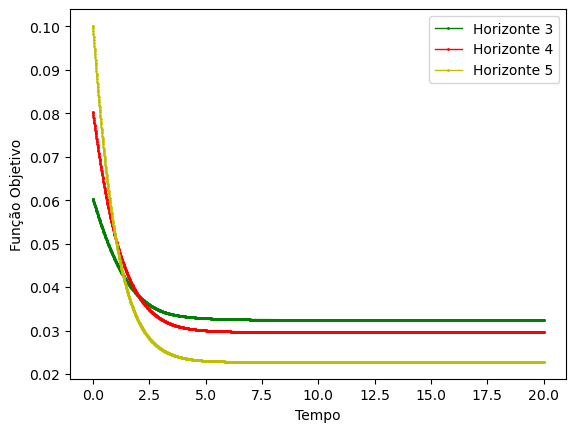

In [11]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(valoresFuncaoObjetivo4[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 4")
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.legend(loc="upper right")
#plt.savefig('valoresFuncaoObjetivo1.png', format='png')
plt.show()

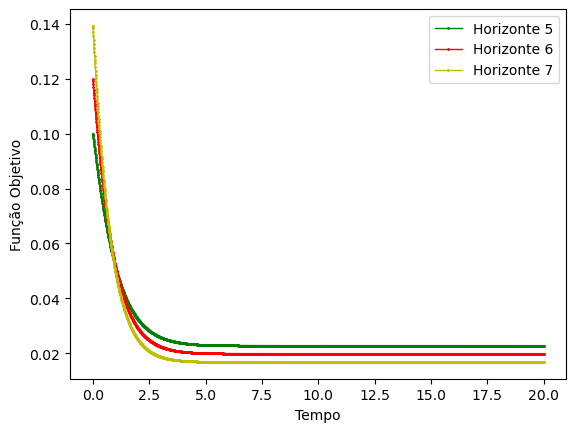

In [12]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.plot(ts, abs(valoresFuncaoObjetivo6[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 6")
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.legend(loc="upper right")
#plt.savefig('valoresFuncaoObjetivo2.png', format='png')
plt.show()

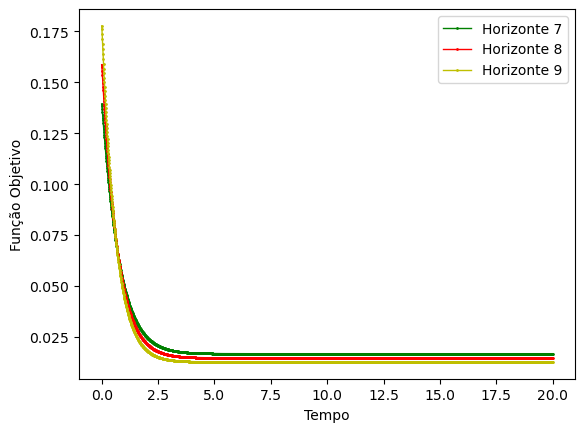

In [13]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.plot(ts, abs(valoresFuncaoObjetivo8[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 8")
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.legend(loc="upper right")
#plt.savefig('valoresFuncaoObjetivo3.png', format='png')
plt.show()

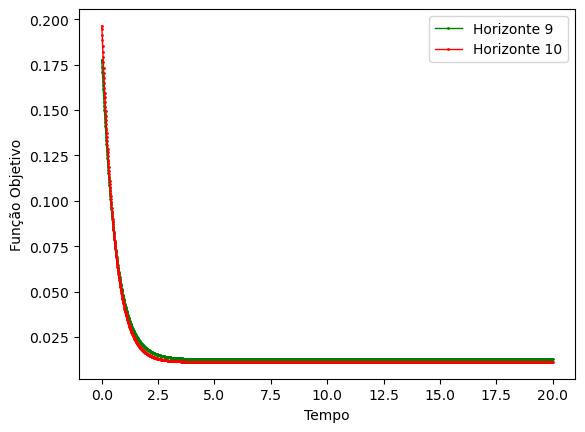

In [14]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.plot(ts, abs(valoresFuncaoObjetivo10[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 10")
plt.legend(loc="upper right")
#plt.savefig('valoresFuncaoObjetivo4.png', format='png')
plt.show()

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem do ajuste.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

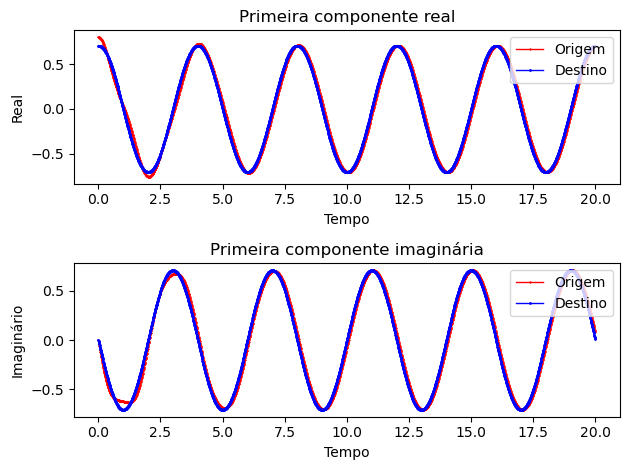

In [15]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem3 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem3[0][i] = ((abs(valoresOnda3[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem3[1][i] = ((abs(valoresOnda3[1][i]) - abs(evolucaoDestino[1][i])))

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

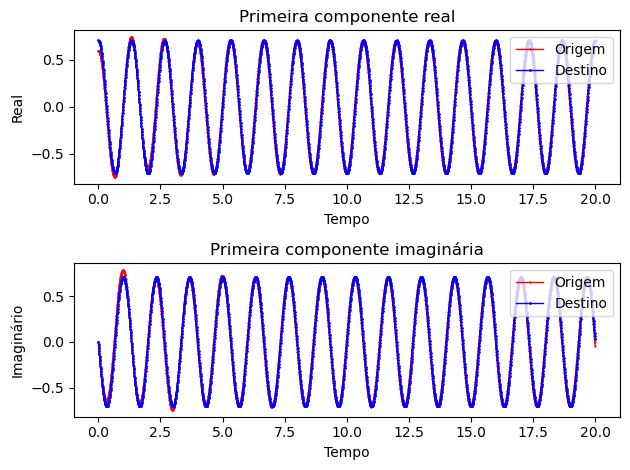

In [16]:
# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

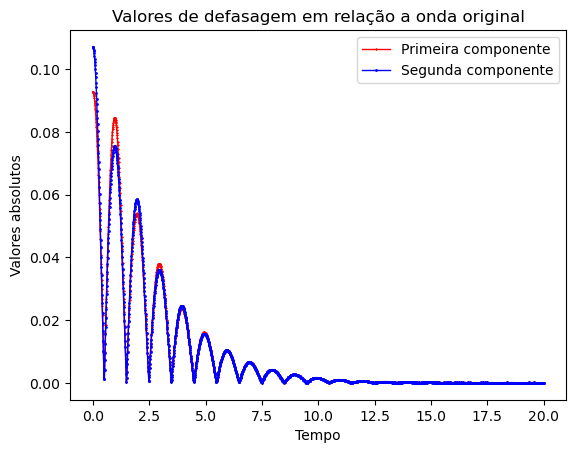

In [17]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

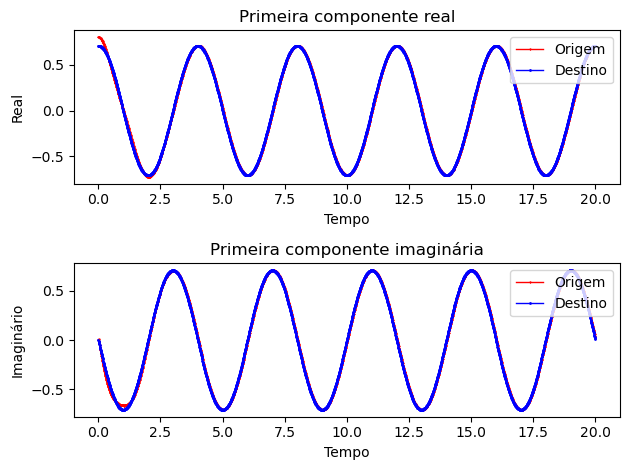

In [18]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda10[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda10[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda10[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda10[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem10 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem10[0][i] = ((abs(valoresOnda10[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem10[1][i] = ((abs(valoresOnda10[1][i]) - abs(evolucaoDestino[1][i])))

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

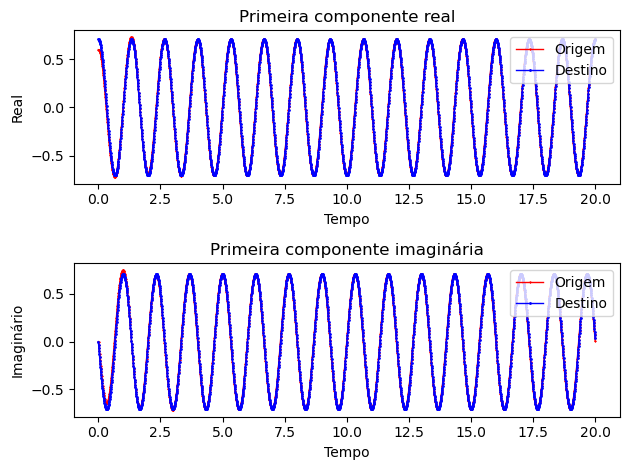

In [19]:
# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

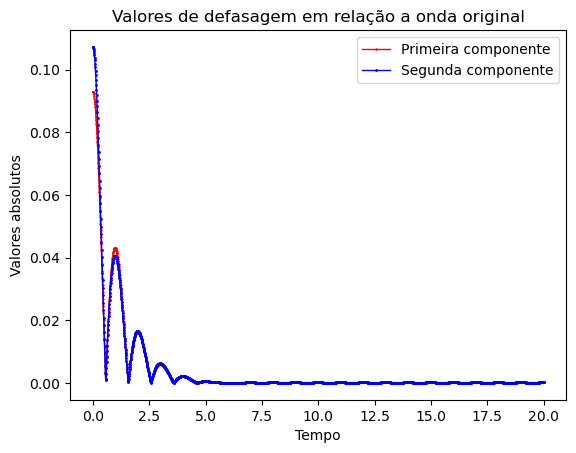

In [20]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [21]:
print(f"A defasagem para o horizonte 3, na sua primeira componente é:{abs(defasagem3[0][1999])}")
print(f"A defasagem para o horizonte 3, na sua segunda componente é:{abs(defasagem3[1][1999])}")
print(f"A defasagem para o horizonte 10, na sua primeira componente é:{abs(defasagem10[0][1999])}")
print(f"A defasagem para o horizonte 10, na sua segunda componente é:{abs(defasagem10[1][1999])}")

A defasagem para o horizonte 3, na sua primeira componente é:1.4378416503202374e-05
A defasagem para o horizonte 3, na sua segunda componente é:1.4487012895081364e-05
A defasagem para o horizonte 10, na sua primeira componente é:0.00016976046348926577
A defasagem para o horizonte 10, na sua segunda componente é:0.00016961202801824005


### Avaliação das constantes



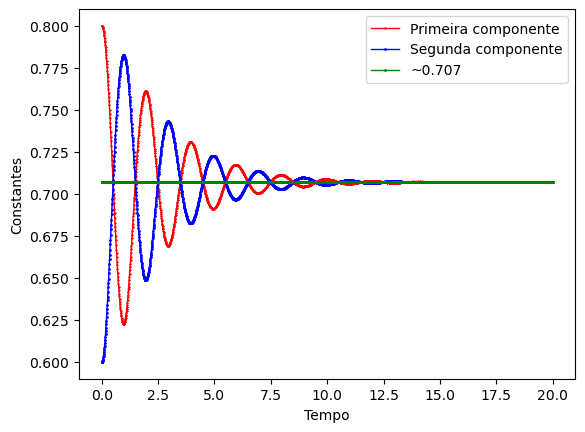

In [22]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

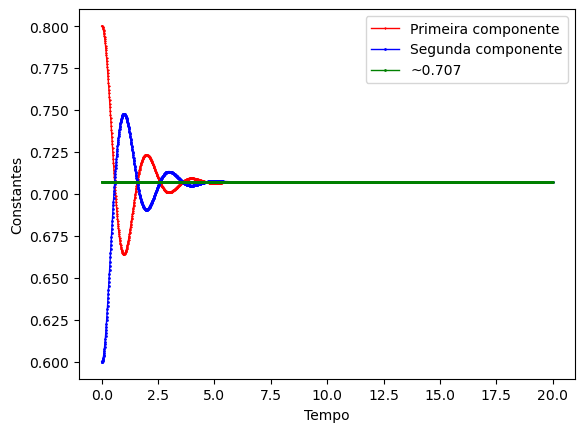

In [23]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

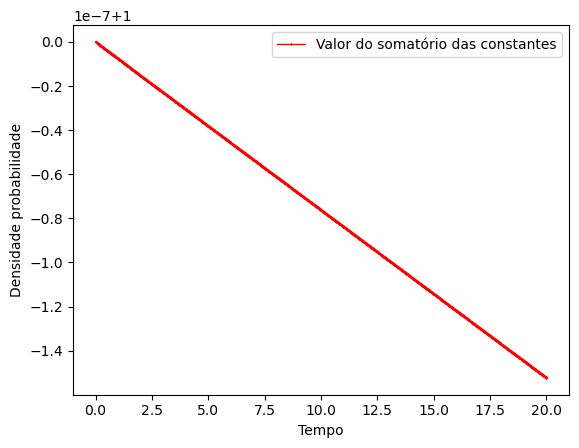

In [24]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(constantes10[0][i])**2+abs(constantes10[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
plt.savefig('dp.png', format='png')
plt.show()